lightGBMをクロスバリデーションで使う。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('reg_rent.csv')
floor_scores = pd.read_csv('floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')
buildings = pd.read_csv('buildings.csv')

rent = pd.read_csv('rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_contract_span2 = pd.read_csv('test_contract_span2.csv')
test_reg_rent = pd.read_csv('test_reg_rent.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('test_capital_floor_scores2.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_buildings = pd.read_csv('test_buildings.csv')

契約期間２&フル間取りでlightGBMを交差検証で学習

In [4]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K','S']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.430375245218262e-06,
        'max_bin': 502,
        'num_leaves': 97
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=3000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)


c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49657.6	valid_1's rmse: 52813.6
[20]	training's rmse: 35224.3	valid_1's rmse: 40947.7
[30]	training's rmse: 26528.4	valid_1's rmse: 34430
[40]	training's rmse: 20917.7	valid_1's rmse: 30626.8
[50]	training's rmse: 17662.1	valid_1's rmse: 28492
[60]	training's rmse: 15621.9	valid_1's rmse: 27248.4
[70]	training's rmse: 14228.8	valid_1's rmse: 26415.5
[80]	training's rmse: 13233.4	valid_1's rmse: 25887.3
[90]	training's rmse: 12528	valid_1's rmse: 25533.7
[100]	training's rmse: 11953.6	valid_1's rmse

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50762.6	valid_1's rmse: 52740.7
[20]	training's rmse: 36709	valid_1's rmse: 38947.9
[30]	training's rmse: 28601.6	valid_1's rmse: 30963.8
[40]	training's rmse: 23424	valid_1's rmse: 25582.8
[50]	training's rmse: 20450.5	valid_1's rmse: 22659.3
[60]	training's rmse: 18655.4	valid_1's rmse: 21037.3
[70]	training's rmse: 17413.4	valid_1's rmse: 20185.1
[80]	training's rmse: 16555.1	valid_1's rmse: 19532.9
[90]	training's rmse: 15916.2	valid_1's rmse: 19171
[100]	training's rmse: 15398.3	valid_1's rmse: 19010.4
[110]	training's rmse: 14934.2	valid_1's rmse: 18885.2

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50989.7	valid_1's rmse: 49508.7
[20]	training's rmse: 37101.5	valid_1's rmse: 35659.2
[30]	training's rmse: 28806.8	valid_1's rmse: 27858.5
[40]	training's rmse: 23636.8	valid_1's rmse: 23225.2
[50]	training's rmse: 20340.1	valid_1's rmse: 20599.3
[60]	training's rmse: 18399.3	valid_1's rmse: 19186.4
[70]	training's rmse: 17281.5	valid_1's rmse: 18326.7
[80]	training's rmse: 16479.3	valid_1's rmse: 17848.3
[90]	training's rmse: 15889.1	valid_1's rmse: 17591.3
[100]	training's rmse: 15377.5	valid_1's rmse: 17393.4
[110]	training's rmse: 14956.1	valid_1's rmse: 17288.7
[120]	training's rmse: 14541.2	valid_1's rmse: 17139.4
[130]	training's rmse: 14201.7	valid_1's rmse: 17053.7
[140]	training's rmse: 13862.5	valid_1's rmse: 16927.5
[150]	training's rmse: 13582.1	valid_1's rmse: 16857.1
[160]	training's rmse: 13294.5	valid_1's rmse: 16752.2
[170]	training's rmse: 13068.1	valid_1's rmse: 16702.2
[180]	trainin

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51159.8	valid_1's rmse: 48731.6
[20]	training's rmse: 36571.1	valid_1's rmse: 36230.8
[30]	training's rmse: 28260.9	valid_1's rmse: 29367
[40]	training's rmse: 23010.5	valid_1's rmse: 25081.9
[50]	training's rmse: 19900	valid_1's rmse: 22718.8
[60]	training's rmse: 18110.7	valid_1's rmse: 21463.2
[70]	training's rmse: 16994.4	valid_1's rmse: 20811.2
[80]	training's rmse: 16207.4	valid_1's rmse: 20294.7
[90]	training's rmse: 15575.1	valid_1's rmse: 19937.1
[100]	training's rmse: 15058.4	valid_1's rmse: 19722.3
[110]	training's rmse: 14598	valid_1's rmse: 19506.6

c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
c:\Users\koshi\python\signate\mynabi\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50459.8	valid_1's rmse: 53260.6
[20]	training's rmse: 36747.8	valid_1's rmse: 39511.5
[30]	training's rmse: 28663.5	valid_1's rmse: 31435.9
[40]	training's rmse: 23364.1	valid_1's rmse: 26253.4
[50]	training's rmse: 20247.6	valid_1's rmse: 23238
[60]	training's rmse: 18230.5	valid_1's rmse: 21535.5
[70]	training's rmse: 16977.7	valid_1's rmse: 20614.6
[80]	training's rmse: 16148.3	valid_1's rmse: 19946.2
[90]	training's rmse: 15563.7	valid_1's rmse: 19564.7
[100]	training's rmse: 15082.7	valid_1's 

,importance
面積,5.145099e+14
L,3.937205e+14
最寄り駅,1.515174e+14
築年数,8.489218e+13
全体の階数,8.239505e+13
所在地,7.270106e+13
所要時間,1.788143e+13
所在階,1.212840e+13
契約期間,9.641986e+12
部屋数,4.232639e+12


単純なホールドアウトに比べて大幅に過学習が緩和されている。

In [130]:
y_pred = pd.DataFrame(y_pred)
y_pred.head()

,0
0,126738.873820
1,124911.309729
2,71940.713020
3,60660.678043
4,111238.835082


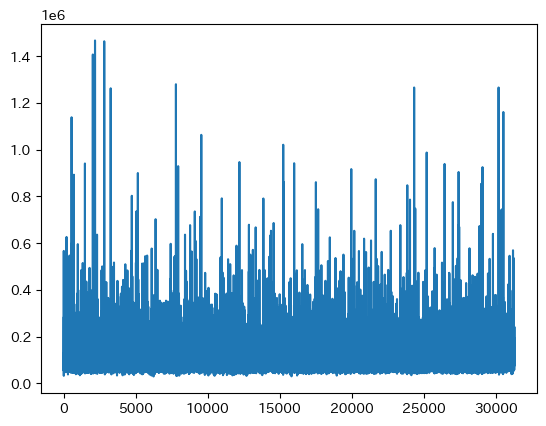

In [58]:
plt.plot(y_pred)

パラメータチューニングを行う。

In [128]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K",'S']]], axis=1)
y_train = rent
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)
category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'K', 'S']

lcv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [129]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)
study.best_params

[I 2022-09-10 23:09:02,059] A new study created in memory with name: no-name-f94ae760-a6c1-43b9-a6c4-a38605e196b2
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49657.6	valid_1's rmse: 52813.6
[20]	training's rmse: 35224.3	valid_1's rmse: 40947.7
[30]	training's rmse: 26528.4	valid_1's rmse: 34430
[40]	training's rmse: 20917.7	valid_1's rmse: 30626.8
[50]	training's rmse: 17662.1	valid_1's rmse: 28492
[60]	training's rmse: 15621.9	valid_1's rmse: 27248.4
[70]	training's rmse: 14228.8	valid_1's rmse: 26415.5
[80]	training's rmse: 13233.4	valid_1's rmse: 25887.3
[90]	training's rmse: 12528	valid_1's rmse: 25533.7
[100]	training's rmse: 11953.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50762.6	valid_1's rmse: 52740.7
[20]	training's rmse: 36709	valid_1's rmse: 38947.9
[30]	training's rmse: 28601.6	valid_1's rmse: 30963.8
[40]	training's rmse: 23424	valid_1's rmse: 25582.8
[50]	training's rmse: 20450.5	valid_1's rmse: 22659.3
[60]	training's rmse: 18655.4	valid_1's rmse: 21037.3
[70]	training's rmse: 17413.4	valid_1's rmse: 20185.1
[80]	training's rmse: 16555.1	valid_1's rmse: 19532.9
[90]	training's rmse: 15916.2	valid_1's rmse: 19171
[100]	training's rmse: 15398.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28806.8	valid_1's rmse: 27858.5
[40]	training's rmse: 23636.8	valid_1's rmse: 23225.2
[50]	training's rmse: 20340.1	valid_1's rmse: 20599.3
[60]	training's rmse: 18399.3	valid_1's rmse: 19186.4
[70]	training's rmse: 17281.5	valid_1's rmse: 18326.7
[80]	training's rmse: 16479.3	valid_1's rmse: 17848.3
[90]	training's rmse: 15889.1	valid_1's rmse: 17591.3
[100]	training's rmse: 15377.5	valid_1's rmse: 17393.4
[110]	training's rmse: 14956.1	valid_1's rmse: 17288.7
[120]	training's rmse: 14541.2	valid_1's rmse: 17139.4
[130]	training's rmse: 14201.7	valid_1's rmse: 17053.7
[140]	training's rmse: 13862.5	valid_1's rmse: 16927.5
[150]	training's rmse: 13582.1	valid_1's rmse: 16857.1
[160]	training's rmse: 13294.5	valid_1's rmse: 16752.2
[170]	training's rmse: 13068.1	valid_1's rmse: 16702.2
[180]	training's rmse: 12827.4	valid_1's rmse: 16620.2
[190]	training's rmse: 12595.8	valid_1's rmse: 16549.3
[200]	training's rmse: 12384.3	valid_1's rmse: 16462.7
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51159.8	valid_1's rmse: 48731.6
[20]	training's rmse: 36571.1	valid_1's rmse: 36230.8
[30]	training's rmse: 28260.9	valid_1's rmse: 29367
[40]	training's rmse: 23010.5	valid_1's rmse: 25081.9
[50]	training's rmse: 19900	valid_1's rmse: 22718.8
[60]	training's rmse: 18110.7	valid_1's rmse: 21463.2
[70]	training's rmse: 16994.4	valid_1's rmse: 20811.2
[80]	training's rmse: 16207.4	valid_1's rmse: 20294.7
[90]	training's rmse: 15575.1	valid_1's rmse: 19937.1
[100]	training's rmse: 15058.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36747.8	valid_1's rmse: 39511.5
[30]	training's rmse: 28663.5	valid_1's rmse: 31435.9
[40]	training's rmse: 23364.1	valid_1's rmse: 26253.4
[50]	training's rmse: 20247.6	valid_1's rmse: 23238
[60]	training's rmse: 18230.5	valid_1's rmse: 21535.5
[70]	training's rmse: 16977.7	valid_1's rmse: 20614.6
[80]	training's rmse: 16148.3	valid_1's rmse: 19946.2
[90]	training's rmse: 15563.7	valid_1's rmse: 19564.7
[100]	training's rmse: 15082.7	valid_1's rmse: 19338.8
[110]	training's rmse: 14660.6	valid_1's rmse: 19096.5
[120]	training's rmse: 14308.7	valid_1's rmse: 18959.2
[130]	training's rmse: 13984.9	valid_1's rmse: 18822.7
[140]	training's rmse: 13702	valid_1's rmse: 18733.7
[150]	training's rmse: 13448.2	valid_1's rmse: 18657.5
[160]	training's rmse: 13175.4	valid_1's rmse: 18513
[170]	training's rmse: 12940	valid_1's rmse: 18432.3
[180]	training's rmse: 12730.5	valid_1's rmse: 18350.6
[190]	training's rmse: 12544.5	valid_1's rmse: 18295.3
[200]	training's rmse: 123

[I 2022-09-10 23:09:14,838] Trial 0 finished with value: 17658.247855708043 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2113
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49837.6	valid_1's rmse: 52848
[20]	training's rmse: 35263.4	valid_1's rmse: 40946.6
[30]	training's rmse: 26730.8	valid_1's rmse: 34601.9
[40]	training's rmse: 20884.2	valid_1's rmse: 30738.3
[50]	training's rmse: 17572.6	valid_1's rmse: 28605.5
[60]	training's rmse: 15523	valid_1's rmse: 27345.8
[70]	training's rmse: 14155.9	valid_1's rmse: 26531.9
[80]	training's rmse: 13197	valid_1's rmse: 25961.7
[90]	training's rmse: 12501.1	valid_1's rmse: 25590.7
[100]	training's rmse: 11963.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50261.1	valid_1's rmse: 51960.1
[20]	training's rmse: 36170.1	valid_1's rmse: 38358.4
[30]	training's rmse: 27969	valid_1's rmse: 30573.8
[40]	training's rmse: 22979.3	valid_1's rmse: 25619.9
[50]	training's rmse: 20031.5	valid_1's rmse: 22914.2
[60]	training's rmse: 18226.2	valid_1's rmse: 21498.6
[70]	training's rmse: 16958.8	valid_1's rmse: 20604
[80]	training's rmse: 16010.5	valid_1's rmse: 20072.4
[90]	training's rmse: 15306.7	valid_1's rmse: 19767.8
[100]	training's rmse: 14722.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50786.4	valid_1's rmse: 49803.5
[20]	training's rmse: 36805.5	valid_1's rmse: 36453.9
[30]	training's rmse: 28595.6	valid_1's rmse: 28897.7
[40]	training's rmse: 23363.8	valid_1's rmse: 24207.1
[50]	training's rmse: 20295	valid_1's rmse: 21603.4
[60]	training's rmse: 18344	valid_1's rmse: 20055.4
[70]	training's rmse: 17167.8	valid_1's rmse: 19252.2
[80]	training's rmse: 16342.8	valid_1's rmse: 18854.3
[90]	training's rmse: 15722.1	valid_1's rmse: 18609
[100]	training's rmse: 15161.6	valid_1's rmse: 18393
[110]	training's rmse: 14710.1	valid_1's rmse: 18222.2
[120]	training's rmse: 14288.7	valid_1's rmse: 18102.5
[130]	training's rmse: 13945.2	valid_1's rmse: 18030.1
[140]	training's rmse: 13612.7	valid_1's rmse: 17989.3
[150]	training's rmse: 13295.8	valid_1's rmse: 17962.3
[160]	training's rmse: 13021.6	valid_1's rmse: 17922.8
[170]	training's rmse: 12758.8	valid_1's rmse: 17890.9
[180]	training's rmse: 12527.8	valid_1's rmse: 17859.6
[190]	training's rmse: 1230

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36561.6	valid_1's rmse: 35780
[30]	training's rmse: 28232.9	valid_1's rmse: 28821.9
[40]	training's rmse: 22910.9	valid_1's rmse: 24349
[50]	training's rmse: 19829.9	valid_1's rmse: 21849.7
[60]	training's rmse: 17997.5	valid_1's rmse: 20551
[70]	training's rmse: 16798.2	valid_1's rmse: 19826.8
[80]	training's rmse: 15934.4	valid_1's rmse: 19352.9
[90]	training's rmse: 15289.2	valid_1's rmse: 19047.8
[100]	training's rmse: 14764.3	valid_1's rmse: 18778.9
[110]	training's rmse: 14363.6	valid_1's rmse: 18593.8
[120]	training's rmse: 14006.4	valid_1's rmse: 18468.6
[130]	training's rmse: 13648.2	valid_1's rmse: 18343.9
[140]	training's rmse: 13296.8	valid_1's rmse: 18189.2
[150]	training's rmse: 13021.5	valid_1's rmse: 18145.3
[160]	training's rmse: 12743	valid_1's rmse: 18088
[170]	training's rmse: 12498	valid_1's rmse: 18002.5
[180]	training's rmse: 12255.7	valid_1's rmse: 17964.6
[190]	training's rmse: 12004.3	valid_1's rmse: 17927.6
[200]	training's rmse: 11797.1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2111
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50208.1	valid_1's rmse: 53368.3
[20]	training's rmse: 36507.2	valid_1's rmse: 39801.2
[30]	training's rmse: 28469.1	valid_1's rmse: 31701.1
[40]	training's rmse: 23198.2	valid_1's rmse: 26770.5
[50]	training's rmse: 20056.1	valid_1's rmse: 23958.7
[60]	training's rmse: 18131.7	valid_1's rmse: 22428.9
[70]	training's rmse: 16851.1	valid_1's rmse: 21535.8
[80]	training's rmse: 15956.8	valid_1's rmse: 20830.2
[90]	training's rmse: 15343.5	valid_1's rmse: 20402.5
[100]	training's rmse: 14827.3	valid_1'

[I 2022-09-10 23:09:27,407] Trial 1 finished with value: 18991.437780684704 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49595.3	valid_1's rmse: 52710.7
[20]	training's rmse: 35016.2	valid_1's rmse: 41108.7
[30]	training's rmse: 26045.7	valid_1's rmse: 34484.5
[40]	training's rmse: 20350.8	valid_1's rmse: 30663.8
[50]	training's rmse: 17017.4	valid_1's rmse: 28550.5
[60]	training's rmse: 14999	valid_1's rmse: 27295.2
[70]	training's rmse: 13598.6	valid_1's rmse: 26411.9
[80]	training's rmse: 12621.7	valid_1's rmse: 25829.5
[90]	training's rmse: 11941.7	valid_1's rmse: 25416.7
[100]	training's rmse: 11414.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50336.3	valid_1's rmse: 51925.6
[20]	training's rmse: 36116.4	valid_1's rmse: 38286.8
[30]	training's rmse: 27905.8	valid_1's rmse: 30322.4
[40]	training's rmse: 22774.3	valid_1's rmse: 25131.2
[50]	training's rmse: 19790.5	valid_1's rmse: 22213.3
[60]	training's rmse: 18016.3	valid_1's rmse: 20550.6
[70]	training's rmse: 16813.9	valid_1's rmse: 19614.7
[80]	training's rmse: 15928	valid_1's rmse: 19019.6
[90]	training's rmse: 15272.6	valid_1's rmse: 18684.3
[100]	training's rmse: 14730.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2467
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50430.1	valid_1's rmse: 49526.9
[20]	training's rmse: 36384.5	valid_1's rmse: 35953.7
[30]	training's rmse: 28033.1	valid_1's rmse: 28426.9
[40]	training's rmse: 22721.2	valid_1's rmse: 23657.2
[50]	training's rmse: 19518.7	valid_1's rmse: 21122.5
[60]	training's rmse: 17582.4	valid_1's rmse: 19795.3
[70]	training's rmse: 16445.3	valid_1's rmse: 18900.1
[80]	training's rmse: 15617.8	valid_1's rmse: 18511.1
[90]	training's rmse: 15004.5	valid_1's rmse: 18197
[100]	training's rmse: 14533.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50817.9	valid_1's rmse: 48608.5
[20]	training's rmse: 36204.1	valid_1's rmse: 35881.2
[30]	training's rmse: 27743	valid_1's rmse: 28961.1
[40]	training's rmse: 22429.7	valid_1's rmse: 24608.1
[50]	training's rmse: 19287.1	valid_1's rmse: 22238.1
[60]	training's rmse: 17551.6	valid_1's rmse: 21021
[70]	training's rmse: 16441.7	valid_1's rmse: 20343.9
[80]	training's rmse: 15635.8	valid_1's rmse: 19854.2
[90]	training's rmse: 15036.6	valid_1's rmse: 19530.5
[100]	training's rmse: 14588.4	valid_1's rmse: 19281.5
[110]	training's rmse: 14232.8	valid_1's rmse: 19150.8
[120]	training's rmse: 13826.4	valid_1's rmse: 19019
[130]	training's rmse: 13511.4	valid_1's rmse: 18954.5
[140]	training's rmse: 13156	valid_1's rmse: 18891.2
[150]	training's rmse: 12857.9	valid_1's rmse: 18811.7
[160]	training's rmse: 12616.2	valid_1's rmse: 18789.7
[170]	training's rmse: 12378.4	valid_1's rmse: 18711.3
[180]	training's rmse: 12167.2	valid_1's rmse: 18640.8
[190]	training's rmse: 1198

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2467
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50249.3	valid_1's rmse: 53048.4
[20]	training's rmse: 36445.2	valid_1's rmse: 39178.9
[30]	training's rmse: 28279.9	valid_1's rmse: 31103.1
[40]	training's rmse: 23035.6	valid_1's rmse: 26079
[50]	training's rmse: 19831.4	valid_1's rmse: 23211.8
[60]	training's rmse: 17873.9	valid_1's rmse: 21703.7
[70]	training's rmse: 16598.5	valid_1's rmse: 20878.5
[80]	training's rmse: 15793.2	valid_1's rmse: 20507.1
[90]	training's rmse: 15183.1	valid_1's rmse: 20276.1
[100]	training's rmse: 14715.7	valid_1's 

[I 2022-09-10 23:09:42,007] Trial 2 finished with value: 19790.467816267374 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 17658.247855708043.


[200]	training's rmse: 12176.2	valid_1's rmse: 19802.8
Early stopping, best iteration is:
[196]	training's rmse: 12245.7	valid_1's rmse: 19790.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49861.3	valid_1's rmse: 52937.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35343	valid_1's rmse: 41346.6
[30]	training's rmse: 26744.6	valid_1's rmse: 34920.2
[40]	training's rmse: 20950.8	valid_1's rmse: 31030.3
[50]	training's rmse: 17589.6	valid_1's rmse: 28870.3
[60]	training's rmse: 15505.8	valid_1's rmse: 27620
[70]	training's rmse: 14055.1	valid_1's rmse: 26765.7
[80]	training's rmse: 13112.2	valid_1's rmse: 26303.5
[90]	training's rmse: 12421.3	valid_1's rmse: 25897.5
[100]	training's rmse: 11862.7	valid_1's rmse: 25589.6
[110]	training's rmse: 11404.2	valid_1's rmse: 25342.3
[120]	training's rmse: 11013.6	valid_1's rmse: 25095.3
[130]	training's rmse: 10651.7	valid_1's rmse: 24887
[140]	training's rmse: 10364.2	valid_1's rmse: 24725.2
[150]	training's rmse: 10064.7	valid_1's rmse: 24544.6
[160]	training's rmse: 9800.47	valid_1's rmse: 24381.7
[170]	training's rmse: 9509.82	valid_1's rmse: 24206.6
[180]	training's rmse: 9252.58	valid_1's rmse: 24055.1
[190]	training's rmse: 9025.26	valid_1's rmse: 23927.9
[200]	training's rmse: 8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50698.7	valid_1's rmse: 52669.8
[20]	training's rmse: 36485.7	valid_1's rmse: 38767.6
[30]	training's rmse: 28419.3	valid_1's rmse: 30761.9
[40]	training's rmse: 23366.9	valid_1's rmse: 25606.6
[50]	training's rmse: 20440.6	valid_1's rmse: 22480.5
[60]	training's rmse: 18665.3	valid_1's rmse: 21001.1
[70]	training's rmse: 17451.9	valid_1's rmse: 20015.9
[80]	training's rmse: 16556.6	valid_1's rmse: 19344.8
[90]	training's rmse: 15924.6	valid_1's rmse: 18980.4
[100]	training's rmse: 15384.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28769.1	valid_1's rmse: 28641.2
[40]	training's rmse: 23566.9	valid_1's rmse: 23907.7
[50]	training's rmse: 20344.8	valid_1's rmse: 21160.4
[60]	training's rmse: 18407.1	valid_1's rmse: 19707.9
[70]	training's rmse: 17191.6	valid_1's rmse: 18684.5
[80]	training's rmse: 16312.7	valid_1's rmse: 18162.5
[90]	training's rmse: 15692.7	valid_1's rmse: 17877
[100]	training's rmse: 15200.4	valid_1's rmse: 17706.1
[110]	training's rmse: 14803.4	valid_1's rmse: 17575
[120]	training's rmse: 14453.4	valid_1's rmse: 17470.8
[130]	training's rmse: 14128.8	valid_1's rmse: 17402.7
[140]	training's rmse: 13777.1	valid_1's rmse: 17338.3
[150]	training's rmse: 13475.8	valid_1's rmse: 17289
[160]	training's rmse: 13218.2	valid_1's rmse: 17243.3
[170]	training's rmse: 12975.9	valid_1's rmse: 17148.3
[180]	training's rmse: 12748.3	valid_1's rmse: 17103.3
[190]	training's rmse: 12509.3	valid_1's rmse: 17124.9
Early stopping, best iteration is:
[184]	training's rmse: 12670.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36651.6	valid_1's rmse: 36229.3
[30]	training's rmse: 28367.6	valid_1's rmse: 29434.3
[40]	training's rmse: 23029	valid_1's rmse: 24968.7
[50]	training's rmse: 19940.6	valid_1's rmse: 22484.6
[60]	training's rmse: 18145.5	valid_1's rmse: 21214.7
[70]	training's rmse: 17005.4	valid_1's rmse: 20454.7
[80]	training's rmse: 16190.1	valid_1's rmse: 19891.2
[90]	training's rmse: 15507.1	valid_1's rmse: 19493.4
[100]	training's rmse: 14868.7	valid_1's rmse: 19211.8
[110]	training's rmse: 14424.6	valid_1's rmse: 18982
[120]	training's rmse: 13995.8	valid_1's rmse: 18835.6
[130]	training's rmse: 13670.8	valid_1's rmse: 18730.2
[140]	training's rmse: 13354.4	valid_1's rmse: 18644.9
[150]	training's rmse: 13074.1	valid_1's rmse: 18593.1
[160]	training's rmse: 12815.9	valid_1's rmse: 18563.1
[170]	training's rmse: 12593.1	valid_1's rmse: 18535.6
[180]	training's rmse: 12348.5	valid_1's rmse: 18494
[190]	training's rmse: 12120.9	valid_1's rmse: 18404.6
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50468.4	valid_1's rmse: 53210.3
[20]	training's rmse: 36787.1	valid_1's rmse: 39491.1
[30]	training's rmse: 28652	valid_1's rmse: 31328.7
[40]	training's rmse: 23238.1	valid_1's rmse: 26163.1
[50]	training's rmse: 20162.7	valid_1's rmse: 23236.5
[60]	training's rmse: 18179.8	valid_1's rmse: 21756.5
[70]	training's rmse: 16937.4	valid_1's rmse: 20921
[80]	training's rmse: 16107.7	valid_1's rmse: 20388.3
[90]	training's rmse: 15513.1	valid_1's rmse: 20072.8
[100]	training's rmse: 15051.8	valid_1's rm

[I 2022-09-10 23:09:54,515] Trial 3 finished with value: 19479.789435273535 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 17658.247855708043.


Early stopping, best iteration is:
[149]	training's rmse: 13435.6	valid_1's rmse: 19479.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50304.5	valid_1's rmse: 53229
[20]	training's rmse: 36076.3	valid_1's rmse: 41762.8
[30]	training's rmse: 27614.3	valid_1's rmse: 35434.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[40]	training's rmse: 21826.1	valid_1's rmse: 31416.6
[50]	training's rmse: 18500.6	valid_1's rmse: 29145.3
[60]	training's rmse: 16389.2	valid_1's rmse: 27737.3
[70]	training's rmse: 15012.5	valid_1's rmse: 26921.7
[80]	training's rmse: 14086.4	valid_1's rmse: 26424.1
[90]	training's rmse: 13371.8	valid_1's rmse: 26037
[100]	training's rmse: 12793	valid_1's rmse: 25665.4
[110]	training's rmse: 12335.7	valid_1's rmse: 25361.4
[120]	training's rmse: 11942.8	valid_1's rmse: 25109.5
[130]	training's rmse: 11576.4	valid_1's rmse: 24854.4
[140]	training's rmse: 11260.6	valid_1's rmse: 24666.7
[150]	training's rmse: 10918.6	valid_1's rmse: 24431.8
[160]	training's rmse: 10631.4	valid_1's rmse: 24242.7
[170]	training's rmse: 10377.9	valid_1's rmse: 24069.8
[180]	training's rmse: 10147.6	valid_1's rmse: 23915.3
[190]	training's rmse: 9938.82	valid_1's rmse: 23779.4
[200]	training's rmse: 9739.2	valid_1's rmse: 23656.7
[210]	training's rmse: 9560.91	valid_1's rmse: 23542.4
[220]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51098.9	valid_1's rmse: 52684
[20]	training's rmse: 37131	valid_1's rmse: 38836.7
[30]	training's rmse: 29067.6	valid_1's rmse: 30850.4
[40]	training's rmse: 23923.8	valid_1's rmse: 25469.5
[50]	training's rmse: 20995.6	valid_1's rmse: 22612
[60]	training's rmse: 19093.6	valid_1's rmse: 20781.7
[70]	training's rmse: 17865	valid_1's rmse: 19752
[80]	training's rmse: 16935.8	valid_1's rmse: 18970.6
[90]	training's rmse: 16243.3	valid_1's rmse: 18519.4
[100]	training's rmse: 15715.8	valid_1's rmse: 18285.4
[110]	training's rmse: 15272.8	valid_1's rmse: 18120.4
[120]	training's rmse: 14863.5	valid_1's rmse: 18066.5
[130]	training's rmse: 14522.3	valid_1's rmse: 18063.6
Early stopping, best iteration is:
[126]	training's rmse: 14655.7	valid_1's rmse: 18054.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0011

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51122.7	valid_1's rmse: 50037.3
[20]	training's rmse: 37244.6	valid_1's rmse: 36639.3
[30]	training's rmse: 29054.6	valid_1's rmse: 28939.3
[40]	training's rmse: 23829.6	valid_1's rmse: 24311.2
[50]	training's rmse: 20749.5	valid_1's rmse: 21712
[60]	training's rmse: 18844.8	valid_1's rmse: 20233.5
[70]	training's rmse: 17656.3	valid_1's rmse: 19296.9
[80]	training's rmse: 16815	valid_1's rmse: 18745.5
[90]	training's rmse: 16200.4	valid_1's rmse: 18460.5
[100]	training's rmse: 15709.7	valid_1's rmse: 18257.4
[110]	training's rmse: 15314.1	valid_1's rmse: 18119.3
[120]	training's rmse: 14945.3	valid_1's rmse: 18004.7
[130]	training's rmse: 14629.1	valid_1's rmse: 17925.8
[140]	training's rmse: 14311.5	valid_1's rmse: 17894.8
[150]	training's rmse: 14015	valid_1's rmse: 17896.5
Early stopping, best iteration is:
[140]	training's rmse: 14311.5	valid_1's rmse: 17894.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2495
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51495.4	valid_1's rmse: 49176.9
[20]	training's rmse: 37284.3	valid_1's rmse: 37026.2
[30]	training's rmse: 29133.6	valid_1's rmse: 30400.5
[40]	training's rmse: 23691.3	valid_1's rmse: 25825.6
[50]	training's rmse: 20626.9	valid_1's rmse: 23223.4
[60]	training's rmse: 18829	valid_1's rmse: 21840.1
[70]	training's rmse: 17643.9	valid_1's rmse: 20935.8
[80]	training's rmse: 16804.8	valid_1's rmse: 20342
[90]	training's rmse: 16146.3	valid_1's rmse: 19955.7
[100]	training's rmse: 15646.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50936.1	valid_1's rmse: 53662.8
[20]	training's rmse: 37288.5	valid_1's rmse: 39870.4
[30]	training's rmse: 29361.9	valid_1's rmse: 31771.7
[40]	training's rmse: 23946.7	valid_1's rmse: 26483.2
[50]	training's rmse: 20860.9	valid_1's rmse: 23556.4
[60]	training's rmse: 18891.2	valid_1's rmse: 21975.3
[70]	training's rmse: 17583.9	valid_1's rmse: 21092.4
[80]	training's rmse: 16757.9	valid_1's rmse: 20525.5
[90]	training's rmse: 16156.6	valid_1's rmse: 20222.8
[100]	training's rmse: 15676.7	valid_1'

[I 2022-09-10 23:10:03,812] Trial 4 finished with value: 19437.113998862755 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 17658.247855708043.


[260]	training's rmse: 12209	valid_1's rmse: 19455.8
[270]	training's rmse: 12084.3	valid_1's rmse: 19443.6
[280]	training's rmse: 11969.2	valid_1's rmse: 19441
Early stopping, best iteration is:
[271]	training's rmse: 12074.8	valid_1's rmse: 19437.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50030.7	valid_1's rmse: 53537.2
[20]	training's rmse: 35463.8	valid_1's rmse: 41941.6
[30]	training's rmse: 26759.5	valid_1's rmse: 35343.8
[40]	training's rmse: 21195.3	valid_1's rmse: 31533
[50]	training's rmse: 17845.1	valid_1's rmse: 29275.1
[60]	training's rmse: 15772.4	valid_1's rmse: 27904.6
[70]	training's rmse: 14227.3	valid_1's rmse: 27016.5
[80]	training's rmse: 13204	valid_1's rmse: 26468.5
[90]	training's rmse: 12447.4	valid_1's rmse: 26077.6
[100]	training's rmse: 11844.4	valid_1's rmse: 25721
[110]	training's rmse: 11307.9	valid_1's rmse: 25428.6
[120]	training's rmse: 10845	valid_1's rmse: 25180.2
[130]	training's rmse: 10431.9	valid_1's rmse: 24978.6
[140]	training's rmse: 10038.1	valid_1's rmse: 24793.2
[150]	training's rmse: 9672.71	valid_1's rmse: 24616.2
[160]	training's rmse: 9355.88	valid_1's rmse: 24465.8
[170]	training's rmse: 9092.41	valid_1's rmse: 24335.6
[180]	training's rmse: 8862.44	valid_1's rmse: 24213.9
[190]	training's rmse: 8632

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50579.9	valid_1's rmse: 51789.5
[20]	training's rmse: 36412.3	valid_1's rmse: 38080.5
[30]	training's rmse: 28251.9	valid_1's rmse: 30205.1
[40]	training's rmse: 23190.7	valid_1's rmse: 25098.6
[50]	training's rmse: 20199.5	valid_1's rmse: 22084.6
[60]	training's rmse: 18235.9	valid_1's rmse: 20408.3
[70]	training's rmse: 16876	valid_1's rmse: 19448.3
[80]	training's rmse: 15962.6	valid_1's rmse: 18864.8
[90]	training's rmse: 15252.9	valid_1's rmse: 18499.8
[100]	training's rmse: 14707.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50682.1	valid_1's rmse: 50302.7
[20]	training's rmse: 36553.8	valid_1's rmse: 36634.9
[30]	training's rmse: 28335.1	valid_1's rmse: 29065.8
[40]	training's rmse: 23134.3	valid_1's rmse: 24382.2
[50]	training's rmse: 19932.7	valid_1's rmse: 21680.2
[60]	training's rmse: 18015.7	valid_1's rmse: 20197.9
[70]	training's rmse: 16751.3	valid_1's rmse: 19326.7
[80]	training's rmse: 15860.1	valid_1's rmse: 18930
[90]	training's rmse: 15137.6	valid_1's rmse: 18610
[100]	training's rmse: 14571.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51094.6	valid_1's rmse: 48536
[20]	training's rmse: 36529.9	valid_1's rmse: 36098.2
[30]	training's rmse: 28063.4	valid_1's rmse: 29259.3
[40]	training's rmse: 22806.7	valid_1's rmse: 25044.6
[50]	training's rmse: 19779.7	valid_1's rmse: 22701.7
[60]	training's rmse: 17907.2	valid_1's rmse: 21529.2
[70]	training's rmse: 16649.1	valid_1's rmse: 20874
[80]	training's rmse: 15705.7	valid_1's rmse: 20357
[90]	training's rmse: 15025.5	valid_1's rmse: 20043.1
[100]	training's rmse: 14466.9	valid_1's rmse: 19834.6
[110]	training's rmse: 13996.1	valid_1's rmse: 19715.4
[120]	training's rmse: 13582.9	valid_1's rmse: 19637.4
[130]	training's rmse: 13216.8	valid_1's rmse: 19491.5
[140]	training's rmse: 12900.5	valid_1's rmse: 19379.8
[150]	training's rmse: 12598	valid_1's rmse: 19264.1
[160]	training's rmse: 12305.6	valid_1's rmse: 19225.1
[170]	training's rmse: 12028.6	valid_1's rmse: 19173.1
[180]	training's rmse: 11769.9	valid_1's rmse: 19158.1
[190]	training's rmse: 1155

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50323.1	valid_1's rmse: 53177.8
[20]	training's rmse: 36789.1	valid_1's rmse: 39576.7
[30]	training's rmse: 28592.5	valid_1's rmse: 31259.9
[40]	training's rmse: 23216	valid_1's rmse: 26136.8
[50]	training's rmse: 20061.1	valid_1's rmse: 23431.2
[60]	training's rmse: 18108.3	valid_1's rmse: 22121.2
[70]	training's rmse: 16803.3	valid_1's rmse: 21364.7
[80]	training's rmse: 15874.4	valid_1's rmse: 20893.2
[90]	training's rmse: 15208.1	valid_1's rmse: 20559.2
[100]	training's rmse: 14660.1	valid_1's rmse: 20308.3
[110]	training's rmse: 14200.7	valid_1's rmse: 20130.5
[120]	training's rmse: 13814.9	valid_1's rmse: 20015.5
[130]	training's rmse: 13444	valid_1's rmse: 19898.8
[140]	training's rmse: 13113.9	valid_1's rmse: 19803.3
[150]	training's rmse: 12799.5	valid_1's rmse: 19647.6
[160]	training's rmse: 12512.4	valid_1's rmse: 19593.1
[170]	training's rmse: 12233.5	valid_1's rmse: 19517.7
[180]	training's rmse: 12009.8	valid_1's rmse: 19429.1
[190]	training's rmse: 

[I 2022-09-10 23:10:18,992] Trial 5 finished with value: 18606.450550911773 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49686	valid_1's rmse: 52710.9
[20]	training's rmse: 35070.5	valid_1's rmse: 40964.6
[30]	training's rmse: 26199.9	valid_1's rmse: 34439.3
[40]	training's rmse: 20495.2	valid_1's rmse: 30647.2
[50]	training's rmse: 17125.9	valid_1's rmse: 28540.1
[60]	training's rmse: 15124	valid_1's rmse: 27317.5
[70]	training's rmse: 13697.3	valid_1's rmse: 26480.7
[80]	training's rmse: 12696.5	valid_1's rmse: 25939.4
[90]	training's rmse: 11991.1	valid_1's rmse: 25523.4
[100]	training's rmse: 11452.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50351.3	valid_1's rmse: 51904.4
[20]	training's rmse: 36080.9	valid_1's rmse: 38131
[30]	training's rmse: 27844.9	valid_1's rmse: 30251.4
[40]	training's rmse: 22723.6	valid_1's rmse: 25089.4
[50]	training's rmse: 19869.6	valid_1's rmse: 22220.8
[60]	training's rmse: 18083.9	valid_1's rmse: 20718.6
[70]	training's rmse: 16903.6	valid_1's rmse: 19764.9
[80]	training's rmse: 16058.8	valid_1's rmse: 19167.5
[90]	training's rmse: 15424.3	valid_1's rmse: 18767.3
[100]	training's rmse: 14876.4	valid_1's rmse: 18526.1
[110]	training's rmse: 14390.1	valid_1's rmse: 184

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36584.5	valid_1's rmse: 35964.1
[30]	training's rmse: 28265.9	valid_1's rmse: 28390.2
[40]	training's rmse: 22808.8	valid_1's rmse: 23593.8
[50]	training's rmse: 19618.7	valid_1's rmse: 21062.2
[60]	training's rmse: 17678.1	valid_1's rmse: 19712.7
[70]	training's rmse: 16484.5	valid_1's rmse: 18842.3
[80]	training's rmse: 15674.3	valid_1's rmse: 18380.5
[90]	training's rmse: 15095.5	valid_1's rmse: 18096.7
[100]	training's rmse: 14636	valid_1's rmse: 17927.2
[110]	training's rmse: 14210.9	valid_1's rmse: 17781.2
[120]	training's rmse: 13789.3	valid_1's rmse: 17785.5
Early stopping, best iteration is:
[112]	training's rmse: 14113.1	valid_1's rmse: 17763.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50907.8	valid_1's rmse: 48747.1
[20]	training's rmse: 36210.9	valid_1's rmse: 35996.6
[30]	training's rmse: 27753.5	valid_1's rmse: 29061.8
[40]	training's rmse: 22460.1	valid_1's rmse: 24674.3
[50]	training's rmse: 19305.6	valid_1's rmse: 22233.7
[60]	training's rmse: 17621.1	valid_1's rmse: 21063.5
[70]	training's rmse: 16474	valid_1's rmse: 20343.8
[80]	training's rmse: 15673.9	valid_1's rmse: 19842.5
[90]	training's rmse: 15080	valid_1's rmse: 19518.5
[100]	training's rmse: 14627	valid_1's rmse: 19305.1
[110]	training's rmse: 14239.9	valid_1's rmse: 19165.8
[120]	training's rmse: 13842.1	valid_1's rmse: 19117
[130]	training's rmse: 13494.2	valid_1's rmse: 19030.3
[140]	training's rmse: 13186.2	valid_1's rmse: 18962.9
[150]	training's rmse: 12916.8	valid_1's rmse: 18888.9
[160]	training's rmse: 12654.8	valid_1's rmse: 18837.5
[170]	training's rmse: 12422.6	valid_1's rmse: 18789.1
[180]	training's rmse: 12194.9	valid_1's rmse: 18731.8
[190]	training's rmse: 1198

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2453
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50241.6	valid_1's rmse: 53045.5
[20]	training's rmse: 36468.7	valid_1's rmse: 39173.5
[30]	training's rmse: 28204.7	valid_1's rmse: 30866.4
[40]	training's rmse: 22956.8	valid_1's rmse: 25948.3
[50]	training's rmse: 19775.8	valid_1's rmse: 23183.9
[60]	training's rmse: 17816.6	valid_1's rmse: 21737.8
[70]	training's rmse: 16582.2	valid_1's rmse: 20986.6
[80]	training's rmse: 15757.8	valid_1's rmse: 20591.3
[90]	training's rmse: 15168	valid_1's rmse: 20316.2
[100]	training's rmse: 14676.2	valid_1's 

[I 2022-09-10 23:10:32,939] Trial 6 finished with value: 19834.45225664597 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49593.3	valid_1's rmse: 52622.7
[20]	training's rmse: 35020.9	valid_1's rmse: 40862.9
[30]	training's rmse: 26324.3	valid_1's rmse: 34378.7
[40]	training's rmse: 20669.4	valid_1's rmse: 30693.5
[50]	training's rmse: 17380.4	valid_1's rmse: 28635.2
[60]	training's rmse: 15378.3	valid_1's rmse: 27416.4
[70]	training's rmse: 13973	valid_1's rmse: 26576.8
[80]	training's rmse: 13009.6	valid_1's rmse: 25965.7
[90]	training's rmse: 12303.5	valid_1's rmse: 25556.5
[100]	training's rmse: 11713.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2151
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50172.2	valid_1's rmse: 51639.8
[20]	training's rmse: 36030.8	valid_1's rmse: 38036.8
[30]	training's rmse: 27921.2	valid_1's rmse: 30276.7
[40]	training's rmse: 22896.4	valid_1's rmse: 25359.9
[50]	training's rmse: 19946.3	valid_1's rmse: 22626.8
[60]	training's rmse: 18100.5	valid_1's rmse: 21162.1
[70]	training's rmse: 16874.6	valid_1's rmse: 20299
[80]	training's rmse: 15937.6	valid_1's rmse: 19768.6
[90]	training's rmse: 15238.4	valid_1's rmse: 19381.1
[100]	training's rmse: 14670.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36742	valid_1's rmse: 36474.9
[30]	training's rmse: 28569.7	valid_1's rmse: 29040.8
[40]	training's rmse: 23208.1	valid_1's rmse: 24262.3
[50]	training's rmse: 20096.8	valid_1's rmse: 21831.2
[60]	training's rmse: 18152.7	valid_1's rmse: 20247.1
[70]	training's rmse: 16985.4	valid_1's rmse: 19414.2
[80]	training's rmse: 16139.9	valid_1's rmse: 19012.9
[90]	training's rmse: 15494.3	valid_1's rmse: 18747.9
[100]	training's rmse: 14985.4	valid_1's rmse: 18559.1
[110]	training's rmse: 14512.5	valid_1's rmse: 18400.7
[120]	training's rmse: 14121.4	valid_1's rmse: 18274.6
[130]	training's rmse: 13762.8	valid_1's rmse: 18172.9
[140]	training's rmse: 13424.6	valid_1's rmse: 18118
[150]	training's rmse: 13147.2	valid_1's rmse: 18070.3
[160]	training's rmse: 12867.6	valid_1's rmse: 18056.7
[170]	training's rmse: 12611.6	valid_1's rmse: 18059.4
[180]	training's rmse: 12348.2	valid_1's rmse: 18008.2
[190]	training's rmse: 12148.6	valid_1's rmse: 17977.2
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51249.1	valid_1's rmse: 48744.1
[20]	training's rmse: 36736.8	valid_1's rmse: 36050.3
[30]	training's rmse: 28364.2	valid_1's rmse: 29194.1
[40]	training's rmse: 23085.8	valid_1's rmse: 24801
[50]	training's rmse: 20003.8	valid_1's rmse: 22418.6
[60]	training's rmse: 18153.9	valid_1's rmse: 21188.2
[70]	training's rmse: 16958.1	valid_1's rmse: 20332
[80]	training's rmse: 16144.1	valid_1's rmse: 19812.2
[90]	training's rmse: 15525.7	valid_1's rmse: 19436.8
[100]	training's rmse: 14920.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2150
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50290.4	valid_1's rmse: 53317
[20]	training's rmse: 36522.6	valid_1's rmse: 39448.1
[30]	training's rmse: 28341.8	valid_1's rmse: 31198.8
[40]	training's rmse: 23009.2	valid_1's rmse: 26135.8
[50]	training's rmse: 19829.5	valid_1's rmse: 23310.6
[60]	training's rmse: 17861.7	valid_1's rmse: 21752.1
[70]	training's rmse: 16562.5	valid_1's rmse: 20902.9
[80]	training's rmse: 15702.7	valid_1's rmse: 20228.6
[90]	training's rmse: 15062.9	valid_1's rmse: 19756.3
[100]	training's rmse: 14511.5	valid_1's 

[I 2022-09-10 23:10:45,600] Trial 7 finished with value: 17844.383120781662 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50576.4	valid_1's rmse: 53192.2
[20]	training's rmse: 36450	valid_1's rmse: 41714.3
[30]	training's rmse: 27936.3	valid_1's rmse: 35223.5
[40]	training's rmse: 22149.6	valid_1's rmse: 31227
[50]	training's rmse: 18791.4	valid_1's rmse: 29030.2
[60]	training's rmse: 16705.1	valid_1's rmse: 27777.8
[70]	training's rmse: 15305	valid_1's rmse: 26942.5
[80]	training's rmse: 14376.9	valid_1's rmse: 26480.3
[90]	training's rmse: 13672.5	valid_1's rmse: 26109.7
[100]	training's rmse: 13094	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51169.3	valid_1's rmse: 52760.6
[20]	training's rmse: 37196	valid_1's rmse: 38951.2
[30]	training's rmse: 29030	valid_1's rmse: 31097.1
[40]	training's rmse: 23901.3	valid_1's rmse: 25987.3
[50]	training's rmse: 20994.5	valid_1's rmse: 23279.3
[60]	training's rmse: 19177.9	valid_1's rmse: 21956.7
[70]	training's rmse: 17936.8	valid_1's rmse: 21071.6
[80]	training's rmse: 17099.9	valid_1's rmse: 20515.5
[90]	training's rmse: 16429.3	valid_1's rmse: 20198.1
[100]	training's rmse: 15925	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51477.8	valid_1's rmse: 50088.5
[20]	training's rmse: 37581.9	valid_1's rmse: 36467.2
[30]	training's rmse: 29378.4	valid_1's rmse: 28658.8
[40]	training's rmse: 24097.1	valid_1's rmse: 23987
[50]	training's rmse: 21023.6	valid_1's rmse: 21410.9
[60]	training's rmse: 19116.7	valid_1's rmse: 19974.8
[70]	training's rmse: 17907.2	valid_1's rmse: 19087.8
[80]	training's rmse: 17097.5	valid_1's rmse: 18499.8
[90]	training's rmse: 16488.3	valid_1's rmse: 18186
[100]	training's rmse: 15981.4	valid_1's rmse: 17969.3
[110]	training's rmse: 15570.4	valid_1's rmse: 17810.9
[120]	training's rmse: 15245.6	valid_1's rmse: 17701.2
[130]	training's rmse: 14914.2	valid_1's rmse: 17542.9
[140]	training's rmse: 14577.6	valid_1's rmse: 17434.7
[150]	training's rmse: 14309	valid_1's rmse: 17347.6
[160]	training's rmse: 14022.5	valid_1's rmse: 17234.2
[170]	training's rmse: 13783.1	valid_1's rmse: 17180.1
[180]	training's rmse: 13564.4	valid_1's rmse: 17131.7
[190]	training's rmse: 13

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51747.4	valid_1's rmse: 49281.4
[20]	training's rmse: 37416.2	valid_1's rmse: 37098.3
[30]	training's rmse: 29207.2	valid_1's rmse: 30190.1
[40]	training's rmse: 23842.1	valid_1's rmse: 25630.2
[50]	training's rmse: 20792.2	valid_1's rmse: 23154.5
[60]	training's rmse: 19009.7	valid_1's rmse: 21769.9
[70]	training's rmse: 17839.3	valid_1's rmse: 20910.7
[80]	training's rmse: 16977.6	valid_1's rmse: 20358
[90]	training's rmse: 16331.8	valid_1's rmse: 19946.8
[100]	training's rmse: 15786.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51004.2	valid_1's rmse: 54123.1
[20]	training's rmse: 37432.4	valid_1's rmse: 40302.3
[30]	training's rmse: 29520.9	valid_1's rmse: 31933.5
[40]	training's rmse: 24222.7	valid_1's rmse: 26673.3
[50]	training's rmse: 21090.1	valid_1's rmse: 23696.4
[60]	training's rmse: 19033.6	valid_1's rmse: 22078.9
[70]	training's rmse: 17767.2	valid_1's rmse: 21174.3
[80]	training's rmse: 16880.8	valid_1's rmse: 20522
[90]	training's rmse: 16253.7	valid_1's rmse: 20108.8
[100]	training's rmse: 15740.5	valid_1's 

[I 2022-09-10 23:10:54,634] Trial 8 finished with value: 18591.167449993685 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 0 with value: 17658.247855708043.


[260]	training's rmse: 12144.7	valid_1's rmse: 18695.5
[270]	training's rmse: 11988.1	valid_1's rmse: 18602.6
Early stopping, best iteration is:
[269]	training's rmse: 12002.6	valid_1's rmse: 18591.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2213
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49895.9	valid_1's rmse: 52810.4
[20]	training's rmse: 35461.5	valid_1's rmse: 41112.3
[30]	training's rmse: 26857.3	valid_1's rmse: 34657.1
[40]	training's rmse: 21268.1	valid_1's rmse: 30863.8
[50]	training's rmse: 17929.8	valid_1's rmse: 28694.8
[60]	training's rmse: 15900.5	valid_1's rmse: 27396.9
[70]	training's rmse: 14462.6	valid_1's rmse: 26601.7
[80]	training's rmse: 13522.3	valid_1's rmse: 26103.7
[90]	training's rmse: 12832.9	valid_1's rmse: 25698.1
[100]	training's rmse: 12294.2	valid_1's rmse: 25336.3
[110]	training's rmse: 11817.6	valid_1's rmse: 25016.9
[120]	training's rmse: 11400.2	valid_1's rmse: 24749.2
[130]	training's rmse: 11072.9	valid_1's rmse: 24537.8
[140]	training's rmse: 10735.7	valid_1's rmse: 24341.4
[150]	training's rmse: 10430.7	valid_1's rmse: 24155.1
[160]	training's rmse: 10147.1	valid_1's rmse: 23985.2
[170]	training's rmse: 9842.34	valid_1's rmse: 23792.4
[180]	training's rmse: 9610.79	valid_1's rmse: 23667.8
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2213
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50374	valid_1's rmse: 52100.1
[20]	training's rmse: 36408.6	valid_1's rmse: 38542.6
[30]	training's rmse: 28218.1	valid_1's rmse: 30524.7
[40]	training's rmse: 23230.9	valid_1's rmse: 25735.6
[50]	training's rmse: 20266.5	valid_1's rmse: 22868
[60]	training's rmse: 18562.5	valid_1's rmse: 21605.3
[70]	training's rmse: 17255.9	valid_1's rmse: 20716.8
[80]	training's rmse: 16415.9	valid_1's rmse: 20127.5
[90]	training's rmse: 15718.7	valid_1's rmse: 19723
[100]	training's rmse: 15137.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29002.7	valid_1's rmse: 28842.2
[40]	training's rmse: 23854.7	valid_1's rmse: 24234
[50]	training's rmse: 20713.9	valid_1's rmse: 21612.5
[60]	training's rmse: 18834	valid_1's rmse: 20172.5
[70]	training's rmse: 17692.7	valid_1's rmse: 19225.6
[80]	training's rmse: 16858.7	valid_1's rmse: 18688.5
[90]	training's rmse: 16255.2	valid_1's rmse: 18314.4
[100]	training's rmse: 15768.5	valid_1's rmse: 18137.1
[110]	training's rmse: 15322.8	valid_1's rmse: 17940.6
[120]	training's rmse: 14944.6	valid_1's rmse: 17813.8
[130]	training's rmse: 14606.8	valid_1's rmse: 17687.2
[140]	training's rmse: 14289	valid_1's rmse: 17584.8
[150]	training's rmse: 13975.4	valid_1's rmse: 17514.8
[160]	training's rmse: 13726.9	valid_1's rmse: 17398.5
[170]	training's rmse: 13484	valid_1's rmse: 17324
[180]	training's rmse: 13246.5	valid_1's rmse: 17235.6
[190]	training's rmse: 13047.9	valid_1's rmse: 17176.3
[200]	training's rmse: 12839.2	valid_1's rmse: 17135.5
[210]	training's rmse: 1258

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36900.6	valid_1's rmse: 36456.9
[30]	training's rmse: 28690.9	valid_1's rmse: 29686.9
[40]	training's rmse: 23452.6	valid_1's rmse: 25062.6
[50]	training's rmse: 20365.9	valid_1's rmse: 22525.5
[60]	training's rmse: 18512.4	valid_1's rmse: 21084.2
[70]	training's rmse: 17320.3	valid_1's rmse: 20218.9
[80]	training's rmse: 16482.3	valid_1's rmse: 19672.2
[90]	training's rmse: 15853.4	valid_1's rmse: 19255.3
[100]	training's rmse: 15331	valid_1's rmse: 18938.1
[110]	training's rmse: 14899.6	valid_1's rmse: 18752.9
[120]	training's rmse: 14457.2	valid_1's rmse: 18562.5
[130]	training's rmse: 14067.5	valid_1's rmse: 18431.4
[140]	training's rmse: 13739.6	valid_1's rmse: 18317.7
[150]	training's rmse: 13382.9	valid_1's rmse: 18232.8
[160]	training's rmse: 13108.7	valid_1's rmse: 18176.3
[170]	training's rmse: 12867.5	valid_1's rmse: 18135.7
[180]	training's rmse: 12600.7	valid_1's rmse: 18081
[190]	training's rmse: 12370	valid_1's rmse: 18045.5
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50377.1	valid_1's rmse: 53361.5
[20]	training's rmse: 36753.7	valid_1's rmse: 39791.1
[30]	training's rmse: 28801.6	valid_1's rmse: 31770.3
[40]	training's rmse: 23402.1	valid_1's rmse: 26587.2
[50]	training's rmse: 20302.3	valid_1's rmse: 23653.4
[60]	training's rmse: 18348.2	valid_1's rmse: 22015.1
[70]	training's rmse: 17054.1	valid_1's rmse: 20959.8
[80]	training's rmse: 16159.4	valid_1's rmse: 20285.3
[90]	training's rmse: 15489.7	valid_1's rmse: 19713.7
[100]	training's rmse: 14948.1	valid_1'

[I 2022-09-10 23:11:06,159] Trial 9 finished with value: 17877.08497699765 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 0 with value: 17658.247855708043.


[370]	training's rmse: 10400.9	valid_1's rmse: 17891.1
Early stopping, best iteration is:
[368]	training's rmse: 10423.7	valid_1's rmse: 17877.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49906.4	valid_1's rmse: 52926
[20]	training's rmse: 35483.8	valid_1's rmse: 41428.5
[30]	training's rmse: 26967.6	valid_1's rmse: 35093.1
[40]	training's rmse: 21097.4	valid_1's rmse: 31120.8
[50]	training's rmse: 17760.3	valid_1's rmse: 28947.4
[60]	training's rmse: 15666.5	valid_1's rmse: 27620.7
[70]	training's rmse: 14217.9	valid_1's rmse: 26736.7
[80]	training's rmse: 13216.1	valid_1's rmse: 26224.3
[90]	training's rmse: 12516.5	valid_1's rmse: 25870.1
[100]	training's rmse: 11983.3	valid_1's rmse: 25547
[110]	training's rmse: 11527.2	valid_1's rmse: 25279.8
[120]	training's rmse: 11151.4	valid_1's rmse: 25065.3
[130]	training's rmse: 10797.5	valid_1's rmse: 24854.1
[140]	training's rmse: 10492	valid_1's rmse: 24676.9
[150]	training's rmse: 10197.3	valid_1's rmse: 24480.9
[160]	training's rmse: 9899.3	valid_1's rmse: 24305.7
[170]	training's rmse: 9632.47	valid_1's rmse: 24147.4
[180]	training's rmse: 9347.37	valid_1's rmse: 23974.8
[190]	training's rmse: 911

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50750.4	valid_1's rmse: 52724
[20]	training's rmse: 36574.9	valid_1's rmse: 38836.2
[30]	training's rmse: 28418.5	valid_1's rmse: 30803.5
[40]	training's rmse: 23419.7	valid_1's rmse: 25622.6
[50]	training's rmse: 20516.3	valid_1's rmse: 22653.4
[60]	training's rmse: 18738.1	valid_1's rmse: 21143.9
[70]	training's rmse: 17539.5	valid_1's rmse: 20117.2
[80]	training's rmse: 16653.5	valid_1's rmse: 19400.7
[90]	training's rmse: 16017.8	valid_1's rmse: 18991.2
[100]	training's rmse: 15509.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28673.7	valid_1's rmse: 28407.1
[40]	training's rmse: 23425.6	valid_1's rmse: 23768.8
[50]	training's rmse: 20311.7	valid_1's rmse: 21258.8
[60]	training's rmse: 18376	valid_1's rmse: 19817.5
[70]	training's rmse: 17133.7	valid_1's rmse: 18820.3
[80]	training's rmse: 16317	valid_1's rmse: 18355.5
[90]	training's rmse: 15722.4	valid_1's rmse: 18050
[100]	training's rmse: 15227.1	valid_1's rmse: 17807.4
[110]	training's rmse: 14836.9	valid_1's rmse: 17669.7
[120]	training's rmse: 14492.7	valid_1's rmse: 17589.9
[130]	training's rmse: 14156	valid_1's rmse: 17525.2
[140]	training's rmse: 13822.5	valid_1's rmse: 17472.8
[150]	training's rmse: 13522.1	valid_1's rmse: 17435.2
[160]	training's rmse: 13265.6	valid_1's rmse: 17405.8
[170]	training's rmse: 13027.2	valid_1's rmse: 17366.1
[180]	training's rmse: 12819.2	valid_1's rmse: 17341.9
[190]	training's rmse: 12618.6	valid_1's rmse: 17306.4
[200]	training's rmse: 12441.8	valid_1's rmse: 17296.8
[210]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51186.6	valid_1's rmse: 48829
[20]	training's rmse: 36703.2	valid_1's rmse: 36312.3
[30]	training's rmse: 28479.6	valid_1's rmse: 29576.2
[40]	training's rmse: 23175.6	valid_1's rmse: 25086.5
[50]	training's rmse: 20110.7	valid_1's rmse: 22684.1
[60]	training's rmse: 18267.5	valid_1's rmse: 21362.4
[70]	training's rmse: 17116.8	valid_1's rmse: 20579.1
[80]	training's rmse: 16305.6	valid_1's rmse: 19975.1
[90]	training's rmse: 15685	valid_1's rmse: 19559.2
[100]	training's rmse: 15074.1	valid_1's rmse: 19229.4
[110]	training's rmse: 14578.3	valid_1's rmse: 18942.4
[120]	training's rmse: 14188	valid_1's rmse: 18826.2
[130]	training's rmse: 13860.7	valid_1's rmse: 18737.2
[140]	training's rmse: 13530.1	valid_1's rmse: 18681.8
[150]	training's rmse: 13236.8	valid_1's rmse: 18630
[160]	training's rmse: 12962	valid_1's rmse: 18585.4
[170]	training's rmse: 12721.7	valid_1's rmse: 18547.7
[180]	training's rmse: 12501.9	valid_1's rmse: 18487.8
[190]	training's rmse: 12298.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50537.5	valid_1's rmse: 53390.6
[20]	training's rmse: 36824.6	valid_1's rmse: 39688.3
[30]	training's rmse: 28731.2	valid_1's rmse: 31569.4
[40]	training's rmse: 23371.2	valid_1's rmse: 26418.3
[50]	training's rmse: 20304.2	valid_1's rmse: 23575.2
[60]	training's rmse: 18332.6	valid_1's rmse: 22026.7
[70]	training's rmse: 17069.3	valid_1's rmse: 21141.9
[80]	training's rmse: 16218.2	valid_1's rmse: 20585.6
[90]	training's rmse: 15620	valid_1's rmse: 20252.7
[100]	training's rmse: 15133.5	valid_1's 

[I 2022-09-10 23:11:16,278] Trial 10 finished with value: 19754.786511717644 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50163	valid_1's rmse: 53565.8
[20]	training's rmse: 35560.2	valid_1's rmse: 41835.4
[30]	training's rmse: 27064.5	valid_1's rmse: 35403.2
[40]	training's rmse: 21421.1	valid_1's rmse: 31515.1
[50]	training's rmse: 18108.6	valid_1's rmse: 29356.1
[60]	training's rmse: 16068.6	valid_1's rmse: 28026.6
[70]	training's rmse: 14546.7	valid_1's rmse: 27123.5
[80]	training's rmse: 13537.5	valid_1's rmse: 26592.2
[90]	training's rmse: 12818.9	valid_1's rmse: 26146.6
[100]	training's rmse: 12239.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50645.5	valid_1's rmse: 51872
[20]	training's rmse: 36633.7	valid_1's rmse: 38291.5
[30]	training's rmse: 28519	valid_1's rmse: 30403.9
[40]	training's rmse: 23435.4	valid_1's rmse: 25154.2
[50]	training's rmse: 20410.4	valid_1's rmse: 22153.4
[60]	training's rmse: 18486.8	valid_1's rmse: 20496.9
[70]	training's rmse: 17164.1	valid_1's rmse: 19534.6
[80]	training's rmse: 16243.6	valid_1's rmse: 18950.3
[90]	training's rmse: 15532.6	valid_1's rmse: 18561.1
[100]	training's rmse: 14945.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50813.5	valid_1's rmse: 50441
[20]	training's rmse: 36808.2	valid_1's rmse: 36918.1
[30]	training's rmse: 28555.8	valid_1's rmse: 29145.8
[40]	training's rmse: 23303.6	valid_1's rmse: 24393.8
[50]	training's rmse: 20141.7	valid_1's rmse: 21784.6
[60]	training's rmse: 18175.1	valid_1's rmse: 20400.6
[70]	training's rmse: 16884.8	valid_1's rmse: 19440.8
[80]	training's rmse: 15986.3	valid_1's rmse: 19038.1
[90]	training's rmse: 15277.9	valid_1's rmse: 18751.6
[100]	training's rmse: 14726.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51215.7	valid_1's rmse: 48654.9
[20]	training's rmse: 36641.4	valid_1's rmse: 36151.3
[30]	training's rmse: 28389.8	valid_1's rmse: 29564.5
[40]	training's rmse: 23122.2	valid_1's rmse: 25401.3
[50]	training's rmse: 20032	valid_1's rmse: 23024.4
[60]	training's rmse: 18186.6	valid_1's rmse: 21836.1
[70]	training's rmse: 16949.1	valid_1's rmse: 21079.4
[80]	training's rmse: 16001.8	valid_1's rmse: 20539.8
[90]	training's rmse: 15300.8	valid_1's rmse: 20219.1
[100]	training's rmse: 14730.8	valid_1's rmse: 19994.9
[110]	training's rmse: 14256	valid_1's rmse: 19831.1
[120]	training's rmse: 13839.4	valid_1's rmse: 19667.2
[130]	training's rmse: 13493.2	valid_1's rmse: 19576.2
[140]	training's rmse: 13171.5	valid_1's rmse: 19439.3
[150]	training's rmse: 12839.1	valid_1's rmse: 19419.9
[160]	training's rmse: 12557	valid_1's rmse: 19309.6
[170]	training's rmse: 12264.5	valid_1's rmse: 19253.4
[180]	training's rmse: 12015.2	valid_1's rmse: 19178.5
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50419.1	valid_1's rmse: 53282.4
[20]	training's rmse: 36947.4	valid_1's rmse: 39681.4
[30]	training's rmse: 28770.7	valid_1's rmse: 31520.9
[40]	training's rmse: 23319	valid_1's rmse: 26414.6
[50]	training's rmse: 20170.6	valid_1's rmse: 23666.4
[60]	training's rmse: 18207	valid_1's rmse: 22292
[70]	training's rmse: 16966.1	valid_1's rmse: 21508.4
[80]	training's rmse: 16055.8	valid_1's rmse: 21014.4
[90]	training's rmse: 15391.7	valid_1's rmse: 20630.5
[100]	training's rmse: 14875.5	valid_1's rmse: 20388.3
[110]	training's rmse: 14440	valid_1's rmse: 20182.4
[120]	training's rmse: 14051.7	valid_1's rmse: 20066.9
[130]	training's rmse: 13693.2	valid_1's rmse: 19896.9
[140]	training's rmse: 13327.3	valid_1's rmse: 19786
[150]	training's rmse: 13011.6	valid_1's rmse: 19738.7
[160]	training's rmse: 12729.5	valid_1's rmse: 19624


[I 2022-09-10 23:11:26,982] Trial 11 finished with value: 19461.125487318397 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 0 with value: 17658.247855708043.


[170]	training's rmse: 12468.2	valid_1's rmse: 19580.9
[180]	training's rmse: 12206.8	valid_1's rmse: 19485.4
Early stopping, best iteration is:
[175]	training's rmse: 12314.9	valid_1's rmse: 19461.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49979.2	valid_1's rmse: 52779.5
[20]	training's rmse: 35471.6	valid_1's rmse: 41026.4
[30]	training's rmse: 26714.4	valid_1's rmse: 34606.8
[40]	training's rmse: 21009.8	valid_1's rmse: 30884
[50]	training's rmse: 17628.3	valid_1's rmse: 28780.6
[60]	training's rmse: 15528	valid_1's rmse: 27554.6
[70]	training's rmse: 14056.4	valid_1's rmse: 26751.6
[80]	training's rmse: 13049.5	valid_1's rmse: 26209.2
[90]	training's rmse: 12321.1	valid_1's rmse: 25790.7
[100]	training's rmse: 11765.5	valid_1's rmse: 25502.7
[110]	training's rmse: 11328.8	valid_1's rmse: 25278.4
[120]	training's rmse: 10906.1	valid_1's rmse: 25061
[130]	training's rmse: 10525.6	valid_1's rmse: 24846.9
[140]	training's rmse: 10221.9	valid_1's rmse: 24712.9
[150]	training's rmse: 9879.66	valid_1's rmse: 24552.5
[160]	training's rmse: 9581.76	valid_1's rmse: 24410.7
[170]	training's rmse: 9277.02	valid_1's rmse: 24239
[180]	training's rmse: 9061.12	valid_1's rmse: 24128
[190]	training's rmse: 8822.1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50612.5	valid_1's rmse: 52203.8
[20]	training's rmse: 36334.6	valid_1's rmse: 38212.2
[30]	training's rmse: 28172.4	valid_1's rmse: 30535.5
[40]	training's rmse: 23133.8	valid_1's rmse: 25464.5
[50]	training's rmse: 20255	valid_1's rmse: 22694.8
[60]	training's rmse: 18535.8	valid_1's rmse: 21376.5
[70]	training's rmse: 17337.7	valid_1's rmse: 20616.3
[80]	training's rmse: 16422.7	valid_1's rmse: 20130.1
[90]	training's rmse: 15777	valid_1's rmse: 19860.2
[100]	training's rmse: 15160.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37033	valid_1's rmse: 35629.6
[30]	training's rmse: 28748.9	valid_1's rmse: 28120.9
[40]	training's rmse: 23340.5	valid_1's rmse: 23292
[50]	training's rmse: 20235	valid_1's rmse: 20713.4
[60]	training's rmse: 18271.1	valid_1's rmse: 19160.6
[70]	training's rmse: 17105.7	valid_1's rmse: 18317.7
[80]	training's rmse: 16259.7	valid_1's rmse: 17805.1
[90]	training's rmse: 15676.7	valid_1's rmse: 17483.1
[100]	training's rmse: 15165.7	valid_1's rmse: 17241.4
[110]	training's rmse: 14702.6	valid_1's rmse: 17058.1
[120]	training's rmse: 14281.3	valid_1's rmse: 16873.4
[130]	training's rmse: 13977.3	valid_1's rmse: 16808.5
[140]	training's rmse: 13631.2	valid_1's rmse: 16689.5
[150]	training's rmse: 13322.6	valid_1's rmse: 16595.9
[160]	training's rmse: 13033.9	valid_1's rmse: 16494.5
[170]	training's rmse: 12788.5	valid_1's rmse: 16461.5
[180]	training's rmse: 12568.5	valid_1's rmse: 16434.6
[190]	training's rmse: 12352.4	valid_1's rmse: 16405
[200]	training's rmse: 121

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51176.7	valid_1's rmse: 48754.7
[20]	training's rmse: 36613.8	valid_1's rmse: 35951.6
[30]	training's rmse: 28132.5	valid_1's rmse: 28949.8
[40]	training's rmse: 22834.3	valid_1's rmse: 24472.8
[50]	training's rmse: 19883.3	valid_1's rmse: 22144.6
[60]	training's rmse: 18202.5	valid_1's rmse: 20963.9
[70]	training's rmse: 17049	valid_1's rmse: 20246.4
[80]	training's rmse: 16213	valid_1's rmse: 19772.7
[90]	training's rmse: 15631.6	valid_1's rmse: 19463.2
[100]	training's rmse: 15115.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50335.1	valid_1's rmse: 53477.7
[20]	training's rmse: 36455.5	valid_1's rmse: 39677.1
[30]	training's rmse: 28476.8	valid_1's rmse: 31470.8
[40]	training's rmse: 23285.8	valid_1's rmse: 26333.9
[50]	training's rmse: 20107.2	valid_1's rmse: 23330.1
[60]	training's rmse: 18095.9	valid_1's rmse: 21756.7
[70]	training's rmse: 16829.4	valid_1's rmse: 20870
[80]	training's rmse: 15970.4	valid_1's rmse: 20271.2
[90]	training's rmse: 15360.3	valid_1's rmse: 19825.2
[100]	training's rmse: 14878.6	valid_1's 

[I 2022-09-10 23:11:41,887] Trial 12 finished with value: 18160.75153913191 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 0 with value: 17658.247855708043.


[270]	training's rmse: 11093.5	valid_1's rmse: 18170.4
Early stopping, best iteration is:
[265]	training's rmse: 11169.5	valid_1's rmse: 18160.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2065
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50149.8	valid_1's rmse: 52820.5
[20]	training's rmse: 35669.5	valid_1's rmse: 41057.8
[30]	training's rmse: 27068.4	valid_1's rmse: 34565.3
[40]	training's rmse: 21220.8	valid_1's rmse: 30683
[50]	training's rmse: 17883.7	valid_1's rmse: 28541.2
[60]	training's rmse: 15798.3	valid_1's rmse: 27277.8
[70]	training's rmse: 14415.4	valid_1's rmse: 26538.4
[80]	training's rmse: 13480.5	valid_1's rmse: 26077.7
[90]	training's rmse: 12787.6	valid_1's rmse: 25727.5
[100]	training's rmse: 12217.2	valid_1's rmse: 25401.8
[110]	training's rmse: 11743.7	valid_1's rmse: 25143.2
[120]	training's rmse: 11334.7	valid_1's rmse: 24921.9
[130]	training's rmse: 10971.8	valid_1's rmse: 24720.6
[140]	training's rmse: 10650.5	valid_1's rmse: 24534.8
[150]	training's rmse: 10349.8	valid_1's rmse: 24388.2
[160]	training's rmse: 10067.9	valid_1's rmse: 24240.9
[170]	training's rmse: 9823.27	valid_1's rmse: 24105.2
[180]	training's rmse: 9588.66	valid_1's rmse: 23984
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50457.3	valid_1's rmse: 52038.1
[20]	training's rmse: 36450.4	valid_1's rmse: 38693.8
[30]	training's rmse: 28317.6	valid_1's rmse: 31034.3
[40]	training's rmse: 23258.6	valid_1's rmse: 26286.4
[50]	training's rmse: 20319.3	valid_1's rmse: 23503.9
[60]	training's rmse: 18545.4	valid_1's rmse: 22231.4
[70]	training's rmse: 17253.3	valid_1's rmse: 21355
[80]	training's rmse: 16324.4	valid_1's rmse: 20761.4
[90]	training's rmse: 15605.9	valid_1's rmse: 20384.4
[100]	training's rmse: 15027.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28576.6	valid_1's rmse: 28635.1
[40]	training's rmse: 23425.2	valid_1's rmse: 23905.1
[50]	training's rmse: 20261.5	valid_1's rmse: 21389.5
[60]	training's rmse: 18375.6	valid_1's rmse: 19964.1
[70]	training's rmse: 17124.6	valid_1's rmse: 19089.7
[80]	training's rmse: 16264.4	valid_1's rmse: 18680.9
[90]	training's rmse: 15622	valid_1's rmse: 18455
[100]	training's rmse: 15076.8	valid_1's rmse: 18289.1
[110]	training's rmse: 14615.5	valid_1's rmse: 18140.4
[120]	training's rmse: 14216	valid_1's rmse: 18066.4
[130]	training's rmse: 13841.6	valid_1's rmse: 17987.1
[140]	training's rmse: 13490.3	valid_1's rmse: 17926.5
[150]	training's rmse: 13180.3	valid_1's rmse: 17884.9
[160]	training's rmse: 12905.3	valid_1's rmse: 17861.9
[170]	training's rmse: 12651.6	valid_1's rmse: 17855.9
[180]	training's rmse: 12418.1	valid_1's rmse: 17831.2
[190]	training's rmse: 12205.3	valid_1's rmse: 17833.8
[200]	training's rmse: 12000.4	valid_1's rmse: 17830.6
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51111.3	valid_1's rmse: 48459.6
[20]	training's rmse: 36743.7	valid_1's rmse: 35841.2
[30]	training's rmse: 28555.7	valid_1's rmse: 28851.6
[40]	training's rmse: 23212.5	valid_1's rmse: 24184.1
[50]	training's rmse: 20209.8	valid_1's rmse: 21700.5
[60]	training's rmse: 18342.4	valid_1's rmse: 20447.2
[70]	training's rmse: 17100.4	valid_1's rmse: 19518.5
[80]	training's rmse: 16241.7	valid_1's rmse: 18989.2
[90]	training's rmse: 15575.4	valid_1's rmse: 18641.8
[100]	training's rmse: 15021	valid_1's rmse: 18426.6
[110]	training's rmse: 14576.4	valid_1's rmse: 18246.6
[120]	training's rmse: 14199.1	valid_1's rmse: 18153.6
[130]	training's rmse: 13845.5	valid_1's rmse: 18053.7
[140]	training's rmse: 13544.1	valid_1's rmse: 17974.2
[150]	training's rmse: 13243.6	valid_1's rmse: 17912.1
[160]	training's rmse: 12969.5	valid_1's rmse: 17850.1
[170]	training's rmse: 12726.7	valid_1's rmse: 17812.4
[180]	training's rmse: 12488.2	valid_1's rmse: 17737.5
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50480.2	valid_1's rmse: 53341.7
[20]	training's rmse: 36736.6	valid_1's rmse: 39471.4
[30]	training's rmse: 28781.5	valid_1's rmse: 31546.5
[40]	training's rmse: 23456.3	valid_1's rmse: 26439
[50]	training's rmse: 20354.3	valid_1's rmse: 23471.2
[60]	training's rmse: 18334	valid_1's rmse: 21853.1
[70]	training's rmse: 17066.5	valid_1's rmse: 20941
[80]	training's rmse: 16168.6	valid_1's rmse: 20220.6
[90]	training's rmse: 15509.9	valid_1's rmse: 19765.4
[100]	training's rmse: 14983.5	valid_1's rmse: 19502.4
[110]	training's rmse: 14560	valid_1's rmse: 19300.3
[120]	training's rmse: 14183.8	valid_1's rmse: 19144.3
[130]	training's rmse: 13846.1	valid_1's rmse: 19042.2
[140]	training's rmse: 13534.4	valid_1's rmse: 18985.2
[150]	training's rmse: 13262.9	valid_1's rmse: 18913.9
[160]	training's rmse: 12985.6	valid_1's rmse: 18864.4
[170]	training's rmse: 12728.2	valid_1's rmse: 18820.8
[180]	training's rmse: 12506.1	valid_1's rmse: 18791.4
[190]	training's rmse: 1229

[I 2022-09-10 23:11:51,525] Trial 13 finished with value: 18606.098826398018 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1857
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49604.3	valid_1's rmse: 52847.2
[20]	training's rmse: 35035.3	valid_1's rmse: 40904.5
[30]	training's rmse: 26424	valid_1's rmse: 34327.1
[40]	training's rmse: 20830	valid_1's rmse: 30508.3
[50]	training's rmse: 17539.4	valid_1's rmse: 28382.3
[60]	training's rmse: 15604.9	valid_1's rmse: 27237.1
[70]	training's rmse: 14229.7	valid_1's rmse: 26520.2
[80]	training's rmse: 13278.6	valid_1's rmse: 26092.9
[90]	training's rmse: 12565.8	valid_1's rmse: 25741.6
[100]	training's rmse: 11974.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50552.5	valid_1's rmse: 52132
[20]	training's rmse: 36586.1	valid_1's rmse: 38627.7
[30]	training's rmse: 28391.6	valid_1's rmse: 30603.2
[40]	training's rmse: 23224.1	valid_1's rmse: 25280.7
[50]	training's rmse: 20261.7	valid_1's rmse: 22397.5
[60]	training's rmse: 18365.9	valid_1's rmse: 20659.7
[70]	training's rmse: 17027	valid_1's rmse: 19676.4
[80]	training's rmse: 16084.4	valid_1's rmse: 19024.1
[90]	training's rmse: 15309.8	valid_1's rmse: 18544.3
[100]	training's rmse: 14686.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50813.1	valid_1's rmse: 50021.5
[20]	training's rmse: 36862	valid_1's rmse: 36588.6
[30]	training's rmse: 28538.8	valid_1's rmse: 28781
[40]	training's rmse: 23486.1	valid_1's rmse: 24201.8
[50]	training's rmse: 20358.6	valid_1's rmse: 21543.2
[60]	training's rmse: 18497.3	valid_1's rmse: 20142.8
[70]	training's rmse: 17167.6	valid_1's rmse: 19311
[80]	training's rmse: 16258.6	valid_1's rmse: 18831.8
[90]	training's rmse: 15530.7	valid_1's rmse: 18617.6
[100]	training's rmse: 14965.1	valid_1's rmse: 18498
[110]	training's rmse: 14461.5	valid_1's rmse: 18405.2
[120]	training's rmse: 14027.7	valid_1's rmse: 18339.4
[130]	training's rmse: 13633.8	valid_1's rmse: 18263.8
[140]	training's rmse: 13277.5	valid_1's rmse: 18181.6
[150]	training's rmse: 12954.7	valid_1's rmse: 18111.8
[160]	training's rmse: 12624.6	valid_1's rmse: 18031.4
[170]	training's rmse: 12329.8	valid_1's rmse: 18018
[180]	training's rmse: 12056.8	valid_1's rmse: 17960.8
[190]	training's rmse: 11757.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28003.1	valid_1's rmse: 29405.8
[40]	training's rmse: 22847.7	valid_1's rmse: 25370.7
[50]	training's rmse: 19726.4	valid_1's rmse: 23040.8
[60]	training's rmse: 17899.3	valid_1's rmse: 21855.5
[70]	training's rmse: 16690.5	valid_1's rmse: 21160.9
[80]	training's rmse: 15788.5	valid_1's rmse: 20697.5
[90]	training's rmse: 15113.6	valid_1's rmse: 20336.2
[100]	training's rmse: 14573.4	valid_1's rmse: 20114.7
[110]	training's rmse: 14093.5	valid_1's rmse: 20001.8
[120]	training's rmse: 13690	valid_1's rmse: 19899.2
[130]	training's rmse: 13338.6	valid_1's rmse: 19826.5
[140]	training's rmse: 13024.3	valid_1's rmse: 19808.1
[150]	training's rmse: 12725.7	valid_1's rmse: 19742.3
[160]	training's rmse: 12450.1	valid_1's rmse: 19696.7
[170]	training's rmse: 12177.5	valid_1's rmse: 19675.7
[180]	training's rmse: 11923.3	valid_1's rmse: 19598.6
[190]	training's rmse: 11692.6	valid_1's rmse: 19564.7
[200]	training's rmse: 11478.5	valid_1's rmse: 19518.5
Early stopping, bes

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50388.9	valid_1's rmse: 53419.4
[20]	training's rmse: 36840.6	valid_1's rmse: 39778.9
[30]	training's rmse: 28829	valid_1's rmse: 31695.8
[40]	training's rmse: 23589.2	valid_1's rmse: 26844.5
[50]	training's rmse: 20473.5	valid_1's rmse: 24042.1
[60]	training's rmse: 18602.3	valid_1's rmse: 22548.6
[70]	training's rmse: 17320.3	valid_1's rmse: 21628.4
[80]	training's rmse: 16428.3	valid_1's rmse: 20936.9
[90]	training's rmse: 15753.9	valid_1's rmse: 20471.7
[100]	training's rmse: 15176.5	valid_1's rmse: 20093.9
[110]	training's rmse: 14719	valid_1's rmse: 19858.2
[120]	training's rmse: 14291.3	valid_1's rmse: 19632.4
[130]	training's rmse: 13912.6	valid_1's rmse: 19455.2
[140]	training's rmse: 13581.4	valid_1's rmse: 19323.6
[150]	training's rmse: 13269.7	valid_1's rmse: 19205.5
[160]	training's rmse: 12998.4	valid_1's rmse: 19092.2
[170]	training's rmse: 12735.6	valid_1's rmse: 18952
[180]	training's rmse: 12495.2	valid_1's rmse: 18873.1
[190]	training's rmse: 12

[I 2022-09-10 23:12:02,970] Trial 14 finished with value: 18367.576449276225 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1961
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50540.9	valid_1's rmse: 53383.4
[20]	training's rmse: 36225.8	valid_1's rmse: 41576.7
[30]	training's rmse: 27766	valid_1's rmse: 35046.6
[40]	training's rmse: 22018.2	valid_1's rmse: 31051.3
[50]	training's rmse: 18668.5	valid_1's rmse: 28794.6
[60]	training's rmse: 16688.1	valid_1's rmse: 27505.3
[70]	training's rmse: 15277.9	valid_1's rmse: 26654.6
[80]	training's rmse: 14334.3	valid_1's rmse: 26075.9
[90]	training's rmse: 13649.3	valid_1's rmse: 25663.8
[100]	training's rmse: 13097.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50839.2	valid_1's rmse: 51919
[20]	training's rmse: 37020.2	valid_1's rmse: 38434.2
[30]	training's rmse: 29025.8	valid_1's rmse: 30601.4
[40]	training's rmse: 23974.2	valid_1's rmse: 25626.2
[50]	training's rmse: 21036.1	valid_1's rmse: 22846.8
[60]	training's rmse: 19130	valid_1's rmse: 21410.6
[70]	training's rmse: 17905.3	valid_1's rmse: 20580
[80]	training's rmse: 17011.3	valid_1's rmse: 19990.4
[90]	training's rmse: 16331.3	valid_1's rmse: 19540.1
[100]	training's rmse: 15740.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29195.2	valid_1's rmse: 29229.8
[40]	training's rmse: 23970.9	valid_1's rmse: 24580
[50]	training's rmse: 20850.2	valid_1's rmse: 22150.9
[60]	training's rmse: 18974.5	valid_1's rmse: 20773.5
[70]	training's rmse: 17689.2	valid_1's rmse: 19756.1
[80]	training's rmse: 16788.7	valid_1's rmse: 19280.1
[90]	training's rmse: 16131.6	valid_1's rmse: 19063.7
[100]	training's rmse: 15600.3	valid_1's rmse: 18925.2
[110]	training's rmse: 15129.9	valid_1's rmse: 18819.2
[120]	training's rmse: 14747.7	valid_1's rmse: 18698.6
[130]	training's rmse: 14404.4	valid_1's rmse: 18626.5
[140]	training's rmse: 14063.4	valid_1's rmse: 18551.3
[150]	training's rmse: 13764.6	valid_1's rmse: 18459.6
[160]	training's rmse: 13482.4	valid_1's rmse: 18377.6
[170]	training's rmse: 13207.6	valid_1's rmse: 18303.1
[180]	training's rmse: 12977.7	valid_1's rmse: 18255.7
[190]	training's rmse: 12735.3	valid_1's rmse: 18244.5
[200]	training's rmse: 12540.2	valid_1's rmse: 18207
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51522.1	valid_1's rmse: 49199.3
[20]	training's rmse: 37299.6	valid_1's rmse: 36933.4
[30]	training's rmse: 29037.5	valid_1's rmse: 30197
[40]	training's rmse: 23524	valid_1's rmse: 25675.4
[50]	training's rmse: 20501.9	valid_1's rmse: 23372
[60]	training's rmse: 18616.9	valid_1's rmse: 22015.7
[70]	training's rmse: 17408.4	valid_1's rmse: 21279.2
[80]	training's rmse: 16542.5	valid_1's rmse: 20713.9
[90]	training's rmse: 15886.1	valid_1's rmse: 20388.4
[100]	training's rmse: 15370.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50829.2	valid_1's rmse: 53836.1
[20]	training's rmse: 37339.3	valid_1's rmse: 40316
[30]	training's rmse: 29398.9	valid_1's rmse: 32099.4
[40]	training's rmse: 24054	valid_1's rmse: 27102
[50]	training's rmse: 21016.2	valid_1's rmse: 24274.2
[60]	training's rmse: 19024.2	valid_1's rmse: 22637.8
[70]	training's rmse: 17769.5	valid_1's rmse: 21778.7
[80]	training's rmse: 16884.9	valid_1's rmse: 21091.1
[90]	training's rmse: 16223.2	valid_1's rmse: 20647
[100]	training's rmse: 15707.6	valid_1's rmse: 

[I 2022-09-10 23:12:12,246] Trial 15 finished with value: 19111.434278395183 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49984.6	valid_1's rmse: 52764.6
[20]	training's rmse: 35428	valid_1's rmse: 40995.1
[30]	training's rmse: 26771.5	valid_1's rmse: 34438
[40]	training's rmse: 20927	valid_1's rmse: 30510
[50]	training's rmse: 17562	valid_1's rmse: 28371.1
[60]	training's rmse: 15508.5	valid_1's rmse: 27098.1
[70]	training's rmse: 14172.3	valid_1's rmse: 26328.2
[80]	training's rmse: 13196.8	valid_1's rmse: 25825.2
[90]	training's rmse: 12477.1	valid_1's rmse: 25471.3
[100]	training's rmse: 11894.6	valid_1's rmse: 25

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50329.3	valid_1's rmse: 51928.8
[20]	training's rmse: 36281.2	valid_1's rmse: 38531.6
[30]	training's rmse: 28161.1	valid_1's rmse: 30921.9
[40]	training's rmse: 23158.1	valid_1's rmse: 26145.5
[50]	training's rmse: 20169.9	valid_1's rmse: 23339.6
[60]	training's rmse: 18354.6	valid_1's rmse: 22178.3
[70]	training's rmse: 17082.3	valid_1's rmse: 21332
[80]	training's rmse: 16135	valid_1's rmse: 20748.5
[90]	training's rmse: 15433.1	valid_1's rmse: 20415.5
[100]	training's rmse: 14839.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50584	valid_1's rmse: 49764.5
[20]	training's rmse: 36692.5	valid_1's rmse: 36176.9
[30]	training's rmse: 28501.4	valid_1's rmse: 28626.7
[40]	training's rmse: 23181.4	valid_1's rmse: 23968.4
[50]	training's rmse: 20103.5	valid_1's rmse: 21518.5
[60]	training's rmse: 18180.4	valid_1's rmse: 20174
[70]	training's rmse: 16978.1	valid_1's rmse: 19328.9
[80]	training's rmse: 16108.1	valid_1's rmse: 18961.8
[90]	training's rmse: 15476.6	valid_1's rmse: 18765.8
[100]	training's rmse: 14960.2	valid_1's rmse: 18607
[110]	training's rmse: 14504.5	valid_1's rmse: 18480.4
[120]	training's rmse: 14087.1	valid_1's rmse: 18377
[130]	training's rmse: 13696.3	valid_1's rmse: 18349.4
[140]	training's rmse: 13352	valid_1's rmse: 18301.7
[150]	training's rmse: 13040.9	valid_1's rmse: 18244.7
[160]	training's rmse: 12767.1	valid_1's rmse: 18199.5
[170]	training's rmse: 12502.9	valid_1's rmse: 18175.6
[180]	training's rmse: 12260.5	valid_1's rmse: 18128.2
[190]	training's rmse: 12040.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51053.9	valid_1's rmse: 48429.7
[20]	training's rmse: 36665.4	valid_1's rmse: 35717.9
[30]	training's rmse: 28402.5	valid_1's rmse: 28616.9
[40]	training's rmse: 23129.5	valid_1's rmse: 24048
[50]	training's rmse: 20061.1	valid_1's rmse: 21636.9
[60]	training's rmse: 18178.8	valid_1's rmse: 20370.8
[70]	training's rmse: 16950.8	valid_1's rmse: 19588.8
[80]	training's rmse: 16106	valid_1's rmse: 19071.5
[90]	training's rmse: 15426.3	valid_1's rmse: 18707.7
[100]	training's rmse: 14884.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50365.5	valid_1's rmse: 53191.7
[20]	training's rmse: 36566.5	valid_1's rmse: 39395.2
[30]	training's rmse: 28514.8	valid_1's rmse: 31360.4
[40]	training's rmse: 23278.4	valid_1's rmse: 26311.4
[50]	training's rmse: 20168.6	valid_1's rmse: 23431.7
[60]	training's rmse: 18196.8	valid_1's rmse: 21853.1
[70]	training's rmse: 16890.5	valid_1's rmse: 20821.8
[80]	training's rmse: 16030.5	valid_1's rmse: 20132.9
[90]	training's rmse: 15354.9	valid_1's rmse: 19674
[100]	training's rmse: 14829.9	valid_1's rmse: 19401.5
[110]	training's rmse: 14404.9	valid_1's rmse: 19197.4
[120]	training's rmse: 14019.5	valid_1's rmse: 19075.3
[130]	training's rmse: 13681.9	valid_1's rmse: 18967.1
[140]	training's rmse: 13370.9	valid_1's rmse: 18923.1
[150]	training's rmse: 13085.5	valid_1's rmse: 18868.6
[160]	training's rmse: 12822	valid_1's rmse: 18826.5
[170]	training's rmse: 12581.7	valid_1's rmse: 18790.3
[180]	training's rmse: 12365.5	valid_1's rmse: 18741
[190]	training's rmse: 12

[I 2022-09-10 23:12:21,967] Trial 16 finished with value: 18563.498134847992 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 0 with value: 17658.247855708043.


[250]	training's rmse: 11158.8	valid_1's rmse: 18566.8
Early stopping, best iteration is:
[246]	training's rmse: 11215	valid_1's rmse: 18563.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2535
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50343.3	valid_1's rmse: 53277.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35932.4	valid_1's rmse: 41554.5
[30]	training's rmse: 27513.1	valid_1's rmse: 35144.8
[40]	training's rmse: 21759.7	valid_1's rmse: 31165.7
[50]	training's rmse: 18382.4	valid_1's rmse: 28877.7
[60]	training's rmse: 16314.4	valid_1's rmse: 27527.6
[70]	training's rmse: 14908	valid_1's rmse: 26606.7
[80]	training's rmse: 13964.2	valid_1's rmse: 26072
[90]	training's rmse: 13266.2	valid_1's rmse: 25666
[100]	training's rmse: 12685.1	valid_1's rmse: 25283.6
[110]	training's rmse: 12227.3	valid_1's rmse: 24943.6
[120]	training's rmse: 11797.4	valid_1's rmse: 24633.5
[130]	training's rmse: 11458.4	valid_1's rmse: 24420.7
[140]	training's rmse: 11135.3	valid_1's rmse: 24216.2
[150]	training's rmse: 10858.9	valid_1's rmse: 24032.7
[160]	training's rmse: 10603.8	valid_1's rmse: 23866.7
[170]	training's rmse: 10357.7	valid_1's rmse: 23714.7
[180]	training's rmse: 10129.1	valid_1's rmse: 23582.9
[190]	training's rmse: 9909.69	valid_1's rmse: 23439
[200]	training's rmse: 969

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51034.6	valid_1's rmse: 52651.8
[20]	training's rmse: 36958.5	valid_1's rmse: 38751.5
[30]	training's rmse: 28792.2	valid_1's rmse: 30736.9
[40]	training's rmse: 23676.4	valid_1's rmse: 25412.8
[50]	training's rmse: 20784.5	valid_1's rmse: 22386.3
[60]	training's rmse: 19016	valid_1's rmse: 20757.4
[70]	training's rmse: 17719.1	valid_1's rmse: 19648.9
[80]	training's rmse: 16795.8	valid_1's rmse: 18926.4
[90]	training's rmse: 16165.8	valid_1's rmse: 18478.2
[100]	training's rmse: 15688.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51142.2	valid_1's rmse: 50101.6
[20]	training's rmse: 37279.2	valid_1's rmse: 36426.5
[30]	training's rmse: 29113.6	valid_1's rmse: 28723.5
[40]	training's rmse: 23843.7	valid_1's rmse: 23924.2
[50]	training's rmse: 20691.3	valid_1's rmse: 21237.3
[60]	training's rmse: 18767.9	valid_1's rmse: 19691.1
[70]	training's rmse: 17519	valid_1's rmse: 18798.7
[80]	training's rmse: 16588.7	valid_1's rmse: 18429.7
[90]	training's rmse: 15895.5	valid_1's rmse: 18174.8
[100]	training's rmse: 15372.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2537
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51510.8	valid_1's rmse: 49158.8
[20]	training's rmse: 37160.7	valid_1's rmse: 36755.5
[30]	training's rmse: 28917.2	valid_1's rmse: 29981.3
[40]	training's rmse: 23370.2	valid_1's rmse: 25412.6
[50]	training's rmse: 20339.3	valid_1's rmse: 23079.6
[60]	training's rmse: 18552.9	valid_1's rmse: 21714.5
[70]	training's rmse: 17393.7	valid_1's rmse: 20876.4
[80]	training's rmse: 16558.7	valid_1's rmse: 20328.5
[90]	training's rmse: 15941.5	valid_1's rmse: 19909.5
[100]	training's rmse: 15492.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50714.4	valid_1's rmse: 53310.2
[20]	training's rmse: 37144.1	valid_1's rmse: 39560.1
[30]	training's rmse: 29264	valid_1's rmse: 31643.1
[40]	training's rmse: 23917.2	valid_1's rmse: 26377.2
[50]	training's rmse: 20867.2	valid_1's rmse: 23433.2
[60]	training's rmse: 18880.6	valid_1's rmse: 21652.6
[70]	training's rmse: 17579.6	valid_1's rmse: 20679.1
[80]	training's rmse: 16708.7	valid_1's rmse: 20183.9
[90]	training's rmse: 16112.1	valid_1's rmse: 19903
[100]	training's rmse: 15635.9	valid_1's rmse: 19737.3
[110]	training's rmse: 15226.6	valid_1's rmse: 19656.4
[120]	training's rmse: 14886.6	valid_1's rmse: 19572.2
[130]	training's rmse: 14603.4	valid_1's rmse: 19514
[140]	training's rmse: 14312.7	valid_1's rmse: 19480.4
[150]	training's rmse: 14033.3	valid_1's rmse: 19452.3


[I 2022-09-10 23:12:29,785] Trial 17 finished with value: 19440.85119565587 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 0 with value: 17658.247855708043.


[160]	training's rmse: 13801.1	valid_1's rmse: 19455
Early stopping, best iteration is:
[152]	training's rmse: 13993.7	valid_1's rmse: 19440.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49601.8	valid_1's rmse: 52767.7
[20]	training's rmse: 35098.6	valid_1's rmse: 40865.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 26398.2	valid_1's rmse: 34177.2
[40]	training's rmse: 20704.4	valid_1's rmse: 30225.5
[50]	training's rmse: 17410	valid_1's rmse: 28055.2
[60]	training's rmse: 15458.7	valid_1's rmse: 26741.2
[70]	training's rmse: 14109	valid_1's rmse: 25929
[80]	training's rmse: 13162.5	valid_1's rmse: 25405
[90]	training's rmse: 12449.5	valid_1's rmse: 25040.9
[100]	training's rmse: 11813.3	valid_1's rmse: 24752.2
[110]	training's rmse: 11326	valid_1's rmse: 24530
[120]	training's rmse: 10943.7	valid_1's rmse: 24325.2
[130]	training's rmse: 10581.6	valid_1's rmse: 24123.6
[140]	training's rmse: 10244.4	valid_1's rmse: 23955.6
[150]	training's rmse: 9885.41	valid_1's rmse: 23751.7
[160]	training's rmse: 9581.85	valid_1's rmse: 23591.6
[170]	training's rmse: 9318.54	valid_1's rmse: 23466.5
[180]	training's rmse: 9090.18	valid_1's rmse: 23360.7
[190]	training's rmse: 8875.29	valid_1's rmse: 23257.2
[200]	training's rmse: 8663.25	valid_1's rmse: 23176.5
[210]	training's rmse: 8469.4

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50295	valid_1's rmse: 51540.1
[20]	training's rmse: 36408.7	valid_1's rmse: 38086.2
[30]	training's rmse: 28301.7	valid_1's rmse: 29831.4
[40]	training's rmse: 23347.6	valid_1's rmse: 24775.3
[50]	training's rmse: 20450.3	valid_1's rmse: 22007.5
[60]	training's rmse: 18654.8	valid_1's rmse: 20541.9
[70]	training's rmse: 17454.2	valid_1's rmse: 19671.9
[80]	training's rmse: 16558.9	valid_1's rmse: 19032.7
[90]	training's rmse: 15834.6	valid_1's rmse: 18623.7
[100]	training's rmse: 15240.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28609.2	valid_1's rmse: 29148.5
[40]	training's rmse: 23334.8	valid_1's rmse: 24458.4
[50]	training's rmse: 20195.1	valid_1's rmse: 22035.4
[60]	training's rmse: 18381.9	valid_1's rmse: 20797.5
[70]	training's rmse: 17143	valid_1's rmse: 20194.4
[80]	training's rmse: 16252.8	valid_1's rmse: 19835.8
[90]	training's rmse: 15567.9	valid_1's rmse: 19611.9
[100]	training's rmse: 14985	valid_1's rmse: 19491
[110]	training's rmse: 14504.4	valid_1's rmse: 19415.6
[120]	training's rmse: 14105.5	valid_1's rmse: 19380.5
[130]	training's rmse: 13747.6	valid_1's rmse: 19278.9
[140]	training's rmse: 13402.8	valid_1's rmse: 19201.6
[150]	training's rmse: 13084.4	valid_1's rmse: 19178.1
[160]	training's rmse: 12798.4	valid_1's rmse: 19148.9
[170]	training's rmse: 12554.7	valid_1's rmse: 19119.9
Early stopping, best iteration is:
[169]	training's rmse: 12576.6	valid_1's rmse: 19117


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51172.4	valid_1's rmse: 48857.1
[20]	training's rmse: 36627.5	valid_1's rmse: 36590.8
[30]	training's rmse: 28289.8	valid_1's rmse: 29892.9
[40]	training's rmse: 22973.8	valid_1's rmse: 25484.5
[50]	training's rmse: 19917.6	valid_1's rmse: 23069
[60]	training's rmse: 18099.7	valid_1's rmse: 21875.3
[70]	training's rmse: 16899.7	valid_1's rmse: 21084.7
[80]	training's rmse: 15989	valid_1's rmse: 20551.4
[90]	training's rmse: 15307.9	valid_1's rmse: 20131.4
[100]	training's rmse: 14749.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1923
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50271.9	valid_1's rmse: 53206.5
[20]	training's rmse: 36670.9	valid_1's rmse: 39613.3
[30]	training's rmse: 28683.8	valid_1's rmse: 31742
[40]	training's rmse: 23449.7	valid_1's rmse: 26744.4
[50]	training's rmse: 20377.5	valid_1's rmse: 23969
[60]	training's rmse: 18440.4	valid_1's rmse: 22456.7
[70]	training's rmse: 17233.6	valid_1's rmse: 21664.6
[80]	training's rmse: 16336.7	valid_1's rmse: 21012.5
[90]	training's rmse: 15688.5	valid_1's rmse: 20576.5
[100]	training's rmse: 15115.5	valid_1's rm

[I 2022-09-10 23:12:41,869] Trial 18 finished with value: 18968.813990560546 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50028.4	valid_1's rmse: 52929.2
[20]	training's rmse: 35703.8	valid_1's rmse: 41274.4
[30]	training's rmse: 27259.2	valid_1's rmse: 34892.9
[40]	training's rmse: 21615.4	valid_1's rmse: 31056.6
[50]	training's rmse: 18303.4	valid_1's rmse: 28873.1
[60]	training's rmse: 16209.2	valid_1's rmse: 27603.2
[70]	training's rmse: 14807.8	valid_1's rmse: 26783.9
[80]	training's rmse: 13895.2	valid_1's rmse: 26319.9
[90]	training's rmse: 13182.3	valid_1's rmse: 25895.1
[100]	training's rmse: 12602.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2157
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50610.6	valid_1's rmse: 52101.8
[20]	training's rmse: 36578.2	valid_1's rmse: 38528.8
[30]	training's rmse: 28469.2	valid_1's rmse: 30711.5
[40]	training's rmse: 23503.4	valid_1's rmse: 25777.1
[50]	training's rmse: 20624.4	valid_1's rmse: 23043.4
[60]	training's rmse: 18832.3	valid_1's rmse: 21632.6
[70]	training's rmse: 17550.1	valid_1's rmse: 20563.1
[80]	training's rmse: 16606	valid_1's rmse: 19922.3
[90]	training's rmse: 15897.8	valid_1's rmse: 19493.1
[100]	training's rmse: 15326.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28988.6	valid_1's rmse: 29094.5
[40]	training's rmse: 23773.4	valid_1's rmse: 24462.6
[50]	training's rmse: 20730.8	valid_1's rmse: 21976.8
[60]	training's rmse: 18729.6	valid_1's rmse: 20487.4
[70]	training's rmse: 17536.1	valid_1's rmse: 19593.1
[80]	training's rmse: 16666.9	valid_1's rmse: 19087.3
[90]	training's rmse: 16027.3	valid_1's rmse: 18809.2
[100]	training's rmse: 15521.6	valid_1's rmse: 18618.3
[110]	training's rmse: 15084.9	valid_1's rmse: 18458.3
[120]	training's rmse: 14702.6	valid_1's rmse: 18335.9
[130]	training's rmse: 14366.7	valid_1's rmse: 18243.7
[140]	training's rmse: 14056.4	valid_1's rmse: 18203.4
[150]	training's rmse: 13754.6	valid_1's rmse: 18145.5
[160]	training's rmse: 13496.2	valid_1's rmse: 18127.9
[170]	training's rmse: 13241.1	valid_1's rmse: 18111.5
[180]	training's rmse: 13011.8	valid_1's rmse: 18067.9
[190]	training's rmse: 12788.3	valid_1's rmse: 18034.2
[200]	training's rmse: 12600.2	valid_1's rmse: 17994.1
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51626.6	valid_1's rmse: 49139.2
[20]	training's rmse: 37313.6	valid_1's rmse: 36764
[30]	training's rmse: 29082.8	valid_1's rmse: 29944.3
[40]	training's rmse: 23866.2	valid_1's rmse: 25470
[50]	training's rmse: 20749	valid_1's rmse: 22958.1
[60]	training's rmse: 18853.6	valid_1's rmse: 21642.8
[70]	training's rmse: 17605.6	valid_1's rmse: 20861.9
[80]	training's rmse: 16732.4	valid_1's rmse: 20247.4
[90]	training's rmse: 16082.3	valid_1's rmse: 19838.2
[100]	training's rmse: 15568.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2156
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50574.9	valid_1's rmse: 53567.5
[20]	training's rmse: 36905.3	valid_1's rmse: 39589.9
[30]	training's rmse: 29063.1	valid_1's rmse: 31712.3
[40]	training's rmse: 23643.3	valid_1's rmse: 26427.1
[50]	training's rmse: 20525.3	valid_1's rmse: 23435.7
[60]	training's rmse: 18562.4	valid_1's rmse: 21812.2
[70]	training's rmse: 17268.9	valid_1's rmse: 20861.8
[80]	training's rmse: 16358.3	valid_1's rmse: 20230.4
[90]	training's rmse: 15686	valid_1's rmse: 19711.8
[100]	training's rmse: 15147.5	valid_1's 

[I 2022-09-10 23:12:54,585] Trial 19 finished with value: 17853.27428011884 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 0 with value: 17658.247855708043.


[260]	training's rmse: 11632.6	valid_1's rmse: 17896.3
[270]	training's rmse: 11497.6	valid_1's rmse: 17864.5
Early stopping, best iteration is:
[264]	training's rmse: 11581.2	valid_1's rmse: 17853.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1893
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49593	valid_1's rmse: 52849.2
[20]	training's rmse: 35028.3	valid_1's rmse: 41011.9
[30]	training's rmse: 26389.2	valid_1's rmse: 34385.4
[40]	training's rmse: 20849.8	valid_1's rmse: 30552.3
[50]	training's rmse: 17542.2	valid_1's rmse: 28380.3
[60]	training's rmse: 15587.6	valid_1's rmse: 27166.2
[70]	training's rmse: 14220.3	valid_1's rmse: 26400.1
[80]	training's rmse: 13271.4	valid_1's rmse: 25864.5
[90]	training's rmse: 12564.8	valid_1's rmse: 25449.4
[100]	training's rmse: 11996.6	valid_1's rmse: 25125.9
[110]	training's rmse: 11518.1	valid_1's rmse: 24896.2
[120]	training's rmse: 11128.5	valid_1's rmse: 24726.2
[130]	training's rmse: 10758	valid_1's rmse: 24549.1
[140]	training's rmse: 10438.9	valid_1's rmse: 24384.1
[150]	training's rmse: 10141.9	valid_1's rmse: 24220.4
[160]	training's rmse: 9844.65	valid_1's rmse: 24061.3
[170]	training's rmse: 9591.81	valid_1's rmse: 23931.1
[180]	training's rmse: 9332.64	valid_1's rmse: 23790.9
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50241.7	valid_1's rmse: 51465.8
[20]	training's rmse: 36305	valid_1's rmse: 37755.8
[30]	training's rmse: 28316.9	valid_1's rmse: 29755.3
[40]	training's rmse: 23273.8	valid_1's rmse: 24600.8
[50]	training's rmse: 20263.7	valid_1's rmse: 22034.4
[60]	training's rmse: 18432.4	valid_1's rmse: 20403.3
[70]	training's rmse: 17187.9	valid_1's rmse: 19422.3
[80]	training's rmse: 16265.8	valid_1's rmse: 18778.6
[90]	training's rmse: 15583	valid_1's rmse: 18344.5
[100]	training's rmse: 14993.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50559.2	valid_1's rmse: 49916.6
[20]	training's rmse: 36680	valid_1's rmse: 36483.4
[30]	training's rmse: 28561.1	valid_1's rmse: 29111.7
[40]	training's rmse: 23277.5	valid_1's rmse: 24451.8
[50]	training's rmse: 20172.8	valid_1's rmse: 22080.8
[60]	training's rmse: 18341.7	valid_1's rmse: 20843.3
[70]	training's rmse: 17155.4	valid_1's rmse: 20147
[80]	training's rmse: 16259.3	valid_1's rmse: 19727.9
[90]	training's rmse: 15561.8	valid_1's rmse: 19531.4
[100]	training's rmse: 15010.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51304.4	valid_1's rmse: 48937.1
[20]	training's rmse: 36675.9	valid_1's rmse: 36566.4
[30]	training's rmse: 28413.2	valid_1's rmse: 29921.7
[40]	training's rmse: 23162.4	valid_1's rmse: 25654.1
[50]	training's rmse: 20080.6	valid_1's rmse: 23233.6
[60]	training's rmse: 18264.2	valid_1's rmse: 21887.8
[70]	training's rmse: 17076.9	valid_1's rmse: 21028.2
[80]	training's rmse: 16220.9	valid_1's rmse: 20452.2
[90]	training's rmse: 15547.5	valid_1's rmse: 20154
[100]	training's rmse: 14985.6	valid_1's rmse: 19832.4
[110]	training's rmse: 14455.9	valid_1's rmse: 19614.4
[120]	training's rmse: 14016.9	valid_1's rmse: 19471.5
[130]	training's rmse: 13660.6	valid_1's rmse: 19335.5
[140]	training's rmse: 13318.9	valid_1's rmse: 19245.7
[150]	training's rmse: 13018.1	valid_1's rmse: 19185.3
[160]	training's rmse: 12731.7	valid_1's rmse: 19082.1
[170]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36874.6	valid_1's rmse: 39746.3
[30]	training's rmse: 28812.3	valid_1's rmse: 31694.8
[40]	training's rmse: 23415.6	valid_1's rmse: 26611.4
[50]	training's rmse: 20386	valid_1's rmse: 23916.3
[60]	training's rmse: 18528.4	valid_1's rmse: 22434.7
[70]	training's rmse: 17249.4	valid_1's rmse: 21439.2
[80]	training's rmse: 16353	valid_1's rmse: 20883.3
[90]	training's rmse: 15689.1	valid_1's rmse: 20509.5
[100]	training's rmse: 15148.7	valid_1's rmse: 20190.2
[110]	training's rmse: 14709.2	valid_1's rmse: 19998.3
[120]	training's rmse: 14321.2	valid_1's rmse: 19866.2
[130]	training's rmse: 13974.1	valid_1's rmse: 19726.5
[140]	training's rmse: 13647.9	valid_1's rmse: 19644.8
[150]	training's rmse: 13375.5	valid_1's rmse: 19500.7
[160]	training's rmse: 13107.9	valid_1's rmse: 19375.7
[170]	training's rmse: 12872	valid_1's rmse: 19242.1
[180]	training's rmse: 12657.1	valid_1's rmse: 19173.2
[190]	training's rmse: 12447.4	valid_1's rmse: 19077.1
[200]	training's rmse: 1

[I 2022-09-10 23:13:05,465] Trial 20 finished with value: 18384.798062203812 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1953
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50342.7	valid_1's rmse: 53211.8
[20]	training's rmse: 35886.5	valid_1's rmse: 41414.2
[30]	training's rmse: 27316.3	valid_1's rmse: 34810.4
[40]	training's rmse: 21481.4	valid_1's rmse: 30723.9
[50]	training's rmse: 18098	valid_1's rmse: 28439.7
[60]	training's rmse: 16113.6	valid_1's rmse: 27078.5
[70]	training's rmse: 14742.9	valid_1's rmse: 26238.7
[80]	training's rmse: 13820.6	valid_1's rmse: 25709.3
[90]	training's rmse: 13091.7	valid_1's rmse: 25276.2
[100]	training's rmse: 12525.9	valid_1's rmse: 24958.9
[110]	training's rmse: 12077.4	valid_1's rmse: 247

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1952
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50794.6	valid_1's rmse: 51815.4
[20]	training's rmse: 36896.3	valid_1's rmse: 38369.2
[30]	training's rmse: 28933.2	valid_1's rmse: 30498.6
[40]	training's rmse: 23795.2	valid_1's rmse: 25448.3
[50]	training's rmse: 20802.9	valid_1's rmse: 22645.6
[60]	training's rmse: 18907.2	valid_1's rmse: 21096.3
[70]	training's rmse: 17624.6	valid_1's rmse: 20228.8
[80]	training's rmse: 16713.7	valid_1's rmse: 19737.6
[90]	training's rmse: 15999.4	valid_1's rmse: 19378.2
[100]	training's rmse: 15390	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50761	valid_1's rmse: 50166
[20]	training's rmse: 37115.5	valid_1's rmse: 36889.4
[30]	training's rmse: 28893.8	valid_1's rmse: 29263
[40]	training's rmse: 23629.2	valid_1's rmse: 24533.2
[50]	training's rmse: 20504.3	valid_1's rmse: 22098.5
[60]	training's rmse: 18594.8	valid_1's rmse: 20804.1
[70]	training's rmse: 17301.2	valid_1's rmse: 19800.2
[80]	training's rmse: 16390	valid_1's rmse: 19413.2
[90]	training's rmse: 15724.2	valid_1's rmse: 19202.2
[100]	training's rmse: 15148.9	valid_1's rmse: 19100.3
[110]	training's rmse: 14696.1	valid_1's rmse: 18968.7
[120]	training's rmse: 14306.3	valid_1's rmse: 18845
[130]	training's rmse: 13933.9	valid_1's rmse: 18714.7
[140]	training's rmse: 13587.6	valid_1's rmse: 18607.3
[150]	training's rmse: 13259.5	valid_1's rmse: 18508.3
[160]	training's rmse: 12969	valid_1's rmse: 18447.3
[170]	training's rmse: 12724	valid_1's rmse: 18401.7
[180]	training's rmse: 12446.9	valid_1's rmse: 18376.7
[190]	training's rmse: 12202.1	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36980.8	valid_1's rmse: 36685.5
[30]	training's rmse: 28721.7	valid_1's rmse: 29947
[40]	training's rmse: 23323.3	valid_1's rmse: 25566.5
[50]	training's rmse: 20144.1	valid_1's rmse: 23242.9
[60]	training's rmse: 18302.4	valid_1's rmse: 21920.3
[70]	training's rmse: 17119.4	valid_1's rmse: 21156.3
[80]	training's rmse: 16285	valid_1's rmse: 20712.5
[90]	training's rmse: 15631.3	valid_1's rmse: 20310.1
[100]	training's rmse: 15097.9	valid_1's rmse: 20090.8
[110]	training's rmse: 14658.6	valid_1's rmse: 19912.2
[120]	training's rmse: 14279.6	valid_1's rmse: 19715.8
[130]	training's rmse: 13929.3	valid_1's rmse: 19555.8
[140]	training's rmse: 13584.3	valid_1's rmse: 19497.4
[150]	training's rmse: 13290	valid_1's rmse: 19392.8
[160]	training's rmse: 12987.4	valid_1's rmse: 19292.7
[170]	training's rmse: 12731.4	valid_1's rmse: 19200
[180]	training's rmse: 12455.9	valid_1's rmse: 19183.6
[190]	training's rmse: 12216.3	valid_1's rmse: 19137.5
[200]	training's rmse: 119

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29012.4	valid_1's rmse: 31831.5
[40]	training's rmse: 23640.6	valid_1's rmse: 26733.9
[50]	training's rmse: 20564.1	valid_1's rmse: 23968
[60]	training's rmse: 18559.5	valid_1's rmse: 22337.9
[70]	training's rmse: 17330	valid_1's rmse: 21426
[80]	training's rmse: 16454.2	valid_1's rmse: 20807.9
[90]	training's rmse: 15802.1	valid_1's rmse: 20368.9
[100]	training's rmse: 15279.5	valid_1's rmse: 20072.5
[110]	training's rmse: 14840.5	valid_1's rmse: 19905.4
[120]	training's rmse: 14445.8	valid_1's rmse: 19811.7
[130]	training's rmse: 14102.6	valid_1's rmse: 19709.5
[140]	training's rmse: 13790.9	valid_1's rmse: 19610.7
[150]	training's rmse: 13501.1	valid_1's rmse: 19522.1
[160]	training's rmse: 13203.4	valid_1's rmse: 19444.2
[170]	training's rmse: 12961.4	valid_1's rmse: 19372
[180]	training's rmse: 12720.4	valid_1's rmse: 19308
[190]	training's rmse: 12511.6	valid_1's rmse: 19254.9
[200]	training's rmse: 12320.1	valid_1's rmse: 19193.2
[210]	training's rmse: 1213

[I 2022-09-10 23:13:15,144] Trial 21 finished with value: 19087.695773559346 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 0 with value: 17658.247855708043.


[240]	training's rmse: 11643.7	valid_1's rmse: 19103.6
Early stopping, best iteration is:
[235]	training's rmse: 11734.1	valid_1's rmse: 19087.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1883
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49493	valid_1's rmse: 52776.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 34909.1	valid_1's rmse: 40905.8
[30]	training's rmse: 26169.4	valid_1's rmse: 34278.5
[40]	training's rmse: 20578.3	valid_1's rmse: 30444.8
[50]	training's rmse: 17274.9	valid_1's rmse: 28325.8
[60]	training's rmse: 15348.4	valid_1's rmse: 27143.8
[70]	training's rmse: 13979.7	valid_1's rmse: 26397.7
[80]	training's rmse: 13023.9	valid_1's rmse: 25900.4
[90]	training's rmse: 12274	valid_1's rmse: 25530
[100]	training's rmse: 11693	valid_1's rmse: 25254.7
[110]	training's rmse: 11227	valid_1's rmse: 24992.7
[120]	training's rmse: 10848.2	valid_1's rmse: 24801.7
[130]	training's rmse: 10503.8	valid_1's rmse: 24625.2
[140]	training's rmse: 10086.5	valid_1's rmse: 24421.6
[150]	training's rmse: 9757	valid_1's rmse: 24233.5
[160]	training's rmse: 9471.78	valid_1's rmse: 24084.9
[170]	training's rmse: 9182.12	valid_1's rmse: 23934.2
[180]	training's rmse: 8920.96	valid_1's rmse: 23804.8
[190]	training's rmse: 8657.98	valid_1's rmse: 23647.7
[200]	training's rmse: 8437.6

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1882
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50432.2	valid_1's rmse: 51676.1
[20]	training's rmse: 36512.5	valid_1's rmse: 38219.2
[30]	training's rmse: 28339.1	valid_1's rmse: 30275
[40]	training's rmse: 23305.5	valid_1's rmse: 25082.2
[50]	training's rmse: 20394.2	valid_1's rmse: 22187.6
[60]	training's rmse: 18545.1	valid_1's rmse: 20556.7
[70]	training's rmse: 17217.1	valid_1's rmse: 19425.8
[80]	training's rmse: 16188.5	valid_1's rmse: 18701.9
[90]	training's rmse: 15412.8	valid_1's rmse: 18258.7
[100]	training's rmse: 14808.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36837.5	valid_1's rmse: 36559.6
[30]	training's rmse: 28678.3	valid_1's rmse: 29034.9
[40]	training's rmse: 23326.1	valid_1's rmse: 24145.4
[50]	training's rmse: 20159.2	valid_1's rmse: 21629.9
[60]	training's rmse: 18260.5	valid_1's rmse: 20496
[70]	training's rmse: 17050.2	valid_1's rmse: 19610.6
[80]	training's rmse: 16156.3	valid_1's rmse: 19222.1
[90]	training's rmse: 15453.5	valid_1's rmse: 18987.1
[100]	training's rmse: 14878.3	valid_1's rmse: 18837.2
[110]	training's rmse: 14414.1	valid_1's rmse: 18701.3
[120]	training's rmse: 14009.5	valid_1's rmse: 18598.7
[130]	training's rmse: 13682.1	valid_1's rmse: 18546.9
[140]	training's rmse: 13343.8	valid_1's rmse: 18543.1
Early stopping, best iteration is:
[136]	training's rmse: 13476.3	valid_1's rmse: 18524.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51134.7	valid_1's rmse: 48910.7
[20]	training's rmse: 36548.7	valid_1's rmse: 36420.9
[30]	training's rmse: 28221.3	valid_1's rmse: 29910.6
[40]	training's rmse: 23007	valid_1's rmse: 25719.2
[50]	training's rmse: 19884.5	valid_1's rmse: 23290.1
[60]	training's rmse: 18029.6	valid_1's rmse: 21887.6
[70]	training's rmse: 16815.7	valid_1's rmse: 21048.8
[80]	training's rmse: 15942.9	valid_1's rmse: 20615
[90]	training's rmse: 15278.6	valid_1's rmse: 20285.9
[100]	training's rmse: 14713.6	valid_1's rmse: 20046.8
[110]	training's rmse: 14212.4	valid_1's rmse: 19849.9
[120]	training's rmse: 13801.7	valid_1's rmse: 19664.3
[130]	training's rmse: 13437.5	valid_1's rmse: 19516.7
[140]	training's rmse: 13101.6	valid_1's rmse: 19463.3
[150]	training's rmse: 12790.2	valid_1's rmse: 19389.3
[160]	training's rmse: 12511.4	valid_1's rmse: 19355.3
[170]	training's rmse: 12240.3	valid_1's rmse: 19304.5
[180]	training's rmse: 11999.2	valid_1's rmse: 19313.8
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50483.1	valid_1's rmse: 53711.4
[20]	training's rmse: 36832.3	valid_1's rmse: 40113.9
[30]	training's rmse: 28733.5	valid_1's rmse: 31885.5
[40]	training's rmse: 23451.4	valid_1's rmse: 26930.5
[50]	training's rmse: 20324.5	valid_1's rmse: 24131.8
[60]	training's rmse: 18472.9	valid_1's rmse: 22727.6
[70]	training's rmse: 17255.7	valid_1's rmse: 21854.9
[80]	training's rmse: 16358.9	valid_1's rmse: 21181.1
[90]	training's rmse: 15669.3	valid_1's rmse: 20716.2
[100]	training's rmse: 15099.4	valid_1'

[I 2022-09-10 23:13:27,102] Trial 22 finished with value: 18467.760262233463 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 0 with value: 17658.247855708043.


[360]	training's rmse: 10016.5	valid_1's rmse: 18472.3
Early stopping, best iteration is:
[357]	training's rmse: 10049	valid_1's rmse: 18467.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49888.3	valid_1's rmse: 52993
[20]	training's rmse: 35400.8	valid_1's rmse: 41421.4
[30]	training's rmse: 26744.3	valid_1's rmse: 34992.6
[40]	training's rmse: 20941.6	valid_1's rmse: 31025.8
[50]	training's rmse: 17617.5	valid_1's rmse: 28840.8
[60]	training's rmse: 15471.7	valid_1's rmse: 27444.9
[70]	training's rmse: 14098.6	valid_1's rmse: 26590.1
[80]	training's rmse: 13103.4	valid_1's rmse: 26023.4
[90]	training's rmse: 12420.8	valid_1's rmse: 25664.3
[100]	training's rmse: 11864.1	valid_1's rmse: 25349.1
[110]	training's rmse: 11420.2	valid_1's rmse: 25098.9
[120]	training's rmse: 11008.8	valid_1's rmse: 24846.8
[130]	training's rmse: 10665.6	valid_1's rmse: 24638.3
[140]	training's rmse: 10352.7	valid_1's rmse: 24458.7
[150]	training's rmse: 10065.8	valid_1's rmse: 24274.2
[160]	training's rmse: 9803.98	valid_1's rmse: 24117.2
[170]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2526
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50624.5	valid_1's rmse: 52174.2
[20]	training's rmse: 36455.6	valid_1's rmse: 38344.1
[30]	training's rmse: 28271.7	valid_1's rmse: 30262.3
[40]	training's rmse: 23131.6	valid_1's rmse: 24972.8
[50]	training's rmse: 20194.2	valid_1's rmse: 22050.2
[60]	training's rmse: 18400.2	valid_1's rmse: 20469.2
[70]	training's rmse: 17135.3	valid_1's rmse: 19455.8
[80]	training's rmse: 16235.9	valid_1's rmse: 18835.3
[90]	training's rmse: 15568.2	valid_1's rmse: 18438.7
[100]	training's rmse: 15062	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50716.9	valid_1's rmse: 49710.5
[20]	training's rmse: 36804.2	valid_1's rmse: 36149.6
[30]	training's rmse: 28468.2	valid_1's rmse: 28325.8
[40]	training's rmse: 23108.8	valid_1's rmse: 23494.1
[50]	training's rmse: 19954.6	valid_1's rmse: 20886.9
[60]	training's rmse: 17984.9	valid_1's rmse: 19416.7
[70]	training's rmse: 16779.1	valid_1's rmse: 18575.5
[80]	training's rmse: 15876.8	valid_1's rmse: 18171.9
[90]	training's rmse: 15209.6	valid_1's rmse: 17970.2
[100]	training's rmse: 14662.2	valid_1's rmse: 17854.6
[110]	training's rmse: 14251.8	valid_1's rmse: 17748.5
[120]	training's rmse: 13868.7	valid_1's rmse: 17681.7
[130]	training's rmse: 13537.4	valid_1's rmse: 17583.6
[140]	training's rmse: 13237.2	valid_1's rmse: 17524.2
[150]	training's rmse: 12962.4	valid_1's rmse: 17459.7
[160]	training's rmse: 12707.8	valid_1's rmse: 17453.8
[170]	training's rmse: 12489.5	valid_1's rmse: 17394.2
[180]	training's rmse: 12281.3	valid_1's rmse: 17388.1
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51155.9	valid_1's rmse: 48748.6
[20]	training's rmse: 36671.7	valid_1's rmse: 36205.2
[30]	training's rmse: 28443.4	valid_1's rmse: 29436.6
[40]	training's rmse: 22914.2	valid_1's rmse: 24871.8
[50]	training's rmse: 19819.4	valid_1's rmse: 22480.6
[60]	training's rmse: 18010	valid_1's rmse: 21196.6
[70]	training's rmse: 16820.8	valid_1's rmse: 20411.4
[80]	training's rmse: 15986.7	valid_1's rmse: 19950.1
[90]	training's rmse: 15362.4	valid_1's rmse: 19589.2
[100]	training's rmse: 14896.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50507.7	valid_1's rmse: 53258.6
[20]	training's rmse: 36931.6	valid_1's rmse: 39587.1
[30]	training's rmse: 28793.9	valid_1's rmse: 31406.1
[40]	training's rmse: 23397.5	valid_1's rmse: 26339.6
[50]	training's rmse: 20235.2	valid_1's rmse: 23392
[60]	training's rmse: 18274	valid_1's rmse: 21968.6
[70]	training's rmse: 17017.2	valid_1's rmse: 21144.7
[80]	training's rmse: 16158.9	valid_1's rmse: 20640.3
[90]	training's rmse: 15557.7	valid_1's rmse: 20359.1
[100]	training's rmse: 15079.5	valid_1's rmse: 20187.6
[110]	training's rmse: 14663.2	valid_1's rmse: 20067.2
[120]	training's rmse: 14310.4	valid_1's rmse: 19927.8
[130]	training's rmse: 13986.4	valid_1's rmse: 19808
[140]	training's rmse: 13692.6	valid_1's rmse: 19746.3
[150]	training's rmse: 13438.6	valid_1's rmse: 19727.9
[160]	training's rmse: 13222	valid_1's rmse: 19681.4
[170]	training's rmse: 12995.6	valid_1's rmse: 19631.8
[180]	training's rmse: 12799.5	valid_1's rmse: 19577.5
[190]	training's rmse: 1261

[I 2022-09-10 23:13:39,192] Trial 23 finished with value: 19443.97721330129 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 0 with value: 17658.247855708043.


[250]	training's rmse: 11693.8	valid_1's rmse: 19445.9
Early stopping, best iteration is:
[247]	training's rmse: 11732.3	valid_1's rmse: 19444
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50098	valid_1's rmse: 52852.6
[20]	training's rmse: 35677.1	valid_1's rmse: 41231.5
[30]	training's rmse: 26820.9	valid_1's rmse: 34676.1
[40]	training's rmse: 21159.3	valid_1's rmse: 30940.3
[50]	training's rmse: 17820.7	valid_1's rmse: 28847.2
[60]	training's rmse: 15709.8	valid_1's rmse: 27610.6
[70]	training's rmse: 14256	valid_1's rmse: 26806.4
[80]	training's rmse: 13243.9	valid_1's rmse: 26254.5
[90]	training's rmse: 12542.3	valid_1's rmse: 25870.2
[100]	training's rmse: 12019.2	valid_1's rmse: 25551.6
[110]	training's rmse: 11570.2	valid_1's rmse: 25300.7
[120]	training's rmse: 11143.4	valid_1's rmse: 25070.2
[130]	training's rmse: 10753.6	valid_1's rmse: 24873.1
[140]	training's rmse: 10400.5	valid_1's rmse: 24688.9
[150]	training's rmse: 10118.6	valid_1's rmse: 24541.5
[160]	training's rmse: 9802.22	valid_1's rmse: 24364.3
[170]	training's rmse: 9525.88	valid_1's rmse: 24215.1
[180]	training's rmse: 9276.01	valid_1's rmse: 24051.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50710.1	valid_1's rmse: 52325.6
[20]	training's rmse: 36458.8	valid_1's rmse: 38325.5
[30]	training's rmse: 28281.7	valid_1's rmse: 30491.2
[40]	training's rmse: 23249.8	valid_1's rmse: 25494.8
[50]	training's rmse: 20324.5	valid_1's rmse: 22586.7
[60]	training's rmse: 18605.7	valid_1's rmse: 21308.4
[70]	training's rmse: 17394.2	valid_1's rmse: 20526.6
[80]	training's rmse: 16570.6	valid_1's rmse: 20059.7
[90]	training's rmse: 15881.9	valid_1's rmse: 19781.6
[100]	training's rmse: 15311.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37009.3	valid_1's rmse: 35985.9
[30]	training's rmse: 28812.3	valid_1's rmse: 28472.5
[40]	training's rmse: 23625.7	valid_1's rmse: 23812.1
[50]	training's rmse: 20387.9	valid_1's rmse: 21017.8
[60]	training's rmse: 18445.5	valid_1's rmse: 19511.3
[70]	training's rmse: 17242.4	valid_1's rmse: 18507.8
[80]	training's rmse: 16418.2	valid_1's rmse: 17955.5
[90]	training's rmse: 15794.9	valid_1's rmse: 17651.8
[100]	training's rmse: 15319.2	valid_1's rmse: 17438.6
[110]	training's rmse: 14888	valid_1's rmse: 17247.8
[120]	training's rmse: 14524.7	valid_1's rmse: 17127.2
[130]	training's rmse: 14163.8	valid_1's rmse: 17042.8
[140]	training's rmse: 13844.1	valid_1's rmse: 16925.8
[150]	training's rmse: 13541	valid_1's rmse: 16826.1
[160]	training's rmse: 13240	valid_1's rmse: 16734.2
[170]	training's rmse: 13008.8	valid_1's rmse: 16678.2
[180]	training's rmse: 12782.6	valid_1's rmse: 16638.5
[190]	training's rmse: 12582.9	valid_1's rmse: 16592.2
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2273
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51294.3	valid_1's rmse: 48831.2
[20]	training's rmse: 36740.8	valid_1's rmse: 36083.6
[30]	training's rmse: 28322.8	valid_1's rmse: 29005.1
[40]	training's rmse: 23026.2	valid_1's rmse: 24614.9
[50]	training's rmse: 19973.5	valid_1's rmse: 22185
[60]	training's rmse: 18292.9	valid_1's rmse: 20956.2
[70]	training's rmse: 17136.8	valid_1's rmse: 20248.4
[80]	training's rmse: 16343	valid_1's rmse: 19760.4
[90]	training's rmse: 15776.5	valid_1's rmse: 19465.8
[100]	training's rmse: 15218.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50498.1	valid_1's rmse: 53539.8
[20]	training's rmse: 36679.5	valid_1's rmse: 39735
[30]	training's rmse: 28567.7	valid_1's rmse: 31578
[40]	training's rmse: 23342.4	valid_1's rmse: 26419.2
[50]	training's rmse: 20218.8	valid_1's rmse: 23471.1
[60]	training's rmse: 18221.9	valid_1's rmse: 21907.1
[70]	training's rmse: 16947.7	valid_1's rmse: 20967.7
[80]	training's rmse: 16095.1	valid_1's rmse: 20322.8
[90]	training's rmse: 15491.6	valid_1's rmse: 19932
[100]	training's rmse: 14998.4	valid_1's rmse

[I 2022-09-10 23:13:54,105] Trial 24 finished with value: 18560.93816910505 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 0 with value: 17658.247855708043.


[270]	training's rmse: 11271.1	valid_1's rmse: 18572.5
Early stopping, best iteration is:
[260]	training's rmse: 11404.6	valid_1's rmse: 18560.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2011
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50513.5	valid_1's rmse: 53043.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36201.6	valid_1's rmse: 41400.6
[30]	training's rmse: 27796.4	valid_1's rmse: 35089
[40]	training's rmse: 21973	valid_1's rmse: 31099.4
[50]	training's rmse: 18589	valid_1's rmse: 28892.2
[60]	training's rmse: 16513.4	valid_1's rmse: 27591.1
[70]	training's rmse: 15153.8	valid_1's rmse: 26828.3
[80]	training's rmse: 14189.6	valid_1's rmse: 26306.8
[90]	training's rmse: 13491.1	valid_1's rmse: 25923.7
[100]	training's rmse: 12930.3	valid_1's rmse: 25593
[110]	training's rmse: 12469	valid_1's rmse: 25337.7
[120]	training's rmse: 12048.8	valid_1's rmse: 25094.7
[130]	training's rmse: 11674.2	valid_1's rmse: 24885.5
[140]	training's rmse: 11340	valid_1's rmse: 24691.6
[150]	training's rmse: 11032.2	valid_1's rmse: 24517.2
[160]	training's rmse: 10777.4	valid_1's rmse: 24368.9
[170]	training's rmse: 10535.4	valid_1's rmse: 24216
[180]	training's rmse: 10290.1	valid_1's rmse: 24060.3
[190]	training's rmse: 10062.7	valid_1's rmse: 23926.6
[200]	training's rmse: 9851.52	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2010
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50811	valid_1's rmse: 51912.2
[20]	training's rmse: 36884.8	valid_1's rmse: 38356.6
[30]	training's rmse: 28855.3	valid_1's rmse: 30525.9
[40]	training's rmse: 23922	valid_1's rmse: 25615
[50]	training's rmse: 20946.8	valid_1's rmse: 22820.4
[60]	training's rmse: 19085.9	valid_1's rmse: 21373.6
[70]	training's rmse: 17839.4	valid_1's rmse: 20385.1
[80]	training's rmse: 16936.3	valid_1's rmse: 19784.1
[90]	training's rmse: 16251.4	valid_1's rmse: 19322.5
[100]	training's rmse: 15715.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[40]	training's rmse: 23647.2	valid_1's rmse: 24825
[50]	training's rmse: 20586	valid_1's rmse: 22350.8
[60]	training's rmse: 18635.3	valid_1's rmse: 20881
[70]	training's rmse: 17386.4	valid_1's rmse: 20033.6
[80]	training's rmse: 16487.5	valid_1's rmse: 19656.5
[90]	training's rmse: 15826.7	valid_1's rmse: 19441.5
[100]	training's rmse: 15304.2	valid_1's rmse: 19235.4
[110]	training's rmse: 14844.3	valid_1's rmse: 19134
[120]	training's rmse: 14468.7	valid_1's rmse: 19063.7
[130]	training's rmse: 14140.9	valid_1's rmse: 19045
[140]	training's rmse: 13850.2	valid_1's rmse: 19012.2
[150]	training's rmse: 13559.3	valid_1's rmse: 18948.4
[160]	training's rmse: 13277.7	valid_1's rmse: 18925.7
[170]	training's rmse: 13061.9	valid_1's rmse: 18929.5
[180]	training's rmse: 12846.9	valid_1's rmse: 18870
[190]	training's rmse: 12625.4	valid_1's rmse: 18821.3
[200]	training's rmse: 12415.1	valid_1's rmse: 18775.3
[210]	training's rmse: 12222.2	valid_1's rmse: 18747.8
[220]	training's rmse: 12011

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51527.9	valid_1's rmse: 49019.5
[20]	training's rmse: 37305.2	valid_1's rmse: 36598.6
[30]	training's rmse: 29100.1	valid_1's rmse: 29709.7
[40]	training's rmse: 23839.4	valid_1's rmse: 25174
[50]	training's rmse: 20836.2	valid_1's rmse: 22767.3
[60]	training's rmse: 18926.7	valid_1's rmse: 21447.7
[70]	training's rmse: 17664.7	valid_1's rmse: 20747.8
[80]	training's rmse: 16773.3	valid_1's rmse: 20200.2
[90]	training's rmse: 16072.2	valid_1's rmse: 19852.3
[100]	training's rmse: 15531.5	valid_1's rmse: 19573.3
[110]	training's rmse: 15098.7	valid_1's rmse: 19344.1
[120]	training's rmse: 14701	valid_1's rmse: 19203.3
[130]	training's rmse: 14343.6	valid_1's rmse: 19070
[140]	training's rmse: 14032.4	valid_1's rmse: 18900.6
[150]	training's rmse: 13754.8	valid_1's rmse: 18815.1
[160]	training's rmse: 13447.6	valid_1's rmse: 18710.1
[170]	training's rmse: 13191.6	valid_1's rmse: 18611.2
[180]	training's rmse: 12941.8	valid_1's rmse: 18567.2
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37126.1	valid_1's rmse: 39868
[30]	training's rmse: 29288.7	valid_1's rmse: 32020.1
[40]	training's rmse: 23905.2	valid_1's rmse: 26865.8
[50]	training's rmse: 20902.1	valid_1's rmse: 24050.3
[60]	training's rmse: 18913.9	valid_1's rmse: 22405.8
[70]	training's rmse: 17668.9	valid_1's rmse: 21343.6
[80]	training's rmse: 16778	valid_1's rmse: 20643.5
[90]	training's rmse: 16105	valid_1's rmse: 20117
[100]	training's rmse: 15570.4	valid_1's rmse: 19801.3
[110]	training's rmse: 15140.1	valid_1's rmse: 19537.9
[120]	training's rmse: 14776.7	valid_1's rmse: 19399.8
[130]	training's rmse: 14448.1	valid_1's rmse: 19265.3
[140]	training's rmse: 14150.7	valid_1's rmse: 19174.3
[150]	training's rmse: 13870.1	valid_1's rmse: 19088.5
[160]	training's rmse: 13619	valid_1's rmse: 18978.3
[170]	training's rmse: 13377.1	valid_1's rmse: 18913.4
[180]	training's rmse: 13163.3	valid_1's rmse: 18828.7
[190]	training's rmse: 12914	valid_1's rmse: 18731.3
[200]	training's rmse: 12707.6

[I 2022-09-10 23:14:02,599] Trial 25 finished with value: 18413.775199564563 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 0 with value: 17658.247855708043.


[270]	training's rmse: 11599	valid_1's rmse: 18432.4
Early stopping, best iteration is:
[265]	training's rmse: 11675.6	valid_1's rmse: 18413.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1899
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49840.9	valid_1's rmse: 53044.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35443.6	valid_1's rmse: 41182.2
[30]	training's rmse: 26930	valid_1's rmse: 34613.2
[40]	training's rmse: 21287.5	valid_1's rmse: 30680.5
[50]	training's rmse: 18038.1	valid_1's rmse: 28566.2
[60]	training's rmse: 16066.8	valid_1's rmse: 27382.5
[70]	training's rmse: 14674.3	valid_1's rmse: 26641.3
[80]	training's rmse: 13732.4	valid_1's rmse: 26185.7
[90]	training's rmse: 12977.8	valid_1's rmse: 25801.4
[100]	training's rmse: 12435.3	valid_1's rmse: 25533.2
[110]	training's rmse: 11985	valid_1's rmse: 25316.6
[120]	training's rmse: 11586	valid_1's rmse: 25112.9
[130]	training's rmse: 11233	valid_1's rmse: 24941.1
[140]	training's rmse: 10935.3	valid_1's rmse: 24760.9
[150]	training's rmse: 10635.1	valid_1's rmse: 24588
[160]	training's rmse: 10309.9	valid_1's rmse: 24432.4
[170]	training's rmse: 10041.6	valid_1's rmse: 24297.5
[180]	training's rmse: 9797.15	valid_1's rmse: 24164.8
[190]	training's rmse: 9581.1	valid_1's rmse: 24049.5
[200]	training's rmse: 9376.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50511.7	valid_1's rmse: 51689.8
[20]	training's rmse: 36739.1	valid_1's rmse: 38267.1
[30]	training's rmse: 28700.4	valid_1's rmse: 30182.9
[40]	training's rmse: 23639.3	valid_1's rmse: 25041.1
[50]	training's rmse: 20690	valid_1's rmse: 22258.1
[60]	training's rmse: 18834.8	valid_1's rmse: 20798.2
[70]	training's rmse: 17548.6	valid_1's rmse: 19726
[80]	training's rmse: 16657.9	valid_1's rmse: 19083.3
[90]	training's rmse: 15966.5	valid_1's rmse: 18660.6
[100]	training's rmse: 15391.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36965.5	valid_1's rmse: 36756.6
[30]	training's rmse: 28732.1	valid_1's rmse: 29128.6
[40]	training's rmse: 23676.2	valid_1's rmse: 24687.5
[50]	training's rmse: 20621.4	valid_1's rmse: 22253.8
[60]	training's rmse: 18753.9	valid_1's rmse: 20982
[70]	training's rmse: 17526.9	valid_1's rmse: 20135.7
[80]	training's rmse: 16656.5	valid_1's rmse: 19744.5
[90]	training's rmse: 15961.1	valid_1's rmse: 19505
[100]	training's rmse: 15401.9	valid_1's rmse: 19405.5
[110]	training's rmse: 14953.4	valid_1's rmse: 19350.6
[120]	training's rmse: 14549.6	valid_1's rmse: 19259.5
[130]	training's rmse: 14175.1	valid_1's rmse: 19157.1
[140]	training's rmse: 13841.8	valid_1's rmse: 19054.5
[150]	training's rmse: 13555.2	valid_1's rmse: 18951.1
[160]	training's rmse: 13290.6	valid_1's rmse: 18906.1
[170]	training's rmse: 13042.9	valid_1's rmse: 18876.6
[180]	training's rmse: 12814.4	valid_1's rmse: 18858.5
[190]	training's rmse: 12576.8	valid_1's rmse: 18858.2
Early stopping, best i

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51499.1	valid_1's rmse: 49237.7
[20]	training's rmse: 37045.8	valid_1's rmse: 36970.1
[30]	training's rmse: 28918.3	valid_1's rmse: 30317.6
[40]	training's rmse: 23556.8	valid_1's rmse: 25838.1
[50]	training's rmse: 20506	valid_1's rmse: 23447.6
[60]	training's rmse: 18735.7	valid_1's rmse: 22070.4
[70]	training's rmse: 17528.3	valid_1's rmse: 21093
[80]	training's rmse: 16632.3	valid_1's rmse: 20547.7
[90]	training's rmse: 15929.1	valid_1's rmse: 20216
[100]	training's rmse: 15369.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50686.5	valid_1's rmse: 53568.6
[20]	training's rmse: 37102.4	valid_1's rmse: 39909.5
[30]	training's rmse: 29150.1	valid_1's rmse: 32003.1
[40]	training's rmse: 23760.2	valid_1's rmse: 26866.9
[50]	training's rmse: 20767	valid_1's rmse: 24103.4
[60]	training's rmse: 18853.7	valid_1's rmse: 22452
[70]	training's rmse: 17641.7	valid_1's rmse: 21558.5
[80]	training's rmse: 16761.2	valid_1's rmse: 20990.6
[90]	training's rmse: 16102.6	valid_1's rmse: 20515.4
[100]	training's rmse: 15570	valid_1's rmse: 20206.4
[110]	training's rmse: 15104.1	valid_1's rmse: 19987.2
[120]	training's rmse: 14725.3	valid_1's rmse: 19828.3
[130]	training's rmse: 14417.4	valid_1's rmse: 19695.6
[140]	training's rmse: 14083	valid_1's rmse: 19613.5
[150]	training's rmse: 13799.1	valid_1's rmse: 19524.7
[160]	training's rmse: 13523.9	valid_1's rmse: 19469.2
[170]	training's rmse: 13273.4	valid_1's rmse: 19371.9
[180]	training's rmse: 13063.3	valid_1's rmse: 19279.7
[190]	training's rmse: 1284

[I 2022-09-10 23:14:11,939] Trial 26 finished with value: 18706.343535145326 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1861
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49609.6	valid_1's rmse: 52852.7
[20]	training's rmse: 34958.9	valid_1's rmse: 40780.4
[30]	training's rmse: 26319.2	valid_1's rmse: 34320.5
[40]	training's rmse: 20777.2	valid_1's rmse: 30562.7
[50]	training's rmse: 17502	valid_1's rmse: 28484.3
[60]	training's rmse: 15573.8	valid_1's rmse: 27257.7
[70]	training's rmse: 14188.5	valid_1's rmse: 26506.6
[80]	training's rmse: 13247.3	valid_1's rmse: 26043.4
[90]	training's rmse: 12504.8	valid_1's rmse: 25696.8
[100]	training's rmse: 11910.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50552.1	valid_1's rmse: 52142.9
[20]	training's rmse: 36490.5	valid_1's rmse: 38439
[30]	training's rmse: 28271	valid_1's rmse: 30387.1
[40]	training's rmse: 23147.9	valid_1's rmse: 25063.6
[50]	training's rmse: 20158.6	valid_1's rmse: 22338.9
[60]	training's rmse: 18293.8	valid_1's rmse: 20757.5
[70]	training's rmse: 16985.5	valid_1's rmse: 19740.4
[80]	training's rmse: 16037.8	valid_1's rmse: 19088.2
[90]	training's rmse: 15289.7	valid_1's rmse: 18629.3
[100]	training's rmse: 14695.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50782.4	valid_1's rmse: 50000.5
[20]	training's rmse: 36823.1	valid_1's rmse: 36544
[30]	training's rmse: 28609.7	valid_1's rmse: 28900.7
[40]	training's rmse: 23392.1	valid_1's rmse: 24214.9
[50]	training's rmse: 20240	valid_1's rmse: 21625.3
[60]	training's rmse: 18329.1	valid_1's rmse: 20285.5
[70]	training's rmse: 17069	valid_1's rmse: 19498.2
[80]	training's rmse: 16171.8	valid_1's rmse: 19093.3
[90]	training's rmse: 15478.7	valid_1's rmse: 18932.4
[100]	training's rmse: 14875.3	valid_1's rmse: 18822.1
[110]	training's rmse: 14373	valid_1's rmse: 18728.2
[120]	training's rmse: 13954.7	valid_1's rmse: 18665.6
[130]	training's rmse: 13574.6	valid_1's rmse: 18575.8
[140]	training's rmse: 13226.3	valid_1's rmse: 18521.4
[150]	training's rmse: 12878.1	valid_1's rmse: 18450.1
[160]	training's rmse: 12578.5	valid_1's rmse: 18424.6
[170]	training's rmse: 12299.5	valid_1's rmse: 18374.5
[180]	training's rmse: 12005.8	valid_1's rmse: 18384.6
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51094.8	valid_1's rmse: 48277.2
[20]	training's rmse: 36433.4	valid_1's rmse: 36129
[30]	training's rmse: 28114.5	valid_1's rmse: 29590.4
[40]	training's rmse: 22820	valid_1's rmse: 25307.9
[50]	training's rmse: 19714.1	valid_1's rmse: 23023.3
[60]	training's rmse: 17919.5	valid_1's rmse: 21784.8
[70]	training's rmse: 16717.3	valid_1's rmse: 21117.1
[80]	training's rmse: 15807.2	valid_1's rmse: 20677.2
[90]	training's rmse: 15121.3	valid_1's rmse: 20382.8
[100]	training's rmse: 14550.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28870.2	valid_1's rmse: 31887.1
[40]	training's rmse: 23626.6	valid_1's rmse: 26940.2
[50]	training's rmse: 20517.6	valid_1's rmse: 24196.6
[60]	training's rmse: 18624.6	valid_1's rmse: 22743.5
[70]	training's rmse: 17291.1	valid_1's rmse: 21823.7
[80]	training's rmse: 16392.2	valid_1's rmse: 21197.7
[90]	training's rmse: 15702.4	valid_1's rmse: 20758.4
[100]	training's rmse: 15163.1	valid_1's rmse: 20359.1
[110]	training's rmse: 14687.8	valid_1's rmse: 20127.7
[120]	training's rmse: 14285.7	valid_1's rmse: 19933.1
[130]	training's rmse: 13921.5	valid_1's rmse: 19789.7
[140]	training's rmse: 13583.4	valid_1's rmse: 19651.5
[150]	training's rmse: 13287.7	valid_1's rmse: 19567.4
[160]	training's rmse: 13010.2	valid_1's rmse: 19463
[170]	training's rmse: 12752.4	valid_1's rmse: 19373.7
[180]	training's rmse: 12511.2	valid_1's rmse: 19278.2
[190]	training's rmse: 12291.5	valid_1's rmse: 19192
[200]	training's rmse: 12098.5	valid_1's rmse: 19126.8
[210]	training's rmse

[I 2022-09-10 23:14:22,575] Trial 27 finished with value: 18684.702673841122 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1999
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50124.2	valid_1's rmse: 52983.3
[20]	training's rmse: 35641.4	valid_1's rmse: 41140.6
[30]	training's rmse: 27075.4	valid_1's rmse: 34758.1
[40]	training's rmse: 21290.4	valid_1's rmse: 30905.2
[50]	training's rmse: 18000.9	valid_1's rmse: 28821.3
[60]	training's rmse: 15939.7	valid_1's rmse: 27549.8
[70]	training's rmse: 14557.9	valid_1's rmse: 26755.7
[80]	training's rmse: 13606.8	valid_1's rmse: 26309.7
[90]	training's rmse: 12885.1	valid_1's rmse: 25937.8
[100]	training's rmse: 12340.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50459	valid_1's rmse: 51586.5
[20]	training's rmse: 36461.2	valid_1's rmse: 37992.3
[30]	training's rmse: 28412.9	valid_1's rmse: 30197.5
[40]	training's rmse: 23347.2	valid_1's rmse: 25203.2
[50]	training's rmse: 20369.2	valid_1's rmse: 22377.3
[60]	training's rmse: 18494.2	valid_1's rmse: 21028.7
[70]	training's rmse: 17230	valid_1's rmse: 20151.8
[80]	training's rmse: 16356.2	valid_1's rmse: 19552.8
[90]	training's rmse: 15650	valid_1's rmse: 19119.4
[100]	training's rmse: 15082.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50647.4	valid_1's rmse: 50180.4
[20]	training's rmse: 36843.8	valid_1's rmse: 36865.9
[30]	training's rmse: 28545	valid_1's rmse: 29286
[40]	training's rmse: 23193.7	valid_1's rmse: 24472.4
[50]	training's rmse: 20085.1	valid_1's rmse: 21892.3
[60]	training's rmse: 18153.5	valid_1's rmse: 20584.4
[70]	training's rmse: 16920.3	valid_1's rmse: 19708.7
[80]	training's rmse: 16035.5	valid_1's rmse: 19313
[90]	training's rmse: 15397.5	valid_1's rmse: 19047
[100]	training's rmse: 14858.7	valid_1's rmse: 18868.7
[110]	training's rmse: 14411.2	valid_1's rmse: 18769.1
[120]	training's rmse: 14034.2	valid_1's rmse: 18748.1
[130]	training's rmse: 13669.1	valid_1's rmse: 18686.8
[140]	training's rmse: 13351.3	valid_1's rmse: 18638.9
[150]	training's rmse: 13058.4	valid_1's rmse: 18609
[160]	training's rmse: 12787.1	valid_1's rmse: 18591.6
Early stopping, best iteration is:
[154]	training's rmse: 12940.1	valid_1's rmse: 18585.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51105.5	valid_1's rmse: 48607
[20]	training's rmse: 36689.8	valid_1's rmse: 36046.3
[30]	training's rmse: 28444.5	valid_1's rmse: 29175.5
[40]	training's rmse: 22980.8	valid_1's rmse: 24703.1
[50]	training's rmse: 20008.2	valid_1's rmse: 22452.1
[60]	training's rmse: 18139	valid_1's rmse: 21271.5
[70]	training's rmse: 16887.7	valid_1's rmse: 20588.3
[80]	training's rmse: 16026.5	valid_1's rmse: 20134.1
[90]	training's rmse: 15366.6	valid_1's rmse: 19795
[100]	training's rmse: 14837.5	valid_1's rmse: 19546.9
[110]	training's rmse: 14395.2	valid_1's rmse: 19369.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1995
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50338.8	valid_1's rmse: 53205.5
[20]	training's rmse: 36615.8	valid_1's rmse: 39444
[30]	training's rmse: 28571.7	valid_1's rmse: 31440.4
[40]	training's rmse: 23319.2	valid_1's rmse: 26550.5
[50]	training's rmse: 20213.9	valid_1's rmse: 23732.6
[60]	training's rmse: 18268	valid_1's rmse: 22178.9
[70]	training's rmse: 17017.5	valid_1's rmse: 21185.2
[80]	training's rmse: 16162.6	valid_1's rmse: 20565.4
[90]	training's rmse: 15510.8	valid_1's rmse: 20094.4
[100]	training's rmse: 14961.2	valid_1's rm

[I 2022-09-10 23:14:33,031] Trial 28 finished with value: 18620.833082677444 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50053.7	valid_1's rmse: 52830.7
[20]	training's rmse: 35580.6	valid_1's rmse: 41221.2
[30]	training's rmse: 26806.5	valid_1's rmse: 34700.5
[40]	training's rmse: 21000.5	valid_1's rmse: 30945.2
[50]	training's rmse: 17682.6	valid_1's rmse: 28956.7
[60]	training's rmse: 15541.8	valid_1's rmse: 27724
[70]	training's rmse: 14076.4	valid_1's rmse: 27004.4
[80]	training's rmse: 13169.1	valid_1's rmse: 26538.8
[90]	training's rmse: 12512.3	valid_1's rmse: 26193.8
[100]	training's rmse: 11940.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50113.5	valid_1's rmse: 51868.8
[20]	training's rmse: 35968.6	valid_1's rmse: 38034.8
[30]	training's rmse: 27816.8	valid_1's rmse: 30181.2
[40]	training's rmse: 22759	valid_1's rmse: 25125.1
[50]	training's rmse: 19791.1	valid_1's rmse: 22258.4
[60]	training's rmse: 18053.4	valid_1's rmse: 21025.6
[70]	training's rmse: 16868.8	valid_1's rmse: 20230.9
[80]	training's rmse: 15961.1	valid_1's rmse: 19699.2
[90]	training's rmse: 15292	valid_1's rmse: 19383.4
[100]	training's rmse: 14747	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36960.4	valid_1's rmse: 36174.4
[30]	training's rmse: 28587.6	valid_1's rmse: 28513.6
[40]	training's rmse: 23240.8	valid_1's rmse: 23627.8
[50]	training's rmse: 20117.3	valid_1's rmse: 21045.4
[60]	training's rmse: 18130.4	valid_1's rmse: 19424.1
[70]	training's rmse: 16995.6	valid_1's rmse: 18541.4
[80]	training's rmse: 16204.2	valid_1's rmse: 18021.5
[90]	training's rmse: 15657.6	valid_1's rmse: 17712.9
[100]	training's rmse: 15167.9	valid_1's rmse: 17477.5
[110]	training's rmse: 14751.8	valid_1's rmse: 17339.4
[120]	training's rmse: 14339.4	valid_1's rmse: 17122.3
[130]	training's rmse: 13999.1	valid_1's rmse: 16964.9
[140]	training's rmse: 13685.8	valid_1's rmse: 16897.6
[150]	training's rmse: 13368.5	valid_1's rmse: 16832.5
[160]	training's rmse: 13096.1	valid_1's rmse: 16776.6
[170]	training's rmse: 12827.6	valid_1's rmse: 16683.4
[180]	training's rmse: 12579.5	valid_1's rmse: 16609.5
[190]	training's rmse: 12371.1	valid_1's rmse: 16556.5
[200]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2253
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51162.6	valid_1's rmse: 48688.2
[20]	training's rmse: 36585.4	valid_1's rmse: 35893.2
[30]	training's rmse: 28146.7	valid_1's rmse: 28910.5
[40]	training's rmse: 22873.3	valid_1's rmse: 24369.5
[50]	training's rmse: 19732.2	valid_1's rmse: 21878.5
[60]	training's rmse: 18060.7	valid_1's rmse: 20615.7
[70]	training's rmse: 16913.1	valid_1's rmse: 19759.9
[80]	training's rmse: 16127	valid_1's rmse: 19222.6
[90]	training's rmse: 15547.8	valid_1's rmse: 18874.6
[100]	training's rmse: 15028	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2249
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50324.4	valid_1's rmse: 53493.4
[20]	training's rmse: 36535.8	valid_1's rmse: 39858.9
[30]	training's rmse: 28472.1	valid_1's rmse: 31582
[40]	training's rmse: 23295.2	valid_1's rmse: 26386.3
[50]	training's rmse: 20138.3	valid_1's rmse: 23500.1
[60]	training's rmse: 18157.1	valid_1's rmse: 21977.6
[70]	training's rmse: 16802.4	valid_1's rmse: 20962
[80]	training's rmse: 15977.9	valid_1's rmse: 20400.2
[90]	training's rmse: 15347.7	valid_1's rmse: 19948.3
[100]	training's rmse: 14861.1	valid_1's rm

[I 2022-09-10 23:14:48,897] Trial 29 finished with value: 18252.55429439918 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 0 with value: 17658.247855708043.


[310]	training's rmse: 10688.6	valid_1's rmse: 18275.3
Early stopping, best iteration is:
[305]	training's rmse: 10757.2	valid_1's rmse: 18252.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50118.1	valid_1's rmse: 53131.5
[20]	training's rmse: 35790.2	valid_1's rmse: 41324.7
[30]	training's rmse: 27334.2	valid_1's rmse: 34854.3
[40]	training's rmse: 21609.4	valid_1's rmse: 30835.1
[50]	training's rmse: 18286.4	valid_1's rmse: 28630.3
[60]	training's rmse: 16276.5	valid_1's rmse: 27373.6
[70]	training's rmse: 14881.7	valid_1's rmse: 26579.4
[80]	training's rmse: 13927.4	valid_1's rmse: 26075.2
[90]	training's rmse: 13207	valid_1's rmse: 25665
[100]	training's rmse: 12601.8	valid_1's rmse: 25368.9
[110]	training's rmse: 12101.8	valid_1's rmse: 25123.7
[120]	training's rmse: 11705.9	valid_1's rmse: 24924.2
[130]	training's rmse: 11380.4	valid_1's rmse: 24713
[140]	training's rmse: 11006.2	valid_1's rmse: 24532.4
[150]	training's rmse: 10675.1	valid_1's rmse: 24345.2
[160]	training's rmse: 10362	valid_1's rmse: 24147.4
[170]	training's rmse: 10112.6	valid_1's rmse: 24001.9
[180]	training's rmse: 9886.21	valid_1's rmse: 23878.7
[190]	training's rmse: 9668

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51206.2	valid_1's rmse: 52765.7
[20]	training's rmse: 37136.9	valid_1's rmse: 38959.9
[30]	training's rmse: 29019.8	valid_1's rmse: 31066
[40]	training's rmse: 23934.7	valid_1's rmse: 26047.1
[50]	training's rmse: 21009.2	valid_1's rmse: 23348.8
[60]	training's rmse: 19256.5	valid_1's rmse: 22068
[70]	training's rmse: 18016.7	valid_1's rmse: 21196.9
[80]	training's rmse: 17150.3	valid_1's rmse: 20639.7
[90]	training's rmse: 16487.3	valid_1's rmse: 20237.4
[100]	training's rmse: 15983.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37622.3	valid_1's rmse: 36201.8
[30]	training's rmse: 29392	valid_1's rmse: 28516.3
[40]	training's rmse: 24133.4	valid_1's rmse: 23864.8
[50]	training's rmse: 21074.6	valid_1's rmse: 21252.2
[60]	training's rmse: 19122.1	valid_1's rmse: 19715.2
[70]	training's rmse: 17902.8	valid_1's rmse: 18686.1
[80]	training's rmse: 17110.8	valid_1's rmse: 18182.3
[90]	training's rmse: 16539.1	valid_1's rmse: 17869.8
[100]	training's rmse: 16029.7	valid_1's rmse: 17630.1
[110]	training's rmse: 15595.3	valid_1's rmse: 17432.8
[120]	training's rmse: 15210	valid_1's rmse: 17275.6
[130]	training's rmse: 14903	valid_1's rmse: 17213.5
[140]	training's rmse: 14581	valid_1's rmse: 17103.4
[150]	training's rmse: 14289.6	valid_1's rmse: 17028.8
[160]	training's rmse: 14027.9	valid_1's rmse: 16953.8
[170]	training's rmse: 13776.4	valid_1's rmse: 16884.6
[180]	training's rmse: 13543.4	valid_1's rmse: 16820.3
[190]	training's rmse: 13331.7	valid_1's rmse: 16770.7
[200]	training's rmse: 131

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37218.1	valid_1's rmse: 36908.4
[30]	training's rmse: 29185.3	valid_1's rmse: 30168.7
[40]	training's rmse: 23878.6	valid_1's rmse: 25707.9
[50]	training's rmse: 20756.4	valid_1's rmse: 23136
[60]	training's rmse: 18965.1	valid_1's rmse: 21766.9
[70]	training's rmse: 17812.4	valid_1's rmse: 20958.8
[80]	training's rmse: 16966.4	valid_1's rmse: 20406.5
[90]	training's rmse: 16338.9	valid_1's rmse: 20011.6
[100]	training's rmse: 15820.7	valid_1's rmse: 19715.9
[110]	training's rmse: 15407.9	valid_1's rmse: 19503.8
[120]	training's rmse: 15021.6	valid_1's rmse: 19308.3
[130]	training's rmse: 14708.6	valid_1's rmse: 19178.9
[140]	training's rmse: 14424.4	valid_1's rmse: 19073.4
[150]	training's rmse: 14164.4	valid_1's rmse: 18972.1
[160]	training's rmse: 13904.4	valid_1's rmse: 18871.7
[170]	training's rmse: 13679.7	valid_1's rmse: 18810.2
[180]	training's rmse: 13446.3	valid_1's rmse: 18734.1
[190]	training's rmse: 13253.8	valid_1's rmse: 18673.5
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51014.2	valid_1's rmse: 54024.9
[20]	training's rmse: 37348.7	valid_1's rmse: 40311
[30]	training's rmse: 29579.7	valid_1's rmse: 32324.2
[40]	training's rmse: 24082.9	valid_1's rmse: 26869
[50]	training's rmse: 20988.8	valid_1's rmse: 23914.5
[60]	training's rmse: 18973.6	valid_1's rmse: 22195.1
[70]	training's rmse: 17648.5	valid_1's rmse: 21290.7
[80]	training's rmse: 16817.6	valid_1's rmse: 20653.4
[90]	training's rmse: 16231.1	valid_1's rmse: 20267.1
[100]	training's rmse: 15728.3	valid_1's rmse: 19947.6
[110]	training's rmse: 15317	valid_1's rmse: 19705.8
[120]	training's rmse: 14974.5	valid_1's rmse: 19539.1
[130]	training's rmse: 14653.3	valid_1's rmse: 19456
[140]	training's rmse: 14358.2	valid_1's rmse: 19374.2
[150]	training's rmse: 14105.8	valid_1's rmse: 19329.3


[I 2022-09-10 23:14:57,941] Trial 30 finished with value: 19258.25445637594 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 0 with value: 17658.247855708043.


[160]	training's rmse: 13866.7	valid_1's rmse: 19279.5
[170]	training's rmse: 13642.6	valid_1's rmse: 19273.5
Early stopping, best iteration is:
[167]	training's rmse: 13718.2	valid_1's rmse: 19258.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2017
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50415.2	valid_1's rmse: 52967.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36051.9	valid_1's rmse: 41246.9
[30]	training's rmse: 27613	valid_1's rmse: 34872.7
[40]	training's rmse: 21710	valid_1's rmse: 30889.1
[50]	training's rmse: 18476.1	valid_1's rmse: 28766.2
[60]	training's rmse: 16355	valid_1's rmse: 27432.8
[70]	training's rmse: 15012.5	valid_1's rmse: 26633.3
[80]	training's rmse: 14051.7	valid_1's rmse: 26120.5
[90]	training's rmse: 13334.1	valid_1's rmse: 25769.9
[100]	training's rmse: 12756.7	valid_1's rmse: 25431.4
[110]	training's rmse: 12277.9	valid_1's rmse: 25150.8
[120]	training's rmse: 11843.4	valid_1's rmse: 24914.1
[130]	training's rmse: 11473.8	valid_1's rmse: 24715.2
[140]	training's rmse: 11126.5	valid_1's rmse: 24532.4
[150]	training's rmse: 10803.8	valid_1's rmse: 24327.3
[160]	training's rmse: 10507.4	valid_1's rmse: 24141.7
[170]	training's rmse: 10259.2	valid_1's rmse: 24005.3
[180]	training's rmse: 10021	valid_1's rmse: 23847.6
[190]	training's rmse: 9801.19	valid_1's rmse: 23702.3
[200]	training's rmse: 960

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2016
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50768.1	valid_1's rmse: 51885.3
[20]	training's rmse: 36882.2	valid_1's rmse: 38300.4
[30]	training's rmse: 28837.3	valid_1's rmse: 30575.5
[40]	training's rmse: 23786.1	valid_1's rmse: 25609.5
[50]	training's rmse: 20836.5	valid_1's rmse: 22885.2
[60]	training's rmse: 18963.3	valid_1's rmse: 21494.3
[70]	training's rmse: 17663	valid_1's rmse: 20565.9
[80]	training's rmse: 16755	valid_1's rmse: 19959.2
[90]	training's rmse: 16059.3	valid_1's rmse: 19492.6
[100]	training's rmse: 15492.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2015
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50860.2	valid_1's rmse: 50450.1
[20]	training's rmse: 37122.7	valid_1's rmse: 37177.1
[30]	training's rmse: 28855.4	valid_1's rmse: 29429.6
[40]	training's rmse: 23659.7	valid_1's rmse: 24809
[50]	training's rmse: 20525.9	valid_1's rmse: 22227.6
[60]	training's rmse: 18573.7	valid_1's rmse: 20839.9
[70]	training's rmse: 17314.3	valid_1's rmse: 19980.7
[80]	training's rmse: 16417.8	valid_1's rmse: 19664.4
[90]	training's rmse: 15735.6	valid_1's rmse: 19370.3
[100]	training's rmse: 15200.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[40]	training's rmse: 23566.1	valid_1's rmse: 24974.8
[50]	training's rmse: 20592	valid_1's rmse: 22653.2
[60]	training's rmse: 18701	valid_1's rmse: 21419.2
[70]	training's rmse: 17469	valid_1's rmse: 20761.4
[80]	training's rmse: 16592.7	valid_1's rmse: 20275.1
[90]	training's rmse: 15926.2	valid_1's rmse: 19933.5
[100]	training's rmse: 15376.3	valid_1's rmse: 19644
[110]	training's rmse: 14947.8	valid_1's rmse: 19403.8
[120]	training's rmse: 14584.9	valid_1's rmse: 19270.2
[130]	training's rmse: 14215.9	valid_1's rmse: 19153.7
[140]	training's rmse: 13886.7	valid_1's rmse: 19004.4
[150]	training's rmse: 13564.5	valid_1's rmse: 18907.7
[160]	training's rmse: 13289.1	valid_1's rmse: 18874.5
[170]	training's rmse: 12980.5	valid_1's rmse: 18804.7
[180]	training's rmse: 12733	valid_1's rmse: 18766.3
[190]	training's rmse: 12494.8	valid_1's rmse: 18770.9
Early stopping, best iteration is:
[180]	training's rmse: 12733	valid_1's rmse: 18766.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50569	valid_1's rmse: 53410.2
[20]	training's rmse: 37037.4	valid_1's rmse: 39887.1
[30]	training's rmse: 29153	valid_1's rmse: 31933.1
[40]	training's rmse: 23802.3	valid_1's rmse: 26863
[50]	training's rmse: 20780.5	valid_1's rmse: 24098.5
[60]	training's rmse: 18844.1	valid_1's rmse: 22509.8
[70]	training's rmse: 17576.8	valid_1's rmse: 21521.9
[80]	training's rmse: 16682	valid_1's rmse: 20875.4
[90]	training's rmse: 15999.8	valid_1's rmse: 20423.4
[100]	training's rmse: 15478.5	valid_1's rmse: 

[I 2022-09-10 23:15:05,525] Trial 31 finished with value: 18944.603784259987 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50030.7	valid_1's rmse: 53537.2
[20]	training's rmse: 35463.8	valid_1's rmse: 41941.6
[30]	training's rmse: 26759.2	valid_1's rmse: 35344.9
[40]	training's rmse: 21135.2	valid_1's rmse: 31538.9
[50]	training's rmse: 17799.2	valid_1's rmse: 29327.6
[60]	training's rmse: 15729.8	valid_1's rmse: 28000.2
[70]	training's rmse: 14244.5	valid_1's rmse: 27114.5
[80]	training's rmse: 13237.3	valid_1's rmse: 26573.2
[90]	training's rmse: 12503.3	valid_1's rmse: 26149
[100]	training's rmse: 11910.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50579.9	valid_1's rmse: 51789.5
[20]	training's rmse: 36412.3	valid_1's rmse: 38080.5
[30]	training's rmse: 28251.9	valid_1's rmse: 30205.1
[40]	training's rmse: 23190.7	valid_1's rmse: 25098.6
[50]	training's rmse: 20199.5	valid_1's rmse: 22084.5
[60]	training's rmse: 18235.9	valid_1's rmse: 20408.3
[70]	training's rmse: 16876	valid_1's rmse: 19448.2
[80]	training's rmse: 15962.6	valid_1's rmse: 18864.8
[90]	training's rmse: 15252.9	valid_1's rmse: 18499.8
[100]	training's rmse: 14707.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50682.1	valid_1's rmse: 50302.7
[20]	training's rmse: 36553.8	valid_1's rmse: 36634.9
[30]	training's rmse: 28335.1	valid_1's rmse: 29065.8
[40]	training's rmse: 23134.3	valid_1's rmse: 24382.2
[50]	training's rmse: 19932.7	valid_1's rmse: 21680.2
[60]	training's rmse: 18015.7	valid_1's rmse: 20197.9
[70]	training's rmse: 16751.3	valid_1's rmse: 19326.7
[80]	training's rmse: 15860.1	valid_1's rmse: 18930
[90]	training's rmse: 15137.6	valid_1's rmse: 18610
[100]	training's rmse: 14571.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36529.9	valid_1's rmse: 36098.2
[30]	training's rmse: 28063.4	valid_1's rmse: 29259.3
[40]	training's rmse: 22806.7	valid_1's rmse: 25044.6
[50]	training's rmse: 19779.7	valid_1's rmse: 22701.7
[60]	training's rmse: 17907.2	valid_1's rmse: 21529.2
[70]	training's rmse: 16649.1	valid_1's rmse: 20874
[80]	training's rmse: 15705.7	valid_1's rmse: 20357
[90]	training's rmse: 15025.5	valid_1's rmse: 20043.1
[100]	training's rmse: 14466.9	valid_1's rmse: 19834.6
[110]	training's rmse: 13996.1	valid_1's rmse: 19715.5
[120]	training's rmse: 13582.9	valid_1's rmse: 19637.4
[130]	training's rmse: 13216.8	valid_1's rmse: 19491.5
[140]	training's rmse: 12900.5	valid_1's rmse: 19379.8
[150]	training's rmse: 12598	valid_1's rmse: 19260.2
[160]	training's rmse: 12305.6	valid_1's rmse: 19221.2
[170]	training's rmse: 12028.6	valid_1's rmse: 19169.1
[180]	training's rmse: 11769.9	valid_1's rmse: 19154.1
[190]	training's rmse: 11556.4	valid_1's rmse: 19167.6
Early stopping, best ite

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50323.1	valid_1's rmse: 53177.8
[20]	training's rmse: 36789.1	valid_1's rmse: 39576.7
[30]	training's rmse: 28592.5	valid_1's rmse: 31259.9
[40]	training's rmse: 23216	valid_1's rmse: 26136.8
[50]	training's rmse: 20061.1	valid_1's rmse: 23431.3
[60]	training's rmse: 18108.3	valid_1's rmse: 22121.3
[70]	training's rmse: 16803.3	valid_1's rmse: 21364.7
[80]	training's rmse: 15874.4	valid_1's rmse: 20893.2
[90]	training's rmse: 15208.1	valid_1's rmse: 20559.2
[100]	training's rmse: 14660.1	valid_1's rmse: 20308.3
[110]	training's rmse: 14200.7	valid_1's rmse: 20130.5
[120]	training's rmse: 13814.9	valid_1's rmse: 20016.9
[130]	training's rmse: 13444	valid_1's rmse: 19900.4
[140]	training's rmse: 13113.9	valid_1's rmse: 19804.9
[150]	training's rmse: 12799.5	valid_1's rmse: 19649.3
[160]	training's rmse: 12512.4	valid_1's rmse: 19594.8
[170]	training's rmse: 12233.5	valid_1's rmse: 19519.4
[180]	training's rmse: 12009.8	valid_1's rmse: 19429.4
[190]	training's rmse: 

[I 2022-09-10 23:15:17,920] Trial 32 finished with value: 18606.854950140514 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 17658.247855708043.


[450]	training's rmse: 8698.06	valid_1's rmse: 18611.9
Early stopping, best iteration is:
[440]	training's rmse: 8773.54	valid_1's rmse: 18606.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49981.5	valid_1's rmse: 53014.7
[20]	training's rmse: 35546.3	valid_1's rmse: 41111.3
[30]	training's rmse: 27036.3	valid_1's rmse: 34647
[40]	training's rmse: 21446.9	valid_1's rmse: 30800.6
[50]	training's rmse: 18139.1	valid_1's rmse: 28682.3
[60]	training's rmse: 16077.1	valid_1's rmse: 27481.3
[70]	training's rmse: 14629.8	valid_1's rmse: 26617.5
[80]	training's rmse: 13661.2	valid_1's rmse: 26186.9
[90]	training's rmse: 12955.4	valid_1's rmse: 25814.6
[100]	training's rmse: 12380.3	valid_1's rmse: 25543.4
[110]	training's rmse: 11897.2	valid_1's rmse: 25258.2
[120]	training's rmse: 11514.9	valid_1's rmse: 25034.6
[130]	training's rmse: 11165.1	valid_1's rmse: 24833.7
[140]	training's rmse: 10830.7	valid_1's rmse: 24673.1
[150]	training's rmse: 10515.6	valid_1's rmse: 24514.6
[160]	training's rmse: 10211.7	valid_1's rmse: 24344.6
[170]	training's rmse: 9927.16	valid_1's rmse: 24181.9
[180]	training's rmse: 9678.61	valid_1's rmse: 24038.3
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51029.2	valid_1's rmse: 52602.9
[20]	training's rmse: 36897.9	valid_1's rmse: 38744.6
[30]	training's rmse: 28891.5	valid_1's rmse: 30949.4
[40]	training's rmse: 23761.1	valid_1's rmse: 25812.2
[50]	training's rmse: 20829.7	valid_1's rmse: 22912.9
[60]	training's rmse: 19043.3	valid_1's rmse: 21607.5
[70]	training's rmse: 17845.5	valid_1's rmse: 20748.1
[80]	training's rmse: 16970.1	valid_1's rmse: 20256.1
[90]	training's rmse: 16334.2	valid_1's rmse: 19950.8
[100]	training's rmse: 15752.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51227.2	valid_1's rmse: 49782.1
[20]	training's rmse: 37398.8	valid_1's rmse: 36034.4
[30]	training's rmse: 29268.3	valid_1's rmse: 28334.3
[40]	training's rmse: 24055.5	valid_1's rmse: 23729.8
[50]	training's rmse: 20862.5	valid_1's rmse: 21077.9
[60]	training's rmse: 18917.8	valid_1's rmse: 19586.4
[70]	training's rmse: 17647.1	valid_1's rmse: 18620.4
[80]	training's rmse: 16866.8	valid_1's rmse: 18114.3
[90]	training's rmse: 16318.9	valid_1's rmse: 17780.2
[100]	training's rmse: 15794.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51552.2	valid_1's rmse: 49121.7
[20]	training's rmse: 36966.6	valid_1's rmse: 36666.9
[30]	training's rmse: 28786.7	valid_1's rmse: 29888.1
[40]	training's rmse: 23485.7	valid_1's rmse: 25439.4
[50]	training's rmse: 20409	valid_1's rmse: 22914.7
[60]	training's rmse: 18592.5	valid_1's rmse: 21509.5
[70]	training's rmse: 17479.4	valid_1's rmse: 20771.1
[80]	training's rmse: 16636	valid_1's rmse: 20226.6
[90]	training's rmse: 16053.4	valid_1's rmse: 19886.5
[100]	training's rmse: 15490.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50880.8	valid_1's rmse: 53961.7
[20]	training's rmse: 37253.6	valid_1's rmse: 40371.4
[30]	training's rmse: 29309.5	valid_1's rmse: 32323.4
[40]	training's rmse: 23901.9	valid_1's rmse: 26949.6
[50]	training's rmse: 20764.8	valid_1's rmse: 23800.9
[60]	training's rmse: 18729.3	valid_1's rmse: 21990.7
[70]	training's rmse: 17460.1	valid_1's rmse: 21064.6
[80]	training's rmse: 16644.6	valid_1's rmse: 20451
[90]	training's rmse: 16017.2	valid_1's rmse: 20017.6
[100]	training's rmse: 15537.7	valid_1's 

[I 2022-09-10 23:15:27,080] Trial 33 finished with value: 18399.462006590486 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 0 with value: 17658.247855708043.


[300]	training's rmse: 11473.6	valid_1's rmse: 18478
[310]	training's rmse: 11358	valid_1's rmse: 18443.1
[320]	training's rmse: 11245.7	valid_1's rmse: 18405.4
Early stopping, best iteration is:
[312]	training's rmse: 11327.5	valid_1's rmse: 18399.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50113.6	valid_1's rmse: 53163.6
[20]	training's rmse: 35713.4	valid_1's rmse: 41701.8
[30]	training's rmse: 27221.1	valid_1's rmse: 35305.7
[40]	training's rmse: 21485	valid_1's rmse: 31344.7
[50]	training's rmse: 18050	valid_1's rmse: 29036.5
[60]	training's rmse: 15964.6	valid_1's rmse: 27594.2
[70]	training's rmse: 14573.9	valid_1's rmse: 26798.9
[80]	training's rmse: 13595.6	valid_1's rmse: 26275.7
[90]	training's rmse: 12875.6	valid_1's rmse: 25871.6
[100]	training's rmse: 12310.2	valid_1's rmse: 25553.1
[110]	training's rmse: 11856.1	valid_1's rmse: 25283.4
[120]	training's rmse: 11456.9	valid_1's rmse: 25020.4
[130]	training's rmse: 11095.9	valid_1's rmse: 24788.7
[140]	training's rmse: 10776.2	valid_1's rmse: 24576.3
[150]	training's rmse: 10489.9	valid_1's rmse: 24389.3
[160]	training's rmse: 10218.8	valid_1's rmse: 24217.4
[170]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50816.5	valid_1's rmse: 52266.7
[20]	training's rmse: 36740.1	valid_1's rmse: 38546.4
[30]	training's rmse: 28516	valid_1's rmse: 30436.1
[40]	training's rmse: 23425.4	valid_1's rmse: 25111.8
[50]	training's rmse: 20555	valid_1's rmse: 22283.1
[60]	training's rmse: 18718.7	valid_1's rmse: 20620
[70]	training's rmse: 17456	valid_1's rmse: 19559.7
[80]	training's rmse: 16545.8	valid_1's rmse: 18866.9
[90]	training's rmse: 15909.6	valid_1's rmse: 18453.5
[100]	training's rmse: 15348.3	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51005.7	valid_1's rmse: 49955.5
[20]	training's rmse: 37145.8	valid_1's rmse: 36680.9
[30]	training's rmse: 28933.5	valid_1's rmse: 29053.4
[40]	training's rmse: 23569.5	valid_1's rmse: 24093.6
[50]	training's rmse: 20445.1	valid_1's rmse: 21530.1
[60]	training's rmse: 18544.8	valid_1's rmse: 19906.3
[70]	training's rmse: 17378.1	valid_1's rmse: 18958.8
[80]	training's rmse: 16548.9	valid_1's rmse: 18400.2
[90]	training's rmse: 15898.3	valid_1's rmse: 18080.7
[100]	training's rmse: 15419.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51325.3	valid_1's rmse: 48925.7
[20]	training's rmse: 36889.1	valid_1's rmse: 36460.1
[30]	training's rmse: 28620.1	valid_1's rmse: 29829.4
[40]	training's rmse: 23249	valid_1's rmse: 25378.5
[50]	training's rmse: 20176.7	valid_1's rmse: 22935.1
[60]	training's rmse: 18408.1	valid_1's rmse: 21608.1
[70]	training's rmse: 17258.3	valid_1's rmse: 20864.8
[80]	training's rmse: 16449	valid_1's rmse: 20312.5
[90]	training's rmse: 15824	valid_1's rmse: 19887.8
[100]	training's rmse: 15366.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50712.4	valid_1's rmse: 53440.9
[20]	training's rmse: 37077.8	valid_1's rmse: 39678.5
[30]	training's rmse: 29079.2	valid_1's rmse: 31589
[40]	training's rmse: 23581	valid_1's rmse: 26284.2
[50]	training's rmse: 20512.4	valid_1's rmse: 23428.8
[60]	training's rmse: 18561.4	valid_1's rmse: 21824.1
[70]	training's rmse: 17288	valid_1's rmse: 20886.7
[80]	training's rmse: 16483.3	valid_1's rmse: 20359.6
[90]	training's rmse: 15883.9	valid_1's rmse: 20086.2
[100]	training's rmse: 15408.1	valid_1's rmse

[I 2022-09-10 23:15:36,491] Trial 34 finished with value: 19240.37739397239 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 0 with value: 17658.247855708043.


[250]	training's rmse: 12010.5	valid_1's rmse: 19244.3
Early stopping, best iteration is:
[240]	training's rmse: 12142.1	valid_1's rmse: 19240.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50236.3	valid_1's rmse: 52994.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35768.4	valid_1's rmse: 41301.4
[30]	training's rmse: 27079.7	valid_1's rmse: 34818.6
[40]	training's rmse: 21311	valid_1's rmse: 31019.9
[50]	training's rmse: 17989.3	valid_1's rmse: 28970.6
[60]	training's rmse: 15858.3	valid_1's rmse: 27717.1
[70]	training's rmse: 14443.3	valid_1's rmse: 26906.9
[80]	training's rmse: 13521.2	valid_1's rmse: 26384.9
[90]	training's rmse: 12860.7	valid_1's rmse: 26053.4
[100]	training's rmse: 12301.6	valid_1's rmse: 25737.4
[110]	training's rmse: 11822.4	valid_1's rmse: 25454.5
[120]	training's rmse: 11417.3	valid_1's rmse: 25233.3
[130]	training's rmse: 11025.5	valid_1's rmse: 25007.3
[140]	training's rmse: 10710.1	valid_1's rmse: 24830.5
[150]	training's rmse: 10392.9	valid_1's rmse: 24661.3
[160]	training's rmse: 10089.6	valid_1's rmse: 24478.6
[170]	training's rmse: 9803.86	valid_1's rmse: 24309.2
[180]	training's rmse: 9583.89	valid_1's rmse: 24193.8
[190]	training's rmse: 9339.43	valid_1's rmse: 24033.4
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50317.8	valid_1's rmse: 51985.8
[20]	training's rmse: 36268.1	valid_1's rmse: 38336.4
[30]	training's rmse: 28092.3	valid_1's rmse: 30331.9
[40]	training's rmse: 23029.2	valid_1's rmse: 25421.2
[50]	training's rmse: 20049.1	valid_1's rmse: 22654.5
[60]	training's rmse: 18342.7	valid_1's rmse: 21478.9
[70]	training's rmse: 17089.1	valid_1's rmse: 20566
[80]	training's rmse: 16189.1	valid_1's rmse: 20060.3
[90]	training's rmse: 15511.5	valid_1's rmse: 19712.7
[100]	training's rmse: 14944.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28986	valid_1's rmse: 28525.2
[40]	training's rmse: 23616.6	valid_1's rmse: 23731.1
[50]	training's rmse: 20503.4	valid_1's rmse: 21177.5
[60]	training's rmse: 18593	valid_1's rmse: 19660.8
[70]	training's rmse: 17414.1	valid_1's rmse: 18716.4
[80]	training's rmse: 16572.7	valid_1's rmse: 18234.2
[90]	training's rmse: 15978.6	valid_1's rmse: 17918.4
[100]	training's rmse: 15467	valid_1's rmse: 17715.6
[110]	training's rmse: 15056.2	valid_1's rmse: 17576.5
[120]	training's rmse: 14658.3	valid_1's rmse: 17466.3
[130]	training's rmse: 14302	valid_1's rmse: 17292
[140]	training's rmse: 13961.7	valid_1's rmse: 17142
[150]	training's rmse: 13673	valid_1's rmse: 17069.4
[160]	training's rmse: 13372	valid_1's rmse: 16982.2
[170]	training's rmse: 13142.1	valid_1's rmse: 16932.7
[180]	training's rmse: 12933	valid_1's rmse: 16860.6
[190]	training's rmse: 12702	valid_1's rmse: 16773.9
[200]	training's rmse: 12515.7	valid_1's rmse: 16728.9
[210]	training's rmse: 12343.1	valid_

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51385	valid_1's rmse: 48960.4
[20]	training's rmse: 36889.2	valid_1's rmse: 36274.5
[30]	training's rmse: 28624.1	valid_1's rmse: 29320.5
[40]	training's rmse: 23301	valid_1's rmse: 24751.3
[50]	training's rmse: 20242.2	valid_1's rmse: 22307.1
[60]	training's rmse: 18478.8	valid_1's rmse: 21049.9
[70]	training's rmse: 17361.4	valid_1's rmse: 20327.8
[80]	training's rmse: 16525.4	valid_1's rmse: 19843
[90]	training's rmse: 15931.9	valid_1's rmse: 19502.7
[100]	training's rmse: 15323.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36798.1	valid_1's rmse: 39896.7
[30]	training's rmse: 28774.8	valid_1's rmse: 31830.1
[40]	training's rmse: 23543.6	valid_1's rmse: 26593.3
[50]	training's rmse: 20388	valid_1's rmse: 23593.1
[60]	training's rmse: 18363.7	valid_1's rmse: 21986.2
[70]	training's rmse: 17066	valid_1's rmse: 21091.3
[80]	training's rmse: 16184.4	valid_1's rmse: 20441.1
[90]	training's rmse: 15564.7	valid_1's rmse: 19981
[100]	training's rmse: 15073.8	valid_1's rmse: 19716.5
[110]	training's rmse: 14659.6	valid_1's rmse: 19473.7
[120]	training's rmse: 14269.5	valid_1's rmse: 19257.3
[130]	training's rmse: 13953.2	valid_1's rmse: 19170.6
[140]	training's rmse: 13690.3	valid_1's rmse: 19060.8
[150]	training's rmse: 13420.2	valid_1's rmse: 18990.9
[160]	training's rmse: 13195.1	valid_1's rmse: 18919.2
[170]	training's rmse: 12976.4	valid_1's rmse: 18877.9
[180]	training's rmse: 12776.2	valid_1's rmse: 18840.2
[190]	training's rmse: 12602.5	valid_1's rmse: 18801.7
[200]	training's rmse: 1

[I 2022-09-10 23:15:49,026] Trial 35 finished with value: 18259.857165903737 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49876.2	valid_1's rmse: 53024.8
[20]	training's rmse: 35307.7	valid_1's rmse: 41412.7
[30]	training's rmse: 26687.3	valid_1's rmse: 34938.4
[40]	training's rmse: 20994.1	valid_1's rmse: 31089
[50]	training's rmse: 17687.8	valid_1's rmse: 28867.2
[60]	training's rmse: 15567	valid_1's rmse: 27487
[70]	training's rmse: 14150.3	valid_1's rmse: 26637.9
[80]	training's rmse: 13195.6	valid_1's rmse: 26121
[90]	training's rmse: 12498.1	valid_1's rmse: 25717.3
[100]	training's rmse: 11925.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50637.1	valid_1's rmse: 52141.1
[20]	training's rmse: 36517.2	valid_1's rmse: 38397.3
[30]	training's rmse: 28323.6	valid_1's rmse: 30282.4
[40]	training's rmse: 23204.2	valid_1's rmse: 25008.6
[50]	training's rmse: 20220.3	valid_1's rmse: 22051.5
[60]	training's rmse: 18432.9	valid_1's rmse: 20597.5
[70]	training's rmse: 17167.1	valid_1's rmse: 19539.5
[80]	training's rmse: 16281.3	valid_1's rmse: 18889.8
[90]	training's rmse: 15632.2	valid_1's rmse: 18499.7
[100]	training's rmse: 15086	valid_1's rmse: 18294.6
[110]	training's rmse: 14649.8	valid_1's rmse: 182

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36953.5	valid_1's rmse: 36294.7
[30]	training's rmse: 28601.7	valid_1's rmse: 28628.4
[40]	training's rmse: 23357.4	valid_1's rmse: 23739.7
[50]	training's rmse: 20111.3	valid_1's rmse: 20906.2
[60]	training's rmse: 18198	valid_1's rmse: 19380.4
[70]	training's rmse: 17034.3	valid_1's rmse: 18362.3
[80]	training's rmse: 16165.3	valid_1's rmse: 17903.7
[90]	training's rmse: 15567.1	valid_1's rmse: 17632.1
[100]	training's rmse: 15067.5	valid_1's rmse: 17407.9
[110]	training's rmse: 14622.9	valid_1's rmse: 17297.2
[120]	training's rmse: 14203.1	valid_1's rmse: 17272.6
Early stopping, best iteration is:
[114]	training's rmse: 14460.4	valid_1's rmse: 17255.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51147.6	valid_1's rmse: 48761.9
[20]	training's rmse: 36619.6	valid_1's rmse: 36148.2
[30]	training's rmse: 28317.1	valid_1's rmse: 29286.8
[40]	training's rmse: 22764.3	valid_1's rmse: 24681.6
[50]	training's rmse: 19762.6	valid_1's rmse: 22327.4
[60]	training's rmse: 18040.2	valid_1's rmse: 21078.3
[70]	training's rmse: 16857.7	valid_1's rmse: 20258.9
[80]	training's rmse: 16017.5	valid_1's rmse: 19688.3
[90]	training's rmse: 15410.2	valid_1's rmse: 19313.2
[100]	training's rmse: 14931.9	valid_1's rmse: 19060.2
[110]	training's rmse: 14551	valid_1's rmse: 18890.2
[120]	training's rmse: 14201.2	valid_1's rmse: 18765.5
[130]	training's rmse: 13860	valid_1's rmse: 18735.3
[140]	training's rmse: 13521.9	valid_1's rmse: 18676.5
[150]	training's rmse: 13221.8	valid_1's rmse: 18596.3
[160]	training's rmse: 12970.7	valid_1's rmse: 18531.5
[170]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2509
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50545.8	valid_1's rmse: 53286.4
[20]	training's rmse: 36855	valid_1's rmse: 39439.6
[30]	training's rmse: 28778.5	valid_1's rmse: 31461.7
[40]	training's rmse: 23368.9	valid_1's rmse: 26041.1
[50]	training's rmse: 20226.7	valid_1's rmse: 23116.3
[60]	training's rmse: 18270.6	valid_1's rmse: 21546.7
[70]	training's rmse: 17031.2	valid_1's rmse: 20692.3
[80]	training's rmse: 16197	valid_1's rmse: 20214.4
[90]	training's rmse: 15607.4	valid_1's rmse: 19943.6
[100]	training's rmse: 15133.1	valid_1's rm

[I 2022-09-10 23:15:59,559] Trial 36 finished with value: 19076.589653607516 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 0 with value: 17658.247855708043.


Early stopping, best iteration is:
[275]	training's rmse: 11389	valid_1's rmse: 19076.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50013.6	valid_1's rmse: 53054.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 35603.6	valid_1's rmse: 41249.3
[30]	training's rmse: 27070.2	valid_1's rmse: 34754.8
[40]	training's rmse: 21434.4	valid_1's rmse: 30912.7
[50]	training's rmse: 18140.7	valid_1's rmse: 28763.2
[60]	training's rmse: 16088.6	valid_1's rmse: 27491.8
[70]	training's rmse: 14650.8	valid_1's rmse: 26601.9
[80]	training's rmse: 13713.3	valid_1's rmse: 26110.4
[90]	training's rmse: 13019.6	valid_1's rmse: 25741.8
[100]	training's rmse: 12427.1	valid_1's rmse: 25455
[110]	training's rmse: 11950.1	valid_1's rmse: 25214.6
[120]	training's rmse: 11543.6	valid_1's rmse: 24982.1
[130]	training's rmse: 11123.8	valid_1's rmse: 24752.5
[140]	training's rmse: 10768.7	valid_1's rmse: 24553.6
[150]	training's rmse: 10459.1	valid_1's rmse: 24384.8
[160]	training's rmse: 10175.9	valid_1's rmse: 24233.5
[170]	training's rmse: 9900.46	valid_1's rmse: 24055
[180]	training's rmse: 9634.77	valid_1's rmse: 23893.3
[190]	training's rmse: 9413.13	valid_1's rmse: 23790.8
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50868.3	valid_1's rmse: 52450.4
[20]	training's rmse: 36843.4	valid_1's rmse: 38582.6
[30]	training's rmse: 28642.2	valid_1's rmse: 30534.6
[40]	training's rmse: 23511.3	valid_1's rmse: 25425.8
[50]	training's rmse: 20553.5	valid_1's rmse: 22595.5
[60]	training's rmse: 18741.1	valid_1's rmse: 21269.8
[70]	training's rmse: 17539.9	valid_1's rmse: 20390.3
[80]	training's rmse: 16659.4	valid_1's rmse: 19838.4
[90]	training's rmse: 16006.3	valid_1's rmse: 19478.4
[100]	training's rmse: 15482.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51263.4	valid_1's rmse: 49857.2
[20]	training's rmse: 37409.2	valid_1's rmse: 36124
[30]	training's rmse: 29180.5	valid_1's rmse: 28330.3
[40]	training's rmse: 23914.9	valid_1's rmse: 23646
[50]	training's rmse: 20674.5	valid_1's rmse: 21019.4
[60]	training's rmse: 18714.8	valid_1's rmse: 19627.4
[70]	training's rmse: 17561.7	valid_1's rmse: 18657.1
[80]	training's rmse: 16796	valid_1's rmse: 18195.2
[90]	training's rmse: 16213.1	valid_1's rmse: 17899.2
[100]	training's rmse: 15747.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51420.1	valid_1's rmse: 49005.5
[20]	training's rmse: 37000.8	valid_1's rmse: 36686
[30]	training's rmse: 28813.5	valid_1's rmse: 29695.9
[40]	training's rmse: 23533.9	valid_1's rmse: 25280
[50]	training's rmse: 20470.9	valid_1's rmse: 22714
[60]	training's rmse: 18586.7	valid_1's rmse: 21299.4
[70]	training's rmse: 17479.1	valid_1's rmse: 20538.4
[80]	training's rmse: 16656.7	valid_1's rmse: 19989.4
[90]	training's rmse: 16058.3	valid_1's rmse: 19591.5
[100]	training's rmse: 15487.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50646.9	valid_1's rmse: 53430.7
[20]	training's rmse: 37059.4	valid_1's rmse: 39622.8
[30]	training's rmse: 29038.4	valid_1's rmse: 31490
[40]	training's rmse: 23739.7	valid_1's rmse: 26245.2
[50]	training's rmse: 20639.7	valid_1's rmse: 23174.3
[60]	training's rmse: 18567	valid_1's rmse: 21427.2
[70]	training's rmse: 17266	valid_1's rmse: 20643.9
[80]	training's rmse: 16403	valid_1's rmse: 20030.4
[90]	training's rmse: 15805.3	valid_1's rmse: 19580.8
[100]	training's rmse: 15317.1	valid_1's rmse: 

[I 2022-09-10 23:16:11,696] Trial 37 finished with value: 17820.33400728197 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49685.8	valid_1's rmse: 52597.9
[20]	training's rmse: 35040.1	valid_1's rmse: 40766.6
[30]	training's rmse: 26312.2	valid_1's rmse: 34322.9
[40]	training's rmse: 20622.9	valid_1's rmse: 30578.2
[50]	training's rmse: 17282.2	valid_1's rmse: 28526.5
[60]	training's rmse: 15248.6	valid_1's rmse: 27328.3
[70]	training's rmse: 13891.2	valid_1's rmse: 26570.6
[80]	training's rmse: 12931.6	valid_1's rmse: 26072.3
[90]	training's rmse: 12210	valid_1's rmse: 25736.7
[100]	training's rmse: 11656.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50137.3	valid_1's rmse: 51837.6
[20]	training's rmse: 35952	valid_1's rmse: 38290.8
[30]	training's rmse: 27767.1	valid_1's rmse: 30654.3
[40]	training's rmse: 22761.5	valid_1's rmse: 25722.3
[50]	training's rmse: 19840.4	valid_1's rmse: 22689.7
[60]	training's rmse: 18059.6	valid_1's rmse: 21418.7
[70]	training's rmse: 16811.1	valid_1's rmse: 20587.1
[80]	training's rmse: 15878.9	valid_1's rmse: 19958.1
[90]	training's rmse: 15161.2	valid_1's rmse: 19572.1
[100]	training's rmse: 14552.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36641.2	valid_1's rmse: 36279.9
[30]	training's rmse: 28463	valid_1's rmse: 28743.9
[40]	training's rmse: 23218.5	valid_1's rmse: 24209.8
[50]	training's rmse: 20065	valid_1's rmse: 21611.7
[60]	training's rmse: 18152.1	valid_1's rmse: 20113.7
[70]	training's rmse: 16913.8	valid_1's rmse: 19193.5
[80]	training's rmse: 16062.3	valid_1's rmse: 18823.2
[90]	training's rmse: 15407	valid_1's rmse: 18531.4
[100]	training's rmse: 14903.2	valid_1's rmse: 18377.9
[110]	training's rmse: 14462.1	valid_1's rmse: 18218
[120]	training's rmse: 14033	valid_1's rmse: 18129.6
[130]	training's rmse: 13671.5	valid_1's rmse: 18063.1
[140]	training's rmse: 13324.3	valid_1's rmse: 18023.9
[150]	training's rmse: 13033.9	valid_1's rmse: 17993.8
[160]	training's rmse: 12748.1	valid_1's rmse: 17991.4
Early stopping, best iteration is:
[157]	training's rmse: 12835.7	valid_1's rmse: 17968.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50918.2	valid_1's rmse: 48291.1
[20]	training's rmse: 36280.2	valid_1's rmse: 35400.1
[30]	training's rmse: 27963.5	valid_1's rmse: 28342.3
[40]	training's rmse: 22682.2	valid_1's rmse: 23855.6
[50]	training's rmse: 19583.6	valid_1's rmse: 21486.5
[60]	training's rmse: 17770.8	valid_1's rmse: 20441.6
[70]	training's rmse: 16547.2	valid_1's rmse: 19708.4
[80]	training's rmse: 15714.6	valid_1's rmse: 19244.5
[90]	training's rmse: 15032.2	valid_1's rmse: 18906
[100]	training's rmse: 14488	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50131.1	valid_1's rmse: 53340.3
[20]	training's rmse: 36380.7	valid_1's rmse: 39592.7
[30]	training's rmse: 28229.4	valid_1's rmse: 31380.7
[40]	training's rmse: 22985.7	valid_1's rmse: 26443.8
[50]	training's rmse: 19830.7	valid_1's rmse: 23529.5
[60]	training's rmse: 17893.4	valid_1's rmse: 21897
[70]	training's rmse: 16581	valid_1's rmse: 20803.3
[80]	training's rmse: 15711.3	valid_1's rmse: 20144.3
[90]	training's rmse: 15096	valid_1's rmse: 19764
[100]	training's rmse: 14596	valid_1's rmse: 19

[I 2022-09-10 23:16:24,039] Trial 38 finished with value: 18642.821081042122 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 0 with value: 17658.247855708043.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49745.6	valid_1's rmse: 52872
[20]	training's rmse: 35218	valid_1's rmse: 41232.1
[30]	training's rmse: 26420.6	valid_1's rmse: 34646.6
[40]	training's rmse: 20724.4	valid_1's rmse: 30740.2
[50]	training's rmse: 17370.7	valid_1's rmse: 28546.9
[60]	training's rmse: 15328.6	valid_1's rmse: 27268.2
[70]	training's rmse: 13912	valid_1's rmse: 26402.7
[80]	training's rmse: 12952.9	valid_1's rmse: 25780.6
[90]	training's rmse: 12260.7	valid_1's rmse: 25344.3
[100]	training's rmse: 11711.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50480.8	valid_1's rmse: 52031.1
[20]	training's rmse: 36299	valid_1's rmse: 38394.3
[30]	training's rmse: 28205.2	valid_1's rmse: 30487.8
[40]	training's rmse: 23007.7	valid_1's rmse: 25255
[50]	training's rmse: 20061	valid_1's rmse: 22312
[60]	training's rmse: 18288	valid_1's rmse: 20833.4
[70]	training's rmse: 17061.6	valid_1's rmse: 19892.6
[80]	training's rmse: 16184.7	valid_1's rmse: 19266.6
[90]	training's rmse: 15530	valid_1's rmse: 18918.3
[100]	training's rmse: 15009.3	valid_1's rmse: 1878

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36727.2	valid_1's rmse: 36171.4
[30]	training's rmse: 28371.4	valid_1's rmse: 28483.7
[40]	training's rmse: 23068.7	valid_1's rmse: 23606.6
[50]	training's rmse: 19933	valid_1's rmse: 21012.7
[60]	training's rmse: 17964	valid_1's rmse: 19618.7
[70]	training's rmse: 16811.9	valid_1's rmse: 18765.8
[80]	training's rmse: 15971.5	valid_1's rmse: 18350.7
[90]	training's rmse: 15374.4	valid_1's rmse: 18047.1
[100]	training's rmse: 14894.3	valid_1's rmse: 17883.5
[110]	training's rmse: 14461.3	valid_1's rmse: 17743.4
[120]	training's rmse: 14052.8	valid_1's rmse: 17638.5
[130]	training's rmse: 13712	valid_1's rmse: 17610.2
[140]	training's rmse: 13386.2	valid_1's rmse: 17541.9
[150]	training's rmse: 13073.2	valid_1's rmse: 17527.8
[160]	training's rmse: 12796.7	valid_1's rmse: 17503.6
[170]	training's rmse: 12546.2	valid_1's rmse: 17498
[180]	training's rmse: 12314.6	valid_1's rmse: 17448.9
[190]	training's rmse: 12102.3	valid_1's rmse: 17426.7
[200]	training's rmse: 119

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36452.6	valid_1's rmse: 36129.2
[30]	training's rmse: 28153.6	valid_1's rmse: 29252.5
[40]	training's rmse: 22765.4	valid_1's rmse: 24800.1
[50]	training's rmse: 19673.6	valid_1's rmse: 22419.1
[60]	training's rmse: 17935.8	valid_1's rmse: 21116.7
[70]	training's rmse: 16815.2	valid_1's rmse: 20376.2
[80]	training's rmse: 15996.7	valid_1's rmse: 19864.4
[90]	training's rmse: 15404.6	valid_1's rmse: 19569.9
[100]	training's rmse: 14930.6	valid_1's rmse: 19318.6
[110]	training's rmse: 14532.9	valid_1's rmse: 19097.8
[120]	training's rmse: 14132.8	valid_1's rmse: 18964.9
[130]	training's rmse: 13777.7	valid_1's rmse: 18892.5
[140]	training's rmse: 13458.1	valid_1's rmse: 18808.8
[150]	training's rmse: 13175.3	valid_1's rmse: 18730.3
[160]	training's rmse: 12911	valid_1's rmse: 18688.3
[170]	training's rmse: 12667.3	valid_1's rmse: 18598.5
[180]	training's rmse: 12442.2	valid_1's rmse: 18558.3
[190]	training's rmse: 12197.3	valid_1's rmse: 18463.2
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50396.1	valid_1's rmse: 53168
[20]	training's rmse: 36591.4	valid_1's rmse: 39419.3
[30]	training's rmse: 28521.1	valid_1's rmse: 31477.4
[40]	training's rmse: 23184.4	valid_1's rmse: 26413.8
[50]	training's rmse: 19977.1	valid_1's rmse: 23472
[60]	training's rmse: 18056.2	valid_1's rmse: 21912.7
[70]	training's rmse: 16792.1	valid_1's rmse: 21026.6
[80]	training's rmse: 15962.7	valid_1's rmse: 20521.2
[90]	training's rmse: 15365.5	valid_1's rmse: 20272.3
[100]	training's rmse: 14898.8	valid_1's rm

[I 2022-09-10 23:16:37,060] Trial 39 finished with value: 19496.262027169447 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 0 with value: 17658.247855708043.


{'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}

In [131]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('LGBM_cv_result.csv',index=False)

In [137]:
LGBM_cs_result = result
DART_cs_result = pd.read_csv('DART_cs_result.csv')
GOSS_cs_result = pd.read_csv('GOSS_cs_result.csv')
result_X = pd.concat([LGBM_cs_result,DART_cs_result,GOSS_cs_result],axis = 1)
result_X.corr()

,id,0,id,0,id,0
id,1.000000,0.005236,1.000000,0.005293,1.000000,0.004766
0,0.005236,1.000000,0.005236,0.992066,0.005236,0.990829
id,1.000000,0.005236,1.000000,0.005293,1.000000,0.004766
0,0.005293,0.992066,0.005293,1.000000,0.005293,0.988417
id,1.000000,0.005236,1.000000,0.005293,1.000000,0.004766
0,0.004766,0.990829,0.004766,0.988417,0.004766,1.000000
